This file computes and visualizes SnLg ratios with different analyzer settings (2 frequency bands and using the T or Z component) for earthquakes from Song 2024. It also generates synthetics for those earthquakes with GCMT files and runs additional comparisons/analysis. 

Waveforms are pulled using the relevant ?_Get_Waveforms.ipynb notebook. Run that first before running this notebook. You will have to reconfigure file directories to match your computer, e.g. for the Sn/Lg analysis, TauP model, etc.

<span style="color:red; font-weight:bold;">CHANGE THINGS IN 3 AREAS:</span><br>
<span style="color:red; font-weight:bold;">1. File/directory naming under Setup</span><br>
<span style="color:red; font-weight:bold;">2. Synthetic info under SYNTHETIC RESULTS</span><br>
<span style="color:red; font-weight:bold;">3. Station info, cross section, etc. under Figures</span>

# Setup

## Imports

In [1]:
import sys
sys.path.append("/Users/emmanuelzheng/Downloads/Synthetics")
from SnLg.snlg_analyses import SnLg_Analyses, SnLg_OneEventStationPair
from SnLg.snlg_analyses_Z import SnLg_Analyses_Z, SnLg_OneEventStationPair_Z

import pandas as pd
import copy
from collections import namedtuple
import glob
import os
import numpy as np
from datetime import datetime
import numpy.fft as nf
from numpy.fft import rfft, rfftfreq
from scipy.signal import butter, freqz
from dataclasses import dataclass
from typing import List
import logging
import dataclasses
from multiprocessing import process
import csv

import sympy as sp
import math
from sympy.solvers import solve
from sympy import Symbol

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize, TwoSlopeNorm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

from pyfk import SourceModel, SeisModel, Config
from pyfk import calculate_gf
from pyfk import calculate_sync
from pyfk import generate_source_time_function

import obspy
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees, locations2degrees
from obspy.taup import TauPyModel
from obspy import UTCDateTime, read, Stream
from obspy.clients.fdsn import Client
from obspy import Trace
from obspy.imaging.beachball import beach, aux_plane


## Input parameters for SnLg

In [2]:
# Miscellaneous
# model = TauPyModel(model="iasp91")
model = TauPyModel(model="/Users/emmanuelzheng/Downloads/Synthetics/Seisyn/Tibetan_model.npz") 
snlg_SNR_threshold=3
snlg_SNR_threshold_2=2
pre_filter = (0.05, 0.1, 10, 20)

# Naming (swap out leading characters)
name = "WT_Final.txt"
name_selected = "WT_Final_Selected.txt"
data = "WT_Raw_Data"
gfs_name = 'WT_GFs'

# First parameter set (T and Z, analyzers 1 and 3)
one_vsm=4.9
one_vsc=3.9
one_moho=70.0
one_sn_filt=(1.0, 4.0)
one_lg_filt=(0.5, 4.0)
one_noise_windowlen=20
one_noise_offset=5
one_snlg_SNR_threshold=snlg_SNR_threshold
one_pre_filter=pre_filter

# Second parameter set (T and Z, analyzers 2 and 4)
two_vsm=4.9
two_vsc=3.9
two_moho=70.0
two_sn_filt=(0.25, 1.0)
two_lg_filt=(0.25, 1.0)
two_noise_windowlen=20
two_noise_offset=5
two_snlg_SNR_threshold=snlg_SNR_threshold
two_pre_filter=pre_filter

# OBSERVED RESULTS

In [3]:
# --- 1. Get events ---
def read_catalog(file):
    """Read the specified catalog and create event objects"""
    events = []
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 7:  # Ensure we have all 6 columns
                event_time = UTCDateTime(parts[0])
                lat = float(parts[1])
                lon = float(parts[2])
                depth = float(parts[3])
                mag = float(parts[4])
                dperr = float(parts[5])
                additional = (parts[6])
                d_h = float(parts[7]) if len(parts) > 7 else None # if additional is *, particularly good depth location

                Event = namedtuple('Event', ['event_lat', 'event_lon', 'event_dep', 'event_time', 'event_mag', 'event_dperr',
                                           'd_h', 'additional'])
                event = Event(
                    event_lat=lat,
                    event_lon=lon,
                    event_dep=depth,
                    event_time=event_time,
                    event_mag=mag,
                    event_dperr=dperr,
                    d_h=d_h,
                    additional=additional
                )
                events.append(event)
    return events
events = read_catalog(name)
print(f"Loaded {len(events)} events from catalog")

# --- 2a. Get stream (from SAC files) for all events ---
def get_sac_files_for_event(event, data_dir=data):
    """Get SAC files for a specific event"""
    # Convert event time to SAC filename format: YYYY-MM-DDTHH:MM:SS (without microseconds)
    event_time = event.event_time
    time_str = event_time.strftime('%Y-%m-%dT%H:%M:%S')
    # Find SAC files using pattern: NETWORK.STATION.LOCATION.YYYY-MM-DDTHH:MM:SS*.CHANNEL.SAC
    pattern = f"IU.KBL..{time_str}*.SAC"
    sac_files = glob.glob(os.path.join(data_dir, pattern))
    
    if not sac_files:
        print(f"No SAC files found for event: {event_time}")
        return None
    
    # Read all SAC files for this event
    stream = read(sac_files[0])
    for sac_file in sac_files[1:]:
        stream += read(sac_file)
    
    # Merge traces
    stream.merge()
    
    print(f"Found {len(sac_files)} SAC files for event {event_time}: {[os.path.basename(f) for f in sac_files]}")
    return event, stream

combos = []
for event in events:
    result = get_sac_files_for_event(event)
    if result is not None:
        event, stream = result
        combo = [event, stream]
        combos.append(combo)
print(f"Successfully processed {len(combos)} events with SAC files")

# --- 2b. Build new catalog keeping only selected events (ones with SAC files) ---
input_catalog = name
output_catalog = name_selected
accepted_time_keys = []
for event, stream in combos:
    accepted_time_keys.append(int(event.event_time.timestamp))
accepted_time_keys_set = set(accepted_time_keys)
kept, total = 0, 0
with open(input_catalog, "r") as fin, open(output_catalog, "w") as fout:
    for line in fin:
        raw = line.rstrip("\n")
        if not raw.strip():
            continue
        parts = raw.split()
        # Write header line through unchanged if present
        if parts[0].lower() == "time":
            fout.write(raw + "\n")
            continue
        total += 1
        # Parse time and check membership
        try:
            key = int(UTCDateTime(parts[0]).timestamp)
        except Exception:
            # If time parsing fails, skip this line (or write a warning/print)
            continue
        if key in accepted_time_keys_set:
            fout.write(raw + "\n")
            kept += 1
print(f"Wrote {kept} of {total} event rows to {output_catalog} (kept only those with SAC files).")

# --- BEGIN CALCULATING SnLg FOR ALL WAVEFORMS AT THIS POINT ---
results = []
for combo in combos:
    eventStore = combo[0]

    # --- 3. Prepare data ---
    def get_station_from_fdsn(network="IU", station="KBL"):
        """Fetch station information from FDSN web service"""
        client = Client("IRIS")
        try:
            inventory = client.get_stations(
                network=network,
                station=station,
                level="station"
            )
            if inventory and inventory.networks:
                return inventory.networks[0].stations[0]
            else:
                raise ValueError(f"Station {network}.{station} not found")
        except Exception as e:
            print(f"Error fetching station: {e}")
            return None
    station = get_station_from_fdsn("IU", "KBL")
    eventSnLg = {
        'event_lon': combo[0].event_lon,
        'event_lat': combo[0].event_lat,
        'event_dep': combo[0].event_dep,
        'event_time': combo[0].event_time,
        'event_mag': combo[0].event_mag
    }
    stream = combo[1]

    # --- 4. Get parameters ---
    evla = eventSnLg['event_lat']
    evlo = eventSnLg['event_lon']
    evdp = eventSnLg['event_dep']
    origin_time = eventSnLg['event_time']
    stla = station.latitude
    stlo = station.longitude
    dist_m, baz, _ = gps2dist_azimuth(stla, stlo, evla, evlo)
    dist = dist_m / 1000.0  # km
    gcarc = kilometer2degrees(dist)
    arrivals = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['p', 'P'])
    p_arrival = origin_time + arrivals[0].time if arrivals else None

    # --- 5. Run SnLg analysis ---
    snlg_analyzer1 = SnLg_Analyses(
        enable_write_sac=False,
        enable_archive_waveform=False,
        noise_windowlen=one_noise_windowlen,
        noise_offset=one_noise_offset,
    )
    snlg_analyzer2 = SnLg_Analyses(
        enable_write_sac=False,
        enable_archive_waveform=False,
        noise_windowlen=two_noise_windowlen,
        noise_offset=two_noise_offset,
    )
    snlg_analyzer3 = SnLg_Analyses_Z(
        enable_write_sac=False,
        enable_archive_waveform=False,
        noise_windowlen=one_noise_windowlen,
        noise_offset=one_noise_offset,
    )
    snlg_analyzer4 = SnLg_Analyses_Z(
        enable_write_sac=False,
        enable_archive_waveform=False,
        noise_windowlen=two_noise_windowlen,
        noise_offset=two_noise_offset,
    )

    snlg_analyzer1.snlg_onepair = SnLg_OneEventStationPair(
        event=eventSnLg,
        station=station,
        evla = evla,
        evlo = evlo,
        evdp = evdp,
        mag=eventSnLg['event_mag'],
        origin_time=origin_time,
        stla=stla,
        stlo=stlo,
        stel=station.elevation,
        kstnm=station.code,
        knetwk="IU",
        gcarc=gcarc,
        dist=dist,
        baz=baz,
        p_arrival=p_arrival,
        vsm=one_vsm,
        vsc=one_vsc,
        moho_snlg=one_moho,
        pre_filt=one_pre_filter,
        sn_filt=one_sn_filt,
        lg_filt=one_lg_filt, 
    )
    snlg_analyzer1.process_snlg_one_stream(stream)

    snlg_analyzer2.snlg_onepair = SnLg_OneEventStationPair(
        event=eventSnLg,
        station=station,
        evla = evla,
        evlo = evlo,
        evdp = evdp,
        mag=eventSnLg['event_mag'],
        origin_time=origin_time,
        stla=stla,
        stlo=stlo,
        stel=station.elevation,
        kstnm=station.code,
        knetwk="IU",
        gcarc=gcarc,
        dist=dist,
        baz=baz,
        p_arrival=p_arrival,
        vsm=two_vsm,
        vsc=two_vsc,
        moho_snlg=two_moho,
        pre_filt=two_pre_filter,
        sn_filt=two_sn_filt,
        lg_filt=two_lg_filt, 
    )
    snlg_analyzer2.process_snlg_one_stream(stream)

    snlg_analyzer3.snlg_onepair = SnLg_OneEventStationPair_Z(
        event=eventSnLg,
        station=station,
        evla = evla,
        evlo = evlo,
        evdp = evdp,
        mag=eventSnLg['event_mag'],
        origin_time=origin_time,
        stla=stla,
        stlo=stlo,
        stel=station.elevation,
        kstnm=station.code,
        knetwk="IU",
        gcarc=gcarc,
        dist=dist,
        baz=baz,
        p_arrival=p_arrival,
        vsm=one_vsm,
        vsc=one_vsc,
        moho_snlg=one_moho,
        pre_filt=one_pre_filter,
        sn_filt=one_sn_filt,
        lg_filt=one_lg_filt, 
    )
    snlg_analyzer3.process_snlg_one_stream(stream)

    snlg_analyzer4.snlg_onepair = SnLg_OneEventStationPair_Z(
        event=eventSnLg,
        station=station,
        evla = evla,
        evlo = evlo,
        evdp = evdp,
        mag=eventSnLg['event_mag'],
        origin_time=origin_time,
        stla=stla,
        stlo=stlo,
        stel=station.elevation,
        kstnm=station.code,
        knetwk="IU",
        gcarc=gcarc,
        dist=dist,
        baz=baz,
        p_arrival=p_arrival,
        vsm=two_vsm,
        vsc=two_vsc,
        moho_snlg=two_moho,
        pre_filt=two_pre_filter,
        sn_filt=two_sn_filt,
        lg_filt=two_lg_filt, 
    )
    snlg_analyzer4.process_snlg_one_stream(stream)

    # --- 6. Get theoretical SnLg arrival times ---
    def snlg_arrival(H, vsm, vsc, eventSnLg, station):
        '''
        d: depth
        H: Moho depth
        g: receiver distance
        vsm: velocity of s in mantle
        vsc: velocity of s in crust
        '''
        d = eventSnLg['event_dep']  # Use dot notation instead of bracket notation
        evla = eventSnLg['event_lat']
        evlo = eventSnLg['event_lon']
        stla = station.latitude
        stlo = station.longitude
        dist_m, baz, _ = gps2dist_azimuth(stla, stlo, evla, evlo)
        g = dist_m / 1000.0  # km
        if d > H:
            t = Symbol('t')
            tn = solve(-(g - t)/sp.sqrt((g-t)**2 + H**2)/vsc + t/sp.sqrt(t**2 + (d - H)**2) / vsm, t)
            if tn[0] > 0:
                tn = tn[0]
            else:
                tn = tn[1]
                print('Warning: Solving something strange')
            tn = float(tn)
            tsn = np.sqrt((g-tn)**2 + H**2) / vsc + np.sqrt(tn**2 + (d - H)**2) / vsm
            tlg = (d - H)/vsm + np.sqrt(H**2 + g**2)/ vsc
        else:
            tsn = g / vsm + (2*H - d) * np.sqrt(vsm**2 - vsc**2) / vsm / vsc
            tlg = np.sqrt(d**2 + g**2)/vsc
        return tsn, tlg
    tsn, tlg = snlg_arrival(one_moho, one_vsm, one_vsc, eventSnLg, station)

    # --- 7. Print and save results ---
    print('--------------------------------')
    print(f"For event {eventSnLg['event_time']} and station {station.code}")
    print(f"ONE: Sn/Lg raw ratio (ln): {snlg_analyzer1.snlg_onepair.SnRLg_raw}")
    print(f"ONE: SNR: {snlg_analyzer1.snlg_onepair.SNR}")
    print(f"TWO: Sn/Lg raw ratio (ln): {snlg_analyzer2.snlg_onepair.SnRLg_raw}")
    print(f"TWO: SNR: {snlg_analyzer2.snlg_onepair.SNR}")
    print(f"THREE: Sn/Lg raw ratio (ln): {snlg_analyzer3.snlg_onepair.SnRLg_raw}")
    print(f"THREE: SNR: {snlg_analyzer3.snlg_onepair.SNR}")
    print(f"FOUR: Sn/Lg raw ratio (ln): {snlg_analyzer4.snlg_onepair.SnRLg_raw}")
    print(f"FOUR: SNR: {snlg_analyzer4.snlg_onepair.SNR}")
    print(f"Theoretical SnLg arrival times: {tsn}, {tlg}")
    result = [eventStore, stream, snlg_analyzer1.snlg_onepair, snlg_analyzer2.snlg_onepair, tsn, tlg, snlg_analyzer3.snlg_onepair, snlg_analyzer4.snlg_onepair] # save original event
    results.append(result)

Loaded 169 events from catalog
Found 3 SAC files for event 2022-01-04T17:15:52.331000Z: ['IU.KBL..2022-01-04T17:15:52.331000Z.BHE.SAC', 'IU.KBL..2022-01-04T17:15:52.331000Z.BHZ.SAC', 'IU.KBL..2022-01-04T17:15:52.331000Z.BHN.SAC']
Found 3 SAC files for event 2020-09-22T03:46:51.500000Z: ['IU.KBL..2020-09-22T03:46:51.500000Z.BHN.SAC', 'IU.KBL..2020-09-22T03:46:51.500000Z.BHZ.SAC', 'IU.KBL..2020-09-22T03:46:51.500000Z.BHE.SAC']
Found 3 SAC files for event 2020-06-30T18:02:28.856000Z: ['IU.KBL..2020-06-30T18:02:28.856000Z.BHN.SAC', 'IU.KBL..2020-06-30T18:02:28.856000Z.BHZ.SAC', 'IU.KBL..2020-06-30T18:02:28.856000Z.BHE.SAC']
Found 3 SAC files for event 2020-06-30T03:26:58.130000Z: ['IU.KBL..2020-06-30T03:26:58.130000Z.BHE.SAC', 'IU.KBL..2020-06-30T03:26:58.130000Z.BHN.SAC', 'IU.KBL..2020-06-30T03:26:58.130000Z.BHZ.SAC']
Found 3 SAC files for event 2019-12-08T13:31:27.767000Z: ['IU.KBL..2019-12-08T13:31:27.767000Z.BHE.SAC', 'IU.KBL..2019-12-08T13:31:27.767000Z.BHZ.SAC', 'IU.KBL..2019-12-08T1

# Analysis 1

In [4]:
# TOGGLE FOR ALL PLOTS IN THIS SUBSECTION
plotStarOnly = False  # Set to True to only plot starred events (better depths)
plotLabels = True

# SELECT MAX OF ONE TO BE TRUE
plotSNROnly = False  # Set to True to only plot events with SNR > threshold (for analyzers 1 & 2)
plotSNROnly2 = False  # Set to True to only plot events with SNR > threshold2 (for Sn AND Lg values)

## Sn/Lg v. d-H

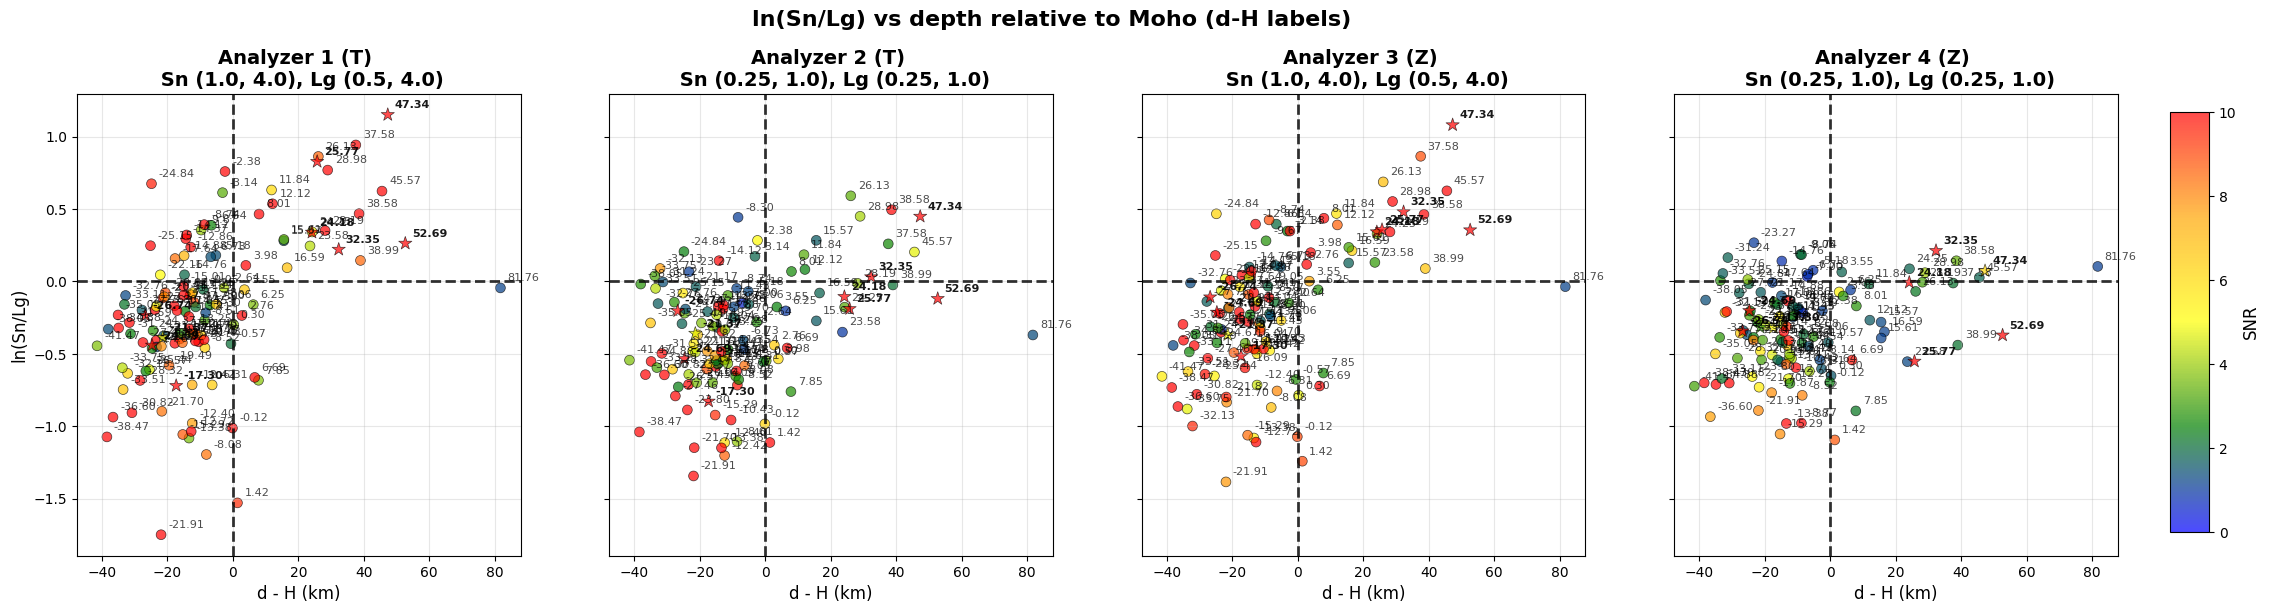

Plotted valid points per analyzer (after chosen filters):
  Analyzer 1: 119
  Analyzer 2: 119
  Analyzer 3: 119
  Analyzer 4: 119


In [5]:
# Dashed lines per analyzer plot: (d_h_value, ln_snlg_value)
dashed_line_values = [
	(0, 0),
	(0, 0),
	(0, 0),
	(0, 0),
]

# Extract data from results
d_h_values = []
is_special = []
event_depths = []

# y data per analyzer
rms_snlg_analyzer1 = []
rms_snlg_analyzer2 = []
rms_snlg_analyzer3 = []
rms_snlg_analyzer4 = []

# SNR per analyzer
snr_analyzer1 = []
snr_analyzer1_Sn = []
snr_analyzer1_Lg = []

snr_analyzer2 = []
snr_analyzer2_Sn = []
snr_analyzer2_Lg = []

snr_analyzer3 = []
snr_analyzer3_Sn = []
snr_analyzer3_Lg = []

snr_analyzer4 = []
snr_analyzer4_Sn = []
snr_analyzer4_Lg = []

for result in results:
	event, stream, analyzer1_result, analyzer2_result, tsn, tlg, analyzer3_result, analyzer4_result = result

	# Always collect, even if some analyzers are NaN; per-plot filtering happens later
	d_h_values.append(event.d_h)
	is_special.append(event.additional == '*')
	event_depths.append(event.event_dep)

	rms_snlg_analyzer1.append(analyzer1_result.SnRLg_raw if np.isfinite(analyzer1_result.SnRLg_raw) else np.nan)
	rms_snlg_analyzer2.append(analyzer2_result.SnRLg_raw if np.isfinite(analyzer2_result.SnRLg_raw) else np.nan)
	rms_snlg_analyzer3.append(analyzer3_result.SnRLg_raw if np.isfinite(analyzer3_result.SnRLg_raw) else np.nan)
	rms_snlg_analyzer4.append(analyzer4_result.SnRLg_raw if np.isfinite(analyzer4_result.SnRLg_raw) else np.nan)

	snr_analyzer1.append(analyzer1_result.SNR)
	snr_analyzer1_Sn.append(analyzer1_result.SNR_Sn)
	snr_analyzer1_Lg.append(analyzer1_result.SNR_Lg)

	snr_analyzer2.append(analyzer2_result.SNR)
	snr_analyzer2_Sn.append(analyzer2_result.SNR_Sn)
	snr_analyzer2_Lg.append(analyzer2_result.SNR_Lg)

	snr_analyzer3.append(analyzer3_result.SNR)
	snr_analyzer3_Sn.append(analyzer3_result.SNR_Sn)
	snr_analyzer3_Lg.append(analyzer3_result.SNR_Lg)

	snr_analyzer4.append(analyzer4_result.SNR)
	snr_analyzer4_Sn.append(analyzer4_result.SNR_Sn)
	snr_analyzer4_Lg.append(analyzer4_result.SNR_Lg)

# Convert to numpy arrays
d_h_values = np.array(d_h_values)
is_special = np.array(is_special)
event_depths = np.array(event_depths)

rms_snlg_analyzer1 = np.array(rms_snlg_analyzer1)
rms_snlg_analyzer2 = np.array(rms_snlg_analyzer2)
rms_snlg_analyzer3 = np.array(rms_snlg_analyzer3)
rms_snlg_analyzer4 = np.array(rms_snlg_analyzer4)

snr_analyzer1 = np.array(snr_analyzer1)
snr_analyzer1_Sn = np.array(snr_analyzer1_Sn)
snr_analyzer1_Lg = np.array(snr_analyzer1_Lg)

snr_analyzer2 = np.array(snr_analyzer2)
snr_analyzer2_Sn = np.array(snr_analyzer2_Sn)
snr_analyzer2_Lg = np.array(snr_analyzer2_Lg)

snr_analyzer3 = np.array(snr_analyzer3)
snr_analyzer3_Sn = np.array(snr_analyzer3_Sn)
snr_analyzer3_Lg = np.array(snr_analyzer3_Lg)

snr_analyzer4 = np.array(snr_analyzer4)
snr_analyzer4_Sn = np.array(snr_analyzer4_Sn)
snr_analyzer4_Lg = np.array(snr_analyzer4_Lg)

# Apply star-only filter
if plotStarOnly:
	mask = is_special
	d_h_values = d_h_values[mask]
	is_special = is_special[mask]
	event_depths = event_depths[mask]

	rms_snlg_analyzer1 = rms_snlg_analyzer1[mask]
	rms_snlg_analyzer2 = rms_snlg_analyzer2[mask]
	rms_snlg_analyzer3 = rms_snlg_analyzer3[mask]
	rms_snlg_analyzer4 = rms_snlg_analyzer4[mask]

	snr_analyzer1 = snr_analyzer1[mask]
	snr_analyzer1_Sn = snr_analyzer1_Sn[mask]
	snr_analyzer1_Lg = snr_analyzer1_Lg[mask]

	snr_analyzer2 = snr_analyzer2[mask]
	snr_analyzer2_Sn = snr_analyzer2_Sn[mask]
	snr_analyzer2_Lg = snr_analyzer2_Lg[mask]

	snr_analyzer3 = snr_analyzer3[mask]
	snr_analyzer3_Sn = snr_analyzer3_Sn[mask]
	snr_analyzer3_Lg = snr_analyzer3_Lg[mask]

	snr_analyzer4 = snr_analyzer4[mask]
	snr_analyzer4_Sn = snr_analyzer4_Sn[mask]
	snr_analyzer4_Lg = snr_analyzer4_Lg[mask]

# Colormap (blue -> green -> yellow -> orange -> red)
colors = ['blue', 'green', 'yellow', 'orange', 'red']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Figure with 4 subplots + space for colorbar
fig, axes = plt.subplots(1, 4, figsize=(26, 6), sharey=True)

# Data for each analyzer plot (titles include band info if available)
plot_data = [
	(rms_snlg_analyzer1, f"Analyzer 1 (T) \n Sn {one_sn_filt}, Lg {one_lg_filt}", snr_analyzer1, snr_analyzer1_Sn, snr_analyzer1_Lg),
	(rms_snlg_analyzer2, f"Analyzer 2 (T) \n Sn {two_sn_filt}, Lg {two_lg_filt}", snr_analyzer2, snr_analyzer2_Sn, snr_analyzer2_Lg),
	(rms_snlg_analyzer3, f"Analyzer 3 (Z) \n Sn {one_sn_filt}, Lg {one_lg_filt}", snr_analyzer3, snr_analyzer3_Sn, snr_analyzer3_Lg),
	(rms_snlg_analyzer4, f"Analyzer 4 (Z) \n Sn {two_sn_filt}, Lg {two_lg_filt}", snr_analyzer4, snr_analyzer4_Sn, snr_analyzer4_Lg),
]

# SNR colormap range
vmin_snr = 0
vmax_snr = 10

# Keep one scatter for colorbar
scatter_for_cbar = None

for i, (y_data, title, snr_values, snr_values_sn, snr_values_lg) in enumerate(plot_data):
	ax = axes[i]
	d_h_line, ln_snlg_line = dashed_line_values[i]

	# Per-plot SNR mask
	if plotSNROnly:
		snr_mask = snr_values > snlg_SNR_threshold
	elif plotSNROnly2:
		snr_mask = (snr_values_sn > snlg_SNR_threshold_2) & (snr_values_lg > snlg_SNR_threshold_2)
	else:
		snr_mask = np.ones_like(snr_values, dtype=bool)

	# Valid y-data mask
	valid_y = np.isfinite(y_data)

	# Regular events (circles)
	regular_mask = (~is_special) & valid_y & snr_mask
	if np.any(regular_mask):
		scatter_reg = ax.scatter(
			d_h_values[regular_mask], y_data[regular_mask],
			c=snr_values[regular_mask], cmap=cmap,
			vmin=vmin_snr, vmax=vmax_snr,
			marker='o', s=50, alpha=0.7, edgecolors='black', linewidth=0.5
		)
		if scatter_for_cbar is None:
			scatter_for_cbar = scatter_reg
		if plotLabels:
			for idx in np.where(regular_mask)[0]:
				ax.annotate(
					f'{d_h_values[idx]:.2f}',
					(d_h_values[idx], y_data[idx]),
					xytext=(5, 5), textcoords='offset points',
					fontsize=8, alpha=0.7
				)

	# Special events (stars)
	special_mask = is_special & valid_y & snr_mask
	if np.any(special_mask):
		scatter_spec = ax.scatter(
			d_h_values[special_mask], y_data[special_mask],
			c=snr_values[special_mask], cmap=cmap,
			vmin=vmin_snr, vmax=vmax_snr,
			marker='*', s=100, alpha=0.7, edgecolors='black', linewidth=0.5
		)
		if scatter_for_cbar is None:
			scatter_for_cbar = scatter_spec
		if plotLabels:
			for idx in np.where(special_mask)[0]:
				ax.annotate(
					f'{d_h_values[idx]:.2f}',
					(d_h_values[idx], y_data[idx]),
					xytext=(5, 5), textcoords='offset points',
					fontsize=8, alpha=0.9, weight='bold'
				)

	# Dashed guidelines
	ax.axvline(x=d_h_line, color='black', linestyle='--', alpha=0.8, linewidth=2)
	ax.axhline(y=ln_snlg_line, color='black', linestyle='--', alpha=0.8, linewidth=2)

	# Labels and title
	ax.set_xlabel('d - H (km)', fontsize=12)
	if i == 0:
		ax.set_ylabel('ln(Sn/Lg)', fontsize=12)
	ax.set_title(title, fontsize=14, fontweight='bold')
	ax.grid(True, alpha=0.3)

# Colorbar to the right
if scatter_for_cbar is not None:
	cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
	cbar = plt.colorbar(scatter_for_cbar, cax=cbar_ax)
	cbar.set_label('SNR', fontsize=12)

plt.subplots_adjust(right=0.91)

# Overall title
title_text = 'ln(Sn/Lg) vs depth relative to Moho'
if plotLabels:
	title_text += ' (d-H labels)'
if plotStarOnly:
	title_text += ' (Starred events only)'
if plotSNROnly:
	title_text += f' (Per-plot: SNR > {snlg_SNR_threshold})'
if plotSNROnly2:
	title_text += f' (Per-plot: Sn and Lg SNR > {snlg_SNR_threshold_2})'

fig.suptitle(title_text, fontsize=16, fontweight='bold', y=1.02)

plt.show()

# Summary statistics (per-plot criteria)
def count_pass(y, snr, snr_sn, snr_lg):
	valid = np.isfinite(y)
	if plotSNROnly:
		return int(np.sum(valid & (snr > snlg_SNR_threshold)))
	if plotSNROnly2:
		return int(np.sum(valid & (snr_sn > snlg_SNR_threshold_2) & (snr_lg > snlg_SNR_threshold_2)))
	return int(np.sum(valid))

print(f"Plotted valid points per analyzer (after chosen filters):")
print(f"  Analyzer 1: {count_pass(rms_snlg_analyzer1, snr_analyzer1, snr_analyzer1_Sn, snr_analyzer1_Lg)}")
print(f"  Analyzer 2: {count_pass(rms_snlg_analyzer2, snr_analyzer2, snr_analyzer2_Sn, snr_analyzer2_Lg)}")
print(f"  Analyzer 3: {count_pass(rms_snlg_analyzer3, snr_analyzer3, snr_analyzer3_Sn, snr_analyzer3_Lg)}")
print(f"  Analyzer 4: {count_pass(rms_snlg_analyzer4, snr_analyzer4, snr_analyzer4_Sn, snr_analyzer4_Lg)}")

## Sn/Lg v. Sn/Lg (frequency)

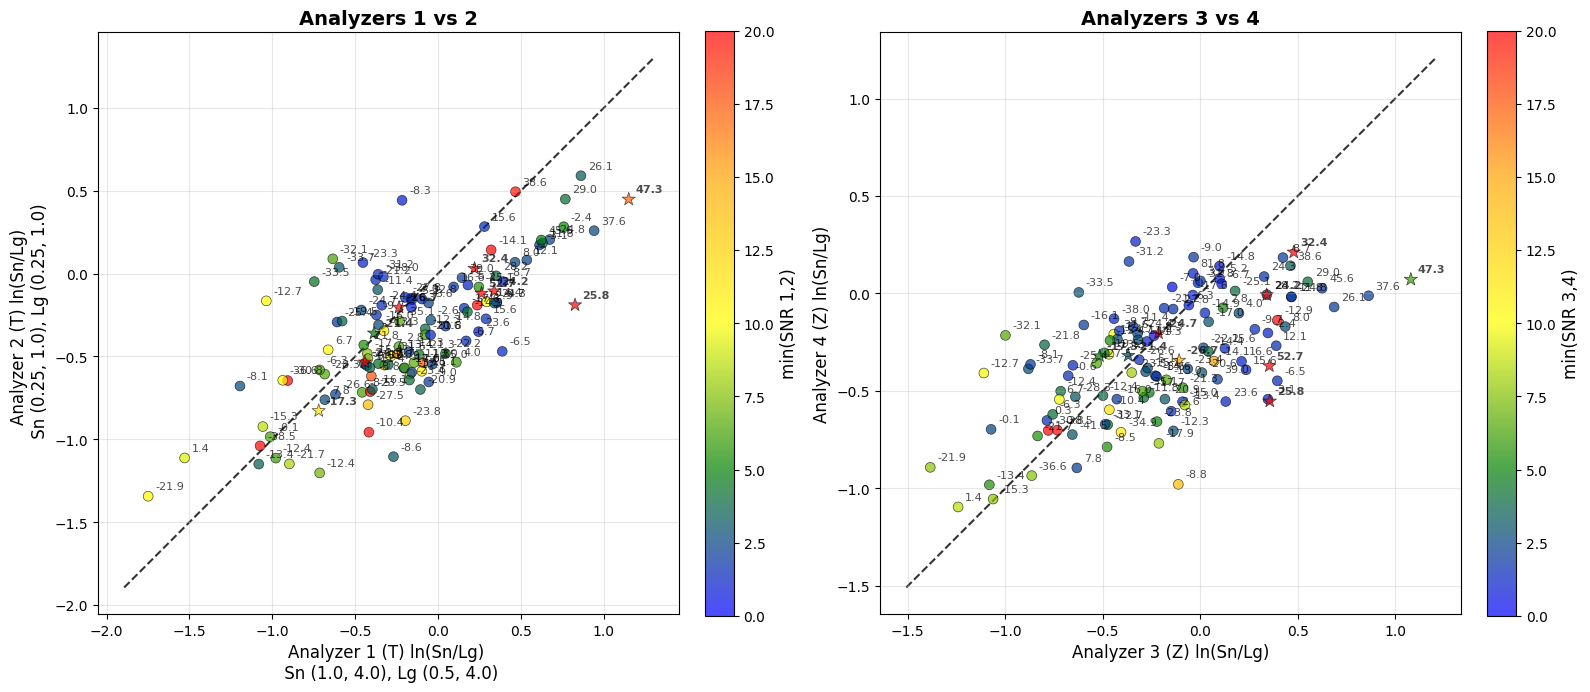


--- Stats (1 vs 2) ---
Correlation (masked): 0.723  N=119

--- Stats (3 vs 4) ---
Correlation (masked): 0.593  N=119


In [6]:
# Colormap for SNR
colors = ['blue', 'green', 'yellow', 'orange', 'red']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Prepare SNRs
min_snr_12 = np.minimum(snr_analyzer1, snr_analyzer2)
min_snr_34 = np.minimum(snr_analyzer3, snr_analyzer4)

# Use a consistent color range across both subplots
vmin_snr = 0
vmax_snr = 20  # adjust as needed
# Alternatively dynamic:
# vmin_snr = float(np.nanmin(np.hstack([min_snr_12, min_snr_34])))
# vmax_snr = float(np.nanmax(np.hstack([min_snr_12, min_snr_34])))

# Base masks
N = len(d_h_values)
base_mask = np.ones(N, dtype=bool)
if plotStarOnly:
	base_mask &= is_special

# SNR criteria
if plotSNROnly2:
	# Strict: both Sn and Lg SNR exceed threshold for BOTH analyzers in the subplot
	mask_12_snr = (snr_analyzer1_Sn > snlg_SNR_threshold_2) & (snr_analyzer1_Lg > snlg_SNR_threshold_2) & \
	              (snr_analyzer2_Sn > snlg_SNR_threshold_2) & (snr_analyzer2_Lg > snlg_SNR_threshold_2)
	mask_34_snr = (snr_analyzer3_Sn > snlg_SNR_threshold_2) & (snr_analyzer3_Lg > snlg_SNR_threshold_2) & \
	              (snr_analyzer4_Sn > snlg_SNR_threshold_2) & (snr_analyzer4_Lg > snlg_SNR_threshold_2)
elif plotSNROnly:
	# Simple: min(SNR) for the pair exceeds threshold
	mask_12_snr = (min_snr_12 > snlg_SNR_threshold)
	mask_34_snr = (min_snr_34 > snlg_SNR_threshold)
else:
	mask_12_snr = np.ones(N, dtype=bool)
	mask_34_snr = np.ones(N, dtype=bool)

# Final masks per subplot
mask_12 = base_mask & mask_12_snr
mask_34 = base_mask & mask_34_snr

# Build figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
scatter_for_cbar_1 = None
scatter_for_cbar_2 = None

# ---------- Subplot 1: Analyzer 1 vs 2 ----------
regular_mask_12 = mask_12 & (~is_special)
if np.any(regular_mask_12):
	scatter_reg = ax1.scatter(
		rms_snlg_analyzer1[regular_mask_12],
		rms_snlg_analyzer2[regular_mask_12],
		c=min_snr_12[regular_mask_12],
		cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
		marker='o', s=50, alpha=0.7, edgecolors='black', linewidth=0.5
	)
	scatter_for_cbar_1 = scatter_reg
	if plotLabels:
		for idx in np.where(regular_mask_12)[0]:
			ax1.annotate(f'{d_h_values[idx]:.1f}',
			             (rms_snlg_analyzer1[idx], rms_snlg_analyzer2[idx]),
			             xytext=(5, 5), textcoords='offset points',
			             fontsize=8, alpha=0.7)

special_mask_12 = mask_12 & is_special
if np.any(special_mask_12):
	scatter_spec = ax1.scatter(
		rms_snlg_analyzer1[special_mask_12],
		rms_snlg_analyzer2[special_mask_12],
		c=min_snr_12[special_mask_12],
		cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
		marker='*', s=100, alpha=0.7, edgecolors='black', linewidth=0.5
	)
	if scatter_for_cbar_1 is None:
		scatter_for_cbar_1 = scatter_spec
	if plotLabels:
		for idx in np.where(special_mask_12)[0]:
			ax1.annotate(f'{d_h_values[idx]:.1f}',
			             (rms_snlg_analyzer1[idx], rms_snlg_analyzer2[idx]),
			             xytext=(5, 5), textcoords='offset points',
			             fontsize=8, alpha=0.7, weight='bold')

lims1 = [
	min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
	max(ax1.get_xlim()[1], ax1.get_ylim()[1]),
]
ax1.plot(lims1, lims1, 'k--', alpha=0.8, zorder=0)

ax1.set_xlabel(f'Analyzer 1 (T) ln(Sn/Lg) \n Sn {one_sn_filt}, Lg {one_lg_filt}', fontsize=12)
ax1.set_ylabel(f'Analyzer 2 (T) ln(Sn/Lg) \n Sn {two_sn_filt}, Lg {two_lg_filt}', fontsize=12)
title1 = 'Analyzers 1 vs 2'
if plotStarOnly:   title1 += ' (Starred only)'
if plotSNROnly:    title1 += f' (min SNR > {snlg_SNR_threshold})'
if plotSNROnly2:   title1 += f' (Sn & Lg SNR > {snlg_SNR_threshold_2} both)'
ax1.set_title(title1, fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

if scatter_for_cbar_1 is not None:
	cbar1 = fig.colorbar(scatter_for_cbar_1, ax=ax1, fraction=0.046, pad=0.04)
	cbar1.set_label('min(SNR 1,2)', fontsize=12)

# ---------- Subplot 2: Analyzer 3 vs 4 ----------
regular_mask_34 = mask_34 & (~is_special)
if np.any(regular_mask_34):
    scatter_reg = ax2.scatter(
        rms_snlg_analyzer3[regular_mask_34],
        rms_snlg_analyzer4[regular_mask_34],
        c=min_snr_34[regular_mask_34],
        cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
        marker='o', s=50, alpha=0.7, edgecolors='black', linewidth=0.5
    )
    scatter_for_cbar_2 = scatter_reg
    if plotLabels:
        for idx in np.where(regular_mask_34)[0]:
            ax2.annotate(
                f'{d_h_values[idx]:.1f}',
                (rms_snlg_analyzer3[idx], rms_snlg_analyzer4[idx]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7
            )

special_mask_34 = mask_34 & is_special
if np.any(special_mask_34):
	scatter_spec = ax2.scatter(
		rms_snlg_analyzer3[special_mask_34],
		rms_snlg_analyzer4[special_mask_34],
		c=min_snr_34[special_mask_34],
		cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
		marker='*', s=100, alpha=0.7, edgecolors='black', linewidth=0.5
	)
	if scatter_for_cbar_2 is None:
		scatter_for_cbar_2 = scatter_spec
	if plotLabels:
		for idx in np.where(special_mask_34)[0]:
			ax2.annotate(f'{d_h_values[idx]:.1f}',
			             (rms_snlg_analyzer3[idx], rms_snlg_analyzer4[idx]),
			             xytext=(5, 5), textcoords='offset points',
			             fontsize=8, alpha=0.7, weight='bold')

lims2 = [
	min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
	max(ax2.get_xlim()[1], ax2.get_ylim()[1]),
]
ax2.plot(lims2, lims2, 'k--', alpha=0.8, zorder=0)

ax2.set_xlabel(f'Analyzer 3 (Z) ln(Sn/Lg)', fontsize=12)
ax2.set_ylabel(f'Analyzer 4 (Z) ln(Sn/Lg)', fontsize=12)
title2 = 'Analyzers 3 vs 4'
if plotStarOnly:   title2 += ' (Starred only)'
if plotSNROnly:    title2 += f' (min SNR > {snlg_SNR_threshold})'
if plotSNROnly2:   title2 += f' (Sn & Lg SNR > {snlg_SNR_threshold_2})'
ax2.set_title(title2, fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

if scatter_for_cbar_2 is not None:
	cbar2 = fig.colorbar(scatter_for_cbar_2, ax=ax2, fraction=0.046, pad=0.04)
	cbar2.set_label('min(SNR 3,4)', fontsize=12)

plt.tight_layout()
plt.show()

# ---- Stats (with correct boolean logic) ----
print("\n--- Stats (1 vs 2) ---")
corr12 = np.corrcoef(rms_snlg_analyzer1[mask_12], rms_snlg_analyzer2[mask_12])[0, 1] if np.sum(mask_12) > 1 else np.nan
print(f"Correlation (masked): {corr12:.3f}  N={np.sum(mask_12)}")
if plotSNROnly2:
	n1 = np.sum((snr_analyzer1_Sn > snlg_SNR_threshold_2) & (snr_analyzer1_Lg > snlg_SNR_threshold_2))
	n2 = np.sum((snr_analyzer2_Sn > snlg_SNR_threshold_2) & (snr_analyzer2_Lg > snlg_SNR_threshold_2))
	print(f"Analyzer 1 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n1}")
	print(f"Analyzer 2 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n2}")

print("\n--- Stats (3 vs 4) ---")
corr34 = np.corrcoef(rms_snlg_analyzer3[mask_34], rms_snlg_analyzer4[mask_34])[0, 1] if np.sum(mask_34) > 1 else np.nan
print(f"Correlation (masked): {corr34:.3f}  N={np.sum(mask_34)}")
if plotSNROnly2:
	n3 = np.sum((snr_analyzer3_Sn > snlg_SNR_threshold_2) & (snr_analyzer3_Lg > snlg_SNR_threshold_2))
	n4 = np.sum((snr_analyzer4_Sn > snlg_SNR_threshold_2) & (snr_analyzer4_Lg > snlg_SNR_threshold_2))
	print(f"Analyzer 3 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n3}")
	print(f"Analyzer 4 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n4}")

## Sn/Lg v. Sn/Lg (component)

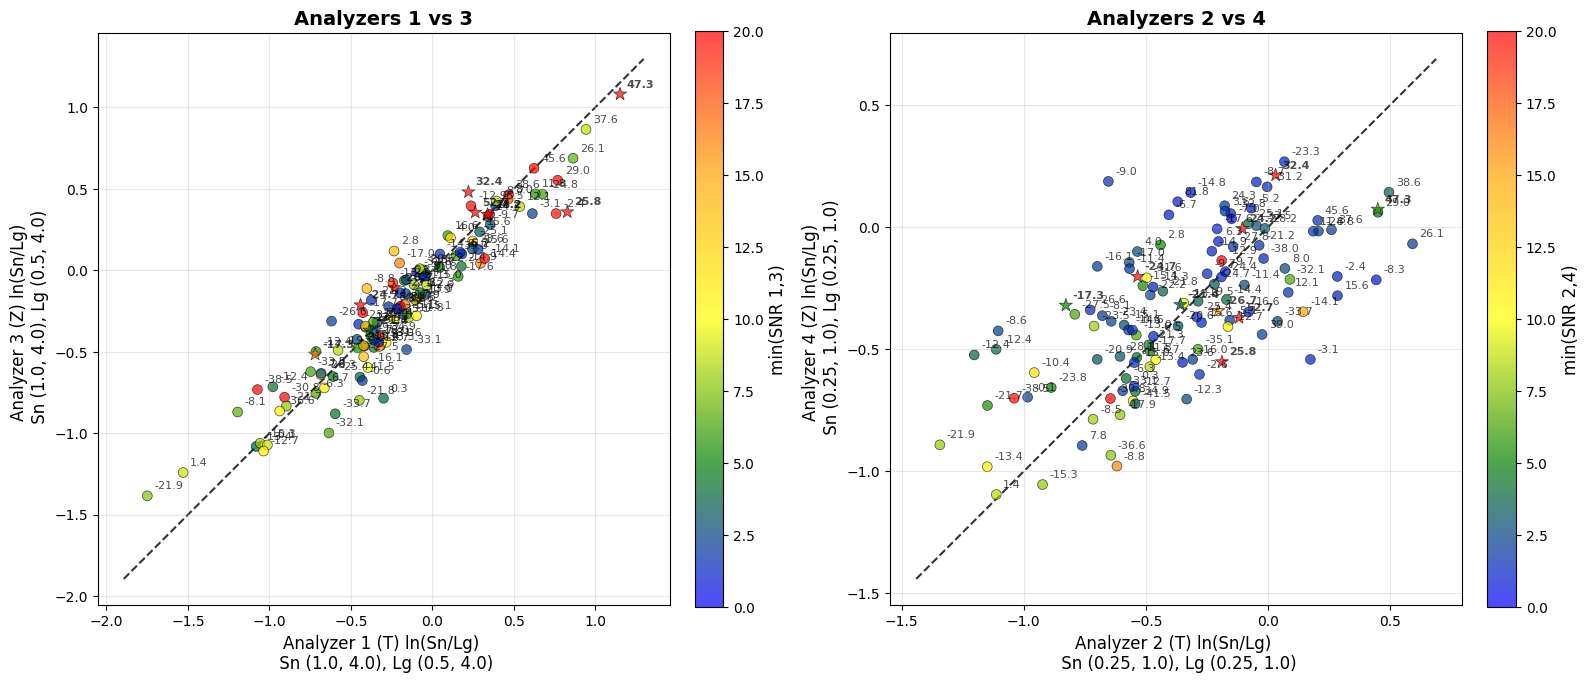


--- Stats (1 vs 3) ---
Correlation (masked): 0.946  N=119

--- Stats (2 vs 4) ---
Correlation (masked): 0.648  N=119


In [7]:
# Colormap for SNR
colors = ['blue', 'green', 'yellow', 'orange', 'red']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Prepare SNRs for cross-component comparisons
min_snr_13 = np.minimum(snr_analyzer1, snr_analyzer3)
min_snr_24 = np.minimum(snr_analyzer2, snr_analyzer4)

# Use a consistent color range across both subplots
vmin_snr = 0
vmax_snr = 20  # adjust as needed
# Alternatively dynamic:
# vmin_snr = float(np.nanmin(np.hstack([min_snr_13, min_snr_24])))
# vmax_snr = float(np.nanmax(np.hstack([min_snr_13, min_snr_24])))

# Base masks
N = len(d_h_values)
base_mask = np.ones(N, dtype=bool)
if plotStarOnly:
    base_mask &= is_special

# SNR criteria
if plotSNROnly2:
    # Strict: both Sn and Lg SNR exceed threshold for BOTH analyzers in the subplot
    mask_13_snr = (snr_analyzer1_Sn > snlg_SNR_threshold_2) & (snr_analyzer1_Lg > snlg_SNR_threshold_2) & \
                  (snr_analyzer3_Sn > snlg_SNR_threshold_2) & (snr_analyzer3_Lg > snlg_SNR_threshold_2)
    mask_24_snr = (snr_analyzer2_Sn > snlg_SNR_threshold_2) & (snr_analyzer2_Lg > snlg_SNR_threshold_2) & \
                  (snr_analyzer4_Sn > snlg_SNR_threshold_2) & (snr_analyzer4_Lg > snlg_SNR_threshold_2)
elif plotSNROnly:
    # Simple: min(SNR) for the pair exceeds threshold
    mask_13_snr = (min_snr_13 > snlg_SNR_threshold)
    mask_24_snr = (min_snr_24 > snlg_SNR_threshold)
else:
    mask_13_snr = np.ones(N, dtype=bool)
    mask_24_snr = np.ones(N, dtype=bool)

# Final masks per subplot
mask_13 = base_mask & mask_13_snr
mask_24 = base_mask & mask_24_snr

# Build figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
scatter_for_cbar_1 = None
scatter_for_cbar_2 = None

# ---------- Subplot 1: Analyzer 1 (T) vs 3 (Z) ----------
regular_mask_13 = mask_13 & (~is_special)
if np.any(regular_mask_13):
    scatter_reg = ax1.scatter(
        rms_snlg_analyzer1[regular_mask_13],
        rms_snlg_analyzer3[regular_mask_13],
        c=min_snr_13[regular_mask_13],
        cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
        marker='o', s=50, alpha=0.7, edgecolors='black', linewidth=0.5
    )
    scatter_for_cbar_1 = scatter_reg
    if plotLabels:
        for idx in np.where(regular_mask_13)[0]:
            ax1.annotate(f'{d_h_values[idx]:.1f}',
                         (rms_snlg_analyzer1[idx], rms_snlg_analyzer3[idx]),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=8, alpha=0.7)

special_mask_13 = mask_13 & is_special
if np.any(special_mask_13):
    scatter_spec = ax1.scatter(
        rms_snlg_analyzer1[special_mask_13],
        rms_snlg_analyzer3[special_mask_13],
        c=min_snr_13[special_mask_13],
        cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
        marker='*', s=100, alpha=0.7, edgecolors='black', linewidth=0.5
    )
    if scatter_for_cbar_1 is None:
        scatter_for_cbar_1 = scatter_spec
    if plotLabels:
        for idx in np.where(special_mask_13)[0]:
            ax1.annotate(f'{d_h_values[idx]:.1f}',
                         (rms_snlg_analyzer1[idx], rms_snlg_analyzer3[idx]),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=8, alpha=0.7, weight='bold')

lims1 = [
    min(ax1.get_xlim()[0], ax1.get_ylim()[0]),
    max(ax1.get_xlim()[1], ax1.get_ylim()[1]),
]
ax1.plot(lims1, lims1, 'k--', alpha=0.8, zorder=0)

ax1.set_xlabel(f'Analyzer 1 (T) ln(Sn/Lg) \n Sn {one_sn_filt}, Lg {one_lg_filt}', fontsize=12)
ax1.set_ylabel(f'Analyzer 3 (Z) ln(Sn/Lg) \n Sn {one_sn_filt}, Lg {one_lg_filt}', fontsize=12)
title1 = 'Analyzers 1 vs 3'
if plotStarOnly:   title1 += ' (Starred only)'
if plotSNROnly:    title1 += f' (min SNR > {snlg_SNR_threshold})'
if plotSNROnly2:   title1 += f' (Sn & Lg SNR > {snlg_SNR_threshold_2} both)'
ax1.set_title(title1, fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

if scatter_for_cbar_1 is not None:
    cbar1 = fig.colorbar(scatter_for_cbar_1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('min(SNR 1,3)', fontsize=12)

# ---------- Subplot 2: Analyzer 2 (T) vs 4 (Z) ----------
regular_mask_24 = mask_24 & (~is_special)
if np.any(regular_mask_24):
    scatter_reg = ax2.scatter(
        rms_snlg_analyzer2[regular_mask_24],
        rms_snlg_analyzer4[regular_mask_24],
        c=min_snr_24[regular_mask_24],
        cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
        marker='o', s=50, alpha=0.7, edgecolors='black', linewidth=0.5
    )
    scatter_for_cbar_2 = scatter_reg
    if plotLabels:
        for idx in np.where(regular_mask_24)[0]:
            ax2.annotate(
                f'{d_h_values[idx]:.1f}',
                (rms_snlg_analyzer2[idx], rms_snlg_analyzer4[idx]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.7
            )

special_mask_24 = mask_24 & is_special
if np.any(special_mask_24):
    scatter_spec = ax2.scatter(
        rms_snlg_analyzer2[special_mask_24],
        rms_snlg_analyzer4[special_mask_24],
        c=min_snr_24[special_mask_24],
        cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
        marker='*', s=100, alpha=0.7, edgecolors='black', linewidth=0.5
    )
    if scatter_for_cbar_2 is None:
        scatter_for_cbar_2 = scatter_spec
    if plotLabels:
        for idx in np.where(special_mask_24)[0]:
            ax2.annotate(f'{d_h_values[idx]:.1f}',
                         (rms_snlg_analyzer2[idx], rms_snlg_analyzer4[idx]),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=8, alpha=0.7, weight='bold')

lims2 = [
    min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
    max(ax2.get_xlim()[1], ax2.get_ylim()[1]),
]
ax2.plot(lims2, lims2, 'k--', alpha=0.8, zorder=0)

ax2.set_xlabel(f'Analyzer 2 (T) ln(Sn/Lg) \n Sn {two_sn_filt}, Lg {two_lg_filt}', fontsize=12)
ax2.set_ylabel(f'Analyzer 4 (Z) ln(Sn/Lg) \n Sn {two_sn_filt}, Lg {two_lg_filt}', fontsize=12)
title2 = 'Analyzers 2 vs 4'
if plotStarOnly:   title2 += ' (Starred only)'
if plotSNROnly:    title2 += f' (min SNR > {snlg_SNR_threshold})'
if plotSNROnly2:   title2 += f' (Sn & Lg SNR > {snlg_SNR_threshold_2})'
ax2.set_title(title2, fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

if scatter_for_cbar_2 is not None:
    cbar2 = fig.colorbar(scatter_for_cbar_2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label('min(SNR 2,4)', fontsize=12)

plt.tight_layout()
plt.show()

# ---- Stats (with correct boolean logic) ----
print("\n--- Stats (1 vs 3) ---")
corr13 = np.corrcoef(rms_snlg_analyzer1[mask_13], rms_snlg_analyzer3[mask_13])[0, 1] if np.sum(mask_13) > 1 else np.nan
print(f"Correlation (masked): {corr13:.3f}  N={np.sum(mask_13)}")
if plotSNROnly2:
    n1 = np.sum((snr_analyzer1_Sn > snlg_SNR_threshold_2) & (snr_analyzer1_Lg > snlg_SNR_threshold_2))
    n3 = np.sum((snr_analyzer3_Sn > snlg_SNR_threshold_2) & (snr_analyzer3_Lg > snlg_SNR_threshold_2))
    print(f"Analyzer 1 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n1}")
    print(f"Analyzer 3 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n3}")

print("\n--- Stats (2 vs 4) ---")
corr24 = np.corrcoef(rms_snlg_analyzer2[mask_24], rms_snlg_analyzer4[mask_24])[0, 1] if np.sum(mask_24) > 1 else np.nan
print(f"Correlation (masked): {corr24:.3f}  N={np.sum(mask_24)}")
if plotSNROnly2:
    n2 = np.sum((snr_analyzer2_Sn > snlg_SNR_threshold_2) & (snr_analyzer2_Lg > snlg_SNR_threshold_2))
    n4 = np.sum((snr_analyzer4_Sn > snlg_SNR_threshold_2) & (snr_analyzer4_Lg > snlg_SNR_threshold_2))
    print(f"Analyzer 2 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n2}")
    print(f"Analyzer 4 with Sn & Lg SNR > {snlg_SNR_threshold_2}: {n4}")

## Δ Sn/Lg v. d, d-H

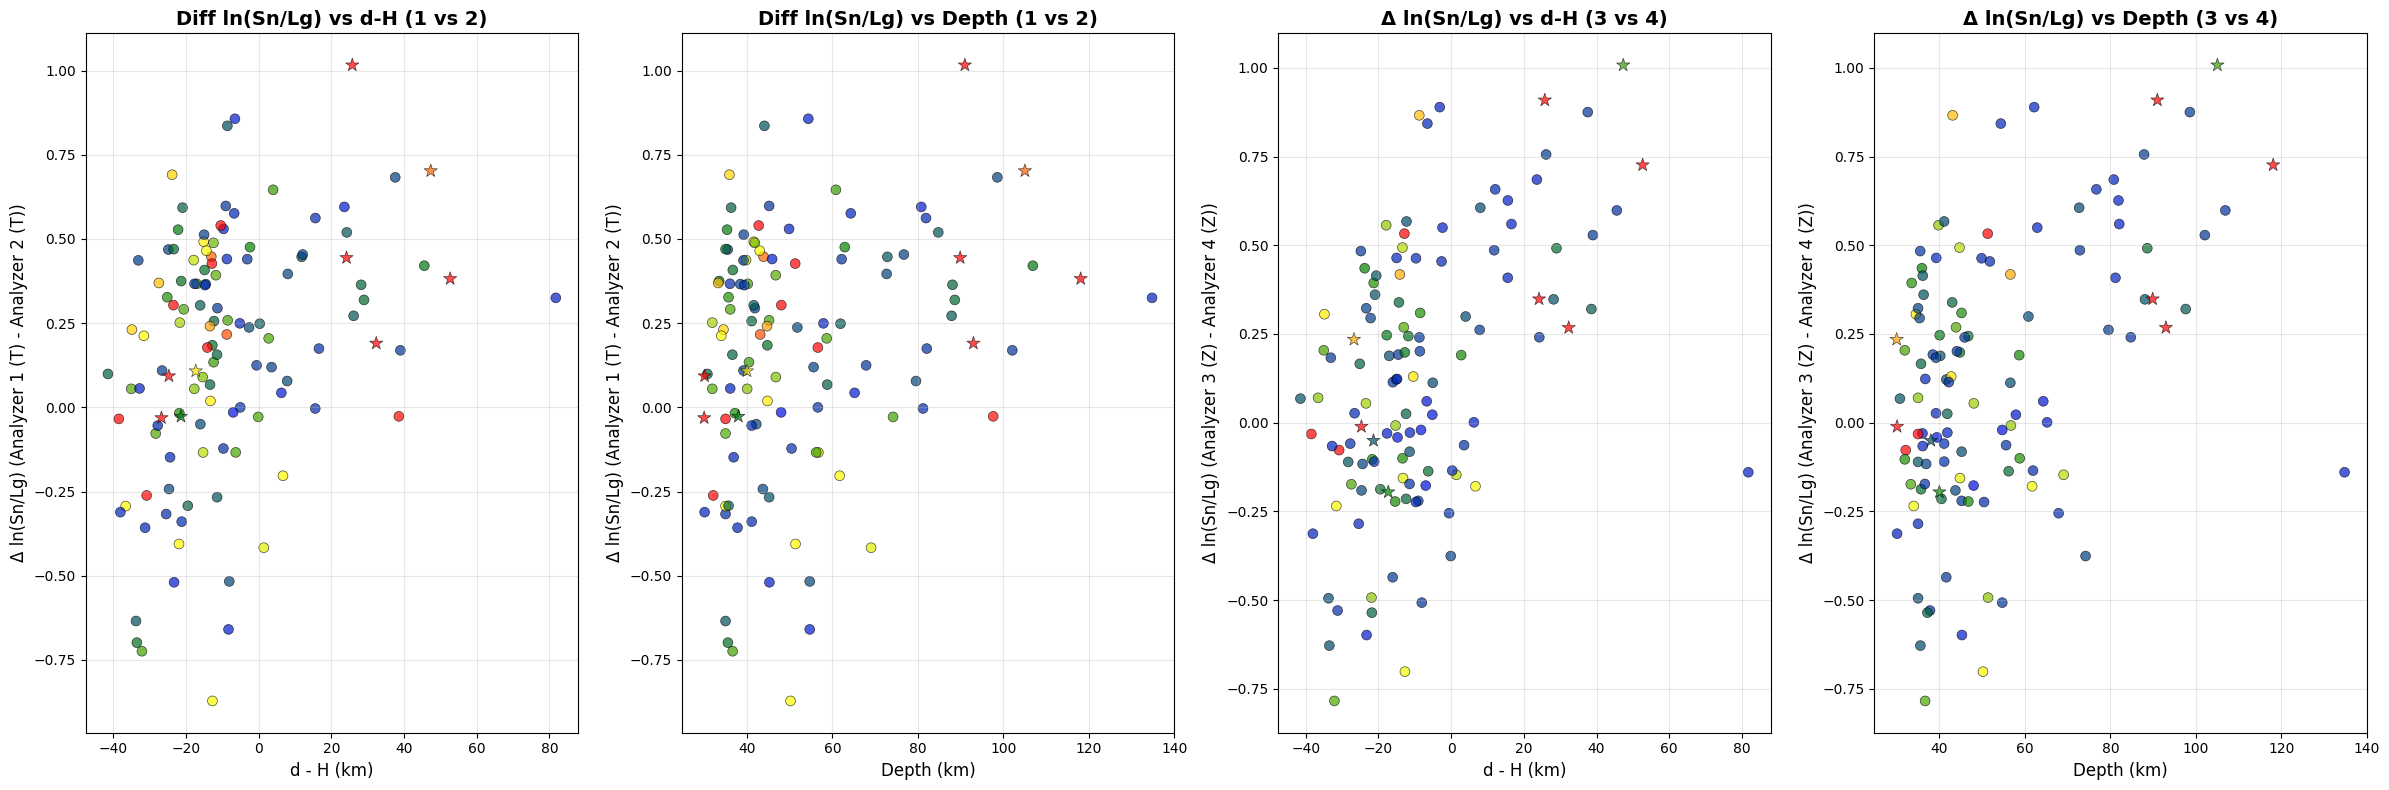

(1 vs 2) Corr(Δ ln(Sn/Lg), d-H): 0.345 (N=119)
(1 vs 2) Corr(Δ ln(Sn/Lg), Depth): 0.250 (N=119)
(3 vs 4) Corr(Δ ln(Sn/Lg), d-H): 0.474 (N=119)
(3 vs 4) Corr(Δ ln(Sn/Lg), Depth): 0.430 (N=119)


In [8]:
fig, axes = plt.subplots(1, 4, figsize=(24, 8))

# Colormap for SNR
colors = ['blue', 'green', 'yellow', 'orange', 'red']
n_bins = 256
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Differences in ln(Sn/Lg)
diff_snlg_12 = rms_snlg_analyzer1 - rms_snlg_analyzer2
diff_snlg_34 = rms_snlg_analyzer3 - rms_snlg_analyzer4

# min(SNR) across analyzers for coloring
min_snr_12 = np.minimum(snr_analyzer1, snr_analyzer2)
min_snr_34 = np.minimum(snr_analyzer3, snr_analyzer4)

# Color scale limits for SNR
vmin_snr = 0
vmax_snr = 20
# Dynamic alternative:
# vmin_snr = float(np.nanmin(np.hstack([min_snr_12, min_snr_34])))
# vmax_snr = float(np.nanmax(np.hstack([min_snr_12, min_snr_34])))

# Common masks
regular_mask = ~is_special
special_mask = is_special

# -------------------- Plot 1: d-H vs Δ ln(Sn/Lg) for analyzers 1-2 --------------------
ax1 = axes[0]
scatter_for_cbar1 = None

if np.any(regular_mask):
    scatter_reg = ax1.scatter(
        d_h_values[regular_mask],
        diff_snlg_12[regular_mask],
        c=min_snr_12[regular_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='o',
        s=50,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar1 is None:
        scatter_for_cbar1 = scatter_reg

if np.any(special_mask):
    scatter_spec = ax1.scatter(
        d_h_values[special_mask],
        diff_snlg_12[special_mask],
        c=min_snr_12[special_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='*',
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar1 is None:
        scatter_for_cbar1 = scatter_spec

ax1.set_xlabel('d - H (km)', fontsize=12)
ax1.set_ylabel('Δ ln(Sn/Lg) (Analyzer 1 (T) - Analyzer 2 (T))', fontsize=12)
ax1.set_title('Diff ln(Sn/Lg) vs d-H (1 vs 2)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# -------------------- Plot 2: Depth vs Δ ln(Sn/Lg) for analyzers 1-2 --------------------
ax2 = axes[1]
scatter_for_cbar2 = None

if np.any(regular_mask):
    scatter_reg2 = ax2.scatter(
        event_depths[regular_mask],
        diff_snlg_12[regular_mask],
        c=min_snr_12[regular_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='o',
        s=50,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar2 is None:
        scatter_for_cbar2 = scatter_reg2

if np.any(special_mask):
    scatter_spec2 = ax2.scatter(
        event_depths[special_mask],
        diff_snlg_12[special_mask],
        c=min_snr_12[special_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='*',
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar2 is None:
        scatter_for_cbar2 = scatter_spec2

ax2.set_xlabel('Depth (km)', fontsize=12)
ax2.set_ylabel('Δ ln(Sn/Lg) (Analyzer 1 (T) - Analyzer 2 (T))', fontsize=12)
ax2.set_title('Diff ln(Sn/Lg) vs Depth (1 vs 2)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# -------------------- Plot 3: d-H vs Δ ln(Sn/Lg) for analyzers 3-4 --------------------
ax3 = axes[2]
scatter_for_cbar3 = None

if np.any(regular_mask):
    scatter_reg3 = ax3.scatter(
        d_h_values[regular_mask],
        diff_snlg_34[regular_mask],
        c=min_snr_34[regular_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='o',
        s=50,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar3 is None:
        scatter_for_cbar3 = scatter_reg3

if np.any(special_mask):
    scatter_spec3 = ax3.scatter(
        d_h_values[special_mask],
        diff_snlg_34[special_mask],
        c=min_snr_34[special_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='*',
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar3 is None:
        scatter_for_cbar3 = scatter_spec3

ax3.set_xlabel('d - H (km)', fontsize=12)
ax3.set_ylabel('Δ ln(Sn/Lg) (Analyzer 3 (Z) - Analyzer 4 (Z))', fontsize=12)
ax3.set_title('Δ ln(Sn/Lg) vs d-H (3 vs 4)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# -------------------- Plot 4: Depth vs Δ ln(Sn/Lg) for analyzers 3-4 --------------------
ax4 = axes[3]
scatter_for_cbar4 = None

if np.any(regular_mask):
    scatter_reg4 = ax4.scatter(
        event_depths[regular_mask],
        diff_snlg_34[regular_mask],
        c=min_snr_34[regular_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='o',
        s=50,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar4 is None:
        scatter_for_cbar4 = scatter_reg4

if np.any(special_mask):
    scatter_spec4 = ax4.scatter(
        event_depths[special_mask],
        diff_snlg_34[special_mask],
        c=min_snr_34[special_mask],
        cmap=cmap,
        vmin=vmin_snr,
        vmax=vmax_snr,
        marker='*',
        s=100,
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    if scatter_for_cbar4 is None:
        scatter_for_cbar4 = scatter_spec4

ax4.set_xlabel('Depth (km)', fontsize=12)
ax4.set_ylabel('Δ ln(Sn/Lg) (Analyzer 3 (Z) - Analyzer 4 (Z))', fontsize=12)
ax4.set_title('Δ ln(Sn/Lg) vs Depth (3 vs 4)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# -------------------- Colorbars --------------------
# if scatter_for_cbar1 is not None:
#     cbar1 = fig.colorbar(scatter_for_cbar1, ax=axes[0:2], fraction=0.046, pad=0.04)
#     cbar1.set_label('min(SNR 1,2)', fontsize=12)
# if scatter_for_cbar3 is not None:
#     cbar2 = fig.colorbar(scatter_for_cbar3, ax=axes[2:4], fraction=0.046, pad=0.04)
#     cbar2.set_label('min(SNR 3,4)', fontsize=12)

plt.tight_layout()
plt.show()

# -------------------- Correlations --------------------
valid_mask_dh_12 = np.isfinite(d_h_values) & np.isfinite(diff_snlg_12)
valid_mask_depth_12 = np.isfinite(event_depths) & np.isfinite(diff_snlg_12)
valid_mask_dh_34 = np.isfinite(d_h_values) & np.isfinite(diff_snlg_34)
valid_mask_depth_34 = np.isfinite(event_depths) & np.isfinite(diff_snlg_34)

if np.sum(valid_mask_dh_12) >= 2:
    corr_dh_12 = np.corrcoef(d_h_values[valid_mask_dh_12], diff_snlg_12[valid_mask_dh_12])[0, 1]
    print(f"(1 vs 2) Corr(Δ ln(Sn/Lg), d-H): {corr_dh_12:.3f} (N={np.sum(valid_mask_dh_12)})")
else:
    print("(1 vs 2) Insufficient data for d-H correlation")

if np.sum(valid_mask_depth_12) >= 2:
    corr_depth_12 = np.corrcoef(event_depths[valid_mask_depth_12], diff_snlg_12[valid_mask_depth_12])[0, 1]
    print(f"(1 vs 2) Corr(Δ ln(Sn/Lg), Depth): {corr_depth_12:.3f} (N={np.sum(valid_mask_depth_12)})")
else:
    print("(1 vs 2) Insufficient data for depth correlation")

if np.sum(valid_mask_dh_34) >= 2:
    corr_dh_34 = np.corrcoef(d_h_values[valid_mask_dh_34], diff_snlg_34[valid_mask_dh_34])[0, 1]
    print(f"(3 vs 4) Corr(Δ ln(Sn/Lg), d-H): {corr_dh_34:.3f} (N={np.sum(valid_mask_dh_34)})")
else:
    print("(3 vs 4) Insufficient data for d-H correlation")

if np.sum(valid_mask_depth_34) >= 2:
    corr_depth_34 = np.corrcoef(event_depths[valid_mask_depth_34], diff_snlg_34[valid_mask_depth_34])[0, 1]
    print(f"(3 vs 4) Corr(Δ ln(Sn/Lg), Depth): {corr_depth_34:.3f} (N={np.sum(valid_mask_depth_34)})")
else:
    print("(3 vs 4) Insufficient data for depth correlation")

## d-H v. distance

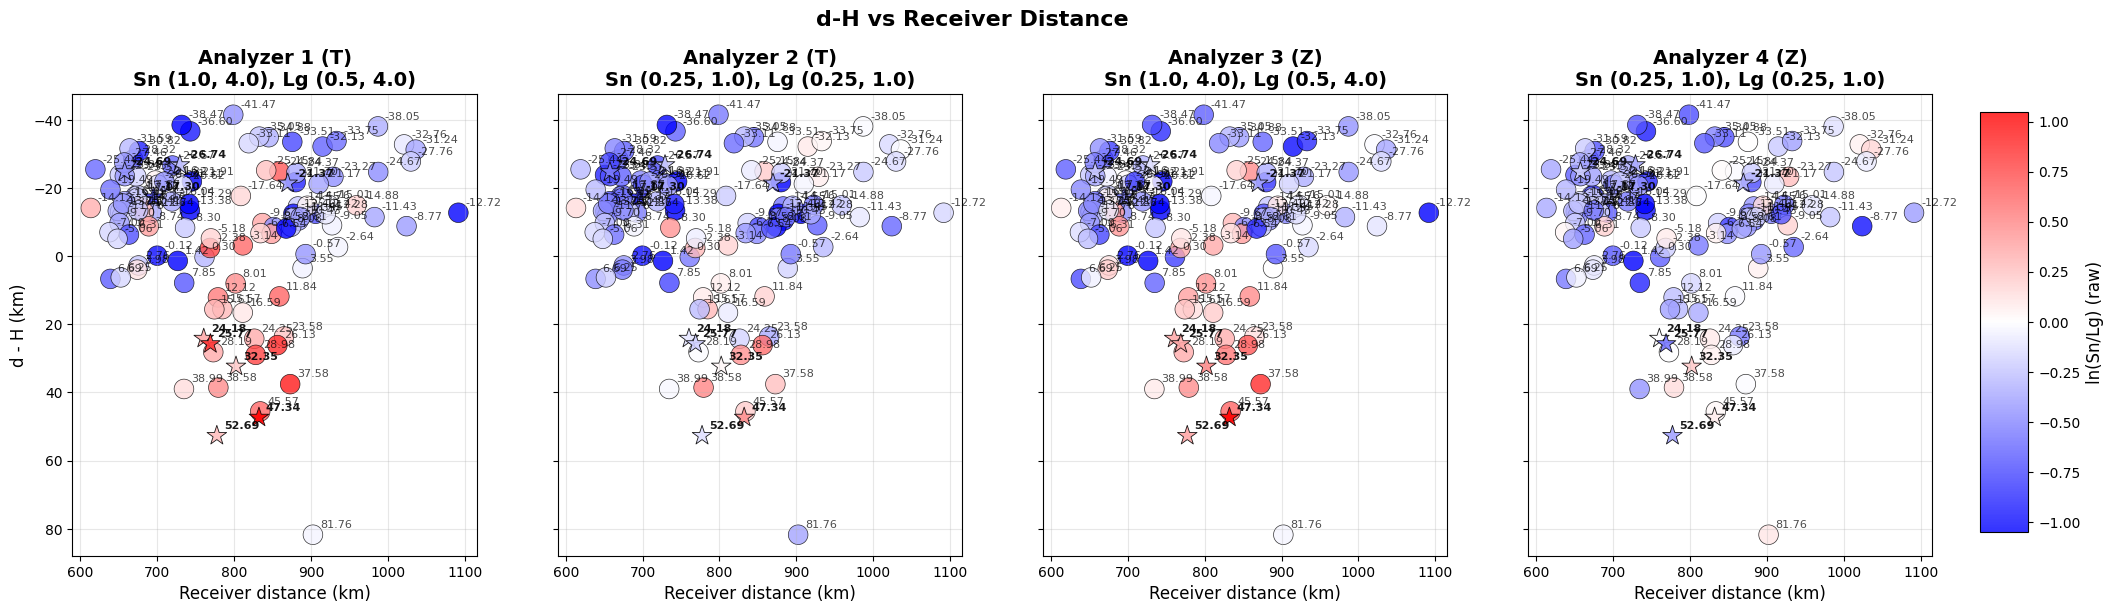

Events plotted per plot:
  Analyzer 1: 119
  Analyzer 2: 119
  Analyzer 3: 119
  Analyzer 4: 119


In [9]:
# Collect arrays aligned to results (no filtering here; masks applied per-plot)
recv_dist_km = []
d_h_all = []
is_star_all = []

y1, y2, y3, y4 = [], [], [], []
snr1, snr2, snr3, snr4 = [], [], [], []
snr1_sn, snr1_lg = [], []
snr2_sn, snr2_lg = [], []
snr3_sn, snr3_lg = [], []
snr4_sn, snr4_lg = [], []

for event, stream, a1, a2, tsn, tlg, a3, a4 in results:
    # receiver distance (km)
    stla = stream[0].stats.sac.stla
    stlo = stream[0].stats.sac.stlo
    evla = event.event_lat
    evlo = event.event_lon
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, stla, stlo)
    recv_dist_km.append(dist_m / 1000.0)

    # d - H and star flag
    d_h_all.append(event.d_h)
    is_star_all.append(getattr(event, 'additional', None) == '*')

    # ln(Sn/Lg) raw values (may be NaN)
    y1.append(a1.SnRLg_raw if np.isfinite(a1.SnRLg_raw) else np.nan)
    y2.append(a2.SnRLg_raw if np.isfinite(a2.SnRLg_raw) else np.nan)
    y3.append(a3.SnRLg_raw if np.isfinite(a3.SnRLg_raw) else np.nan)
    y4.append(a4.SnRLg_raw if np.isfinite(a4.SnRLg_raw) else np.nan)

    # SNRs
    snr1.append(a1.SNR); snr2.append(a2.SNR); snr3.append(a3.SNR); snr4.append(a4.SNR)
    snr1_sn.append(a1.SNR_Sn); snr1_lg.append(a1.SNR_Lg)
    snr2_sn.append(a2.SNR_Sn); snr2_lg.append(a2.SNR_Lg)
    snr3_sn.append(a3.SNR_Sn); snr3_lg.append(a3.SNR_Lg)
    snr4_sn.append(a4.SNR_Sn); snr4_lg.append(a4.SNR_Lg)

# To numpy
recv_dist_km = np.array(recv_dist_km)
d_h_all = np.array(d_h_all)
is_star_all = np.array(is_star_all, dtype=bool)

y1 = np.array(y1); y2 = np.array(y2); y3 = np.array(y3); y4 = np.array(y4)
snr1 = np.array(snr1); snr2 = np.array(snr2); snr3 = np.array(snr3); snr4 = np.array(snr4)
snr1_sn = np.array(snr1_sn); snr1_lg = np.array(snr1_lg)
snr2_sn = np.array(snr2_sn); snr2_lg = np.array(snr2_lg)
snr3_sn = np.array(snr3_sn); snr3_lg = np.array(snr3_lg)
snr4_sn = np.array(snr4_sn); snr4_lg = np.array(snr4_lg)

# Plot setup
cmap = LinearSegmentedColormap.from_list('red_white_blue', ['blue', 'white', 'red'], N=256)

# Symmetric color limits across all analyzers
vals_stack = np.concatenate([arr for arr in [y1, y2, y3, y4] if arr.size])
absmax = float(np.nanmax(np.abs(vals_stack))) if np.isfinite(vals_stack).any() else 1.0
vlim = max(absmax * 0.6, 1e-6)  # saturation factor
vmin_val, vmax_val = -vlim, vlim

fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)
panel_defs = [
    (y1, f"Analyzer 1 (T)\nSn {one_sn_filt}, Lg {one_lg_filt}", snr1, snr1_sn, snr1_lg),
    (y2, f"Analyzer 2 (T)\nSn {two_sn_filt}, Lg {two_lg_filt}", snr2, snr2_sn, snr2_lg),
    (y3, f"Analyzer 3 (Z)\nSn {one_sn_filt}, Lg {one_lg_filt}", snr3, snr3_sn, snr3_lg),
    (y4, f"Analyzer 4 (Z)\nSn {two_sn_filt}, Lg {two_lg_filt}", snr4, snr4_sn, snr4_lg),
]

scatter_for_cbar = None
plotted_counts = [0, 0, 0, 0]

for i, (ydata, title, snr_vals, snr_sn_vals, snr_lg_vals) in enumerate(panel_defs):
    ax = axes[i]

    # Per-plot SNR mask (mask-based)
    if plotSNROnly:
        snr_mask = snr_vals > snlg_SNR_threshold
    elif plotSNROnly2:
        snr_mask = (snr_sn_vals > snlg_SNR_threshold_2) & (snr_lg_vals > snlg_SNR_threshold_2)
    else:
        snr_mask = np.ones_like(ydata, dtype=bool)

    valid_y = np.isfinite(ydata)

    # Star-only handling in masks
    if plotStarOnly:
        regular_base = np.zeros_like(is_star_all, dtype=bool)
        special_base = is_star_all
    else:
        regular_base = ~is_star_all
        special_base = is_star_all

    # Regular events (circles)
    regular_mask = regular_base & valid_y & snr_mask
    if np.any(regular_mask):
        sc_reg = ax.scatter(
            recv_dist_km[regular_mask], d_h_all[regular_mask],
            c=ydata[regular_mask], cmap=cmap, vmin=vmin_val, vmax=vmax_val,
            marker='o', s=200, alpha=0.8, edgecolors='black', linewidth=0.5
        )
        if scatter_for_cbar is None:
            scatter_for_cbar = sc_reg
        if plotLabels:
            for idx in np.where(regular_mask)[0]:
                ax.annotate(
                    f'{d_h_all[idx]:.2f}',
                    (recv_dist_km[idx], d_h_all[idx]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7
                )

    # Special events (stars)
    special_mask = special_base & valid_y & snr_mask
    if np.any(special_mask):
        sc_spec = ax.scatter(
            recv_dist_km[special_mask], d_h_all[special_mask],
            c=ydata[special_mask], cmap=cmap, vmin=vmin_val, vmax=vmax_val,
            marker='*', s=220, alpha=0.9, edgecolors='black', linewidth=0.6
        )
        if scatter_for_cbar is None:
            scatter_for_cbar = sc_spec
        if plotLabels:
            for idx in np.where(special_mask)[0]:
                ax.annotate(
                    f'{d_h_all[idx]:.2f}',
                    (recv_dist_km[idx], d_h_all[idx]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.9, weight='bold'
                )

    # Count plotted points for this subplot
    plotted_counts[i] = int(np.sum(regular_mask) + np.sum(special_mask))

    ax.set_xlabel('Receiver distance (km)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.set_ylabel('d - H (km)', fontsize=12)

# Invert d-H axis (increase downward)
if d_h_all.size:
    ymin, ymax = float(np.nanmin(d_h_all)), float(np.nanmax(d_h_all))
    pad = 0.05 * max(ymax - ymin, 1e-6)
    for ax in axes:
        ax.set_ylim(ymax + pad, ymin - pad)

# Colorbar
if scatter_for_cbar is not None:
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(scatter_for_cbar, cax=cax)
    cbar.set_label('ln(Sn/Lg) (raw)', fontsize=12)

plt.subplots_adjust(right=0.9)
title_text = 'd-H vs Receiver Distance'
if plotStarOnly:
    title_text += ' (Starred only)'
if plotSNROnly:
    title_text += f' (SNR > {snlg_SNR_threshold})'
if plotSNROnly2:
    title_text += f' (Sn & Lg SNR > {snlg_SNR_threshold_2})'
fig.suptitle(title_text, fontsize=16, fontweight='bold', y=1.02)
plt.show()

# How many dots per figure
names = ["Analyzer 1", "Analyzer 2", "Analyzer 3", "Analyzer 4"]
print("Events plotted per plot:")
for name, cnt in zip(names, plotted_counts):
    print(f"  {name}: {cnt}")

## SNR v. d-H

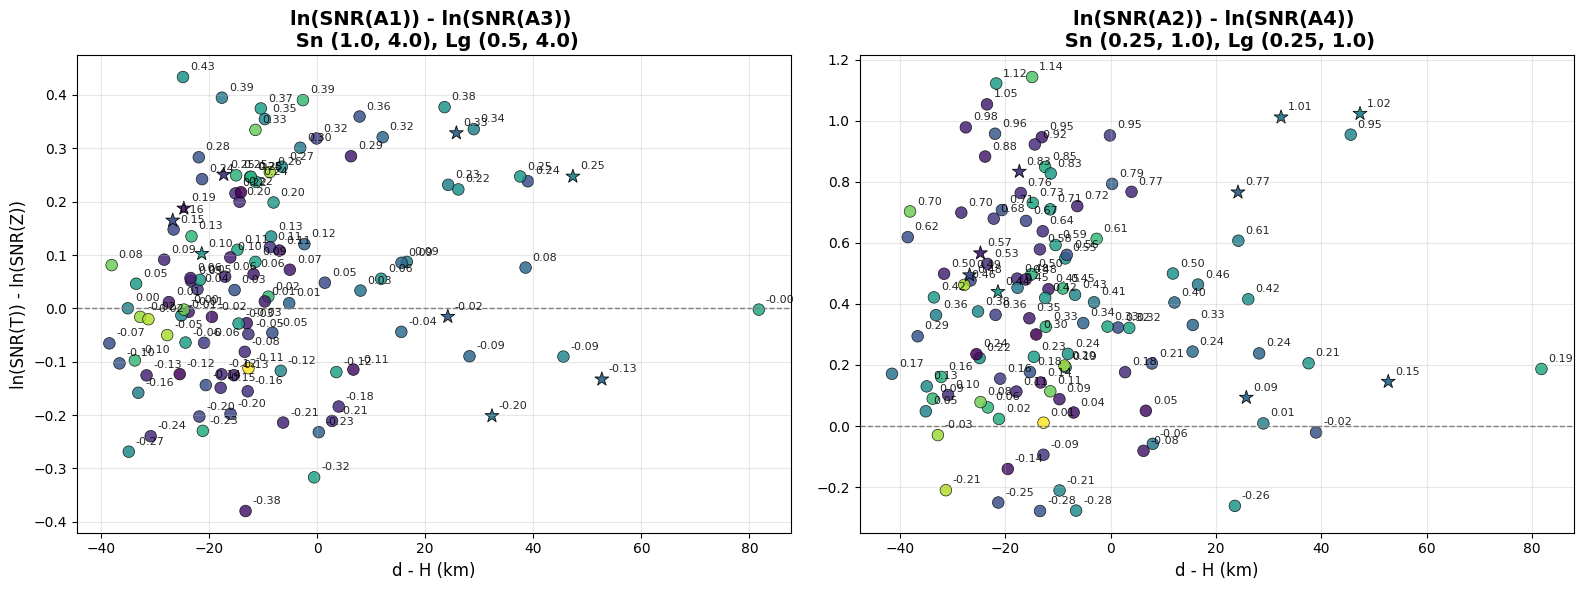

Band 1 (A1-A3): 6 outliers removed (outside [-0.382, 0.461])
  d-H, ln(SNR(T)) - ln(SNR(Z)): [(-12.4, 0.52), (-8.61, 0.48), (-32.13, -0.41), (-13.38, -0.4), (-41.47, -0.38), (-14.88, 0.5)]
Band 2 (A2-A4): 6 outliers removed (outside [-0.415, 1.302])
  d-H, ln(SNR(T)) - ln(SNR(Z)): [(-15.13, 1.39), (38.58, 1.74), (-24.37, -0.53), (-2.38, 1.51), (-5.06, -0.49), (-8.74, -0.55)]


In [10]:
# Compute SNR differences (T - Z) for each band
diff_band1 = np.log(snr_analyzer1) - np.log(snr_analyzer3)  # A1 - A3
diff_band2 = np.log(snr_analyzer2) - np.log(snr_analyzer4)  # A2 - A4

# Base validity: need finite d-H and finite differences
valid1 = np.isfinite(d_h_values) & np.isfinite(diff_band1)
valid2 = np.isfinite(d_h_values) & np.isfinite(diff_band2)

# Star-only mask (no SNR masking for this plot!)
star_mask = (is_special if plotStarOnly else np.ones_like(is_special, dtype=bool))

base_mask1 = valid1 & star_mask
base_mask2 = valid2 & star_mask

# Outlier clipping on Y (difference) using percentile limits
lower_q = 0.02  # 2nd percentile
upper_q = 0.98  # 98th percentile
def apply_percentile_clip(y_vals, base_mask, lq, uq):
    inds = np.where(base_mask)[0]
    if inds.size >= 5:
        y_sel = y_vals[inds]
        y_sel = y_sel[np.isfinite(y_sel)]
        if y_sel.size >= 5:
            lo = np.nanpercentile(y_sel, lq * 100.0)
            hi = np.nanpercentile(y_sel, uq * 100.0)
            return base_mask & (y_vals >= lo) & (y_vals <= hi), lo, hi
    return base_mask, None, None

mask1, lo1, hi1 = apply_percentile_clip(diff_band1, base_mask1, lower_q, upper_q)
mask2, lo2, hi2 = apply_percentile_clip(diff_band2, base_mask2, lower_q, upper_q)

# Identify outliers removed
outliers1 = base_mask1 & ~mask1
outliers2 = base_mask2 & ~mask2

# Use existing receiver distances (km) for coloring
dist_vals = np.asarray(recv_dist_km, dtype=float)

# Ensure finite distances for plotted points
finite_dist = np.isfinite(dist_vals)
mask1 = mask1 & finite_dist
mask2 = mask2 & finite_dist

# Sequential colormap for distance, normalized across both panels
cmap_dist = plt.cm.viridis
vals_dist_all = np.concatenate([dist_vals[mask1], dist_vals[mask2]]) if (np.any(mask1) or np.any(mask2)) else np.array([0.0])
vals_dist_all = vals_dist_all[np.isfinite(vals_dist_all)]
if vals_dist_all.size:
    dmin, dmax = float(np.nanmin(vals_dist_all)), float(np.nanmax(vals_dist_all))
else:
    dmin, dmax = 0.0, 1.0
if dmin == dmax:
    dmin -= 0.5
    dmax += 0.5
norm_dist = plt.Normalize(vmin=dmin, vmax=dmax)

# Figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
scatter_handles = []

def set_limits(ax, xvals, yvals):
    if xvals.size:
        xvals = xvals[np.isfinite(xvals)]
    if yvals.size:
        yvals = yvals[np.isfinite(yvals)]
    if xvals.size:
        xmin, xmax = float(np.nanmin(xvals)), float(np.nanmax(xvals))
        if xmin == xmax:
            xmin -= 0.5
            xmax += 0.5
        xpad = 0.05 * (xmax - xmin)
        ax.set_xlim(xmin - xpad, xmax + xpad)
    if yvals.size:
        ymin, ymax = float(np.nanmin(yvals)), float(np.nanmax(yvals))
        if ymin == ymax:
            ymin -= 0.5
            ymax += 0.5
        ypad = 0.05 * (ymax - ymin)
        ax.set_ylim(ymin - ypad, ymax + ypad)

# Panel helper
def plot_panel(ax, mask, diff_vals, title):
    reg = mask & (~is_special)
    spc = mask & is_special

    if np.any(reg):
        sc_reg = ax.scatter(d_h_values[reg], diff_vals[reg],
                            c=dist_vals[reg], cmap=cmap_dist, norm=norm_dist,
                            marker='o', s=70, alpha=0.85, edgecolors='black', linewidth=0.5)
        scatter_handles.append(sc_reg)
    if np.any(spc):
        sc_spc = ax.scatter(d_h_values[spc], diff_vals[spc],
                            c=dist_vals[spc], cmap=cmap_dist, norm=norm_dist,
                            marker='*', s=110, alpha=0.95, edgecolors='black', linewidth=0.6)
        scatter_handles.append(sc_spc)

    if plotLabels and (np.any(reg) or np.any(spc)):
        for idx in np.where(mask)[0]:
            ax.annotate(f'{diff_vals[idx]:.2f}',
                        (d_h_values[idx], diff_vals[idx]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.85)

    ax.axhline(0.0, color='grey', linestyle='--', linewidth=1)
    ax.set_xlabel('d - H (km)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    set_limits(ax, d_h_values[mask], diff_vals[mask])

# Plot panels
plot_panel(axes[0], mask1, diff_band1, f'ln(SNR(A1)) - ln(SNR(A3)) \n Sn {one_sn_filt}, Lg {one_lg_filt}')
axes[0].set_ylabel('ln(SNR(T)) - ln(SNR(Z))', fontsize=12)

plot_panel(axes[1], mask2, diff_band2, f'ln(SNR(A2)) - ln(SNR(A4)) \n Sn {two_sn_filt}, Lg {two_lg_filt}')

# Shared colorbar for receiver distance
# cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm_dist, cmap=cmap_dist),
#                     ax=axes.ravel().tolist())
# cbar.set_label('Receiver distance from KBL (km)')

plt.tight_layout()
plt.show()

# Outlier report
def report_outliers(name, out_mask, d_h, diffs, lo, hi):
    count = int(np.sum(out_mask))
    print(f"{name}: {count} outliers removed", end="")
    if lo is not None and hi is not None:
        print(f" (outside [{lo:.3f}, {hi:.3f}])")
    else:
        print()
    if count > 0:
        dh_vals = d_h[out_mask]
        diff_vals = diffs[out_mask]
        pairs = [(float(f"{dh:.2f}"), float(f"{dv:.2f}")) for dh, dv in zip(dh_vals, diff_vals)]
        print(f"  d-H, ln(SNR(T)) - ln(SNR(Z)): {pairs}")

report_outliers("Band 1 (A1-A3)", outliers1, d_h_values, diff_band1, lo1, hi1)
report_outliers("Band 2 (A2-A4)", outliers2, d_h_values, diff_band2, lo2, hi2)

## HF/LF v. d-H

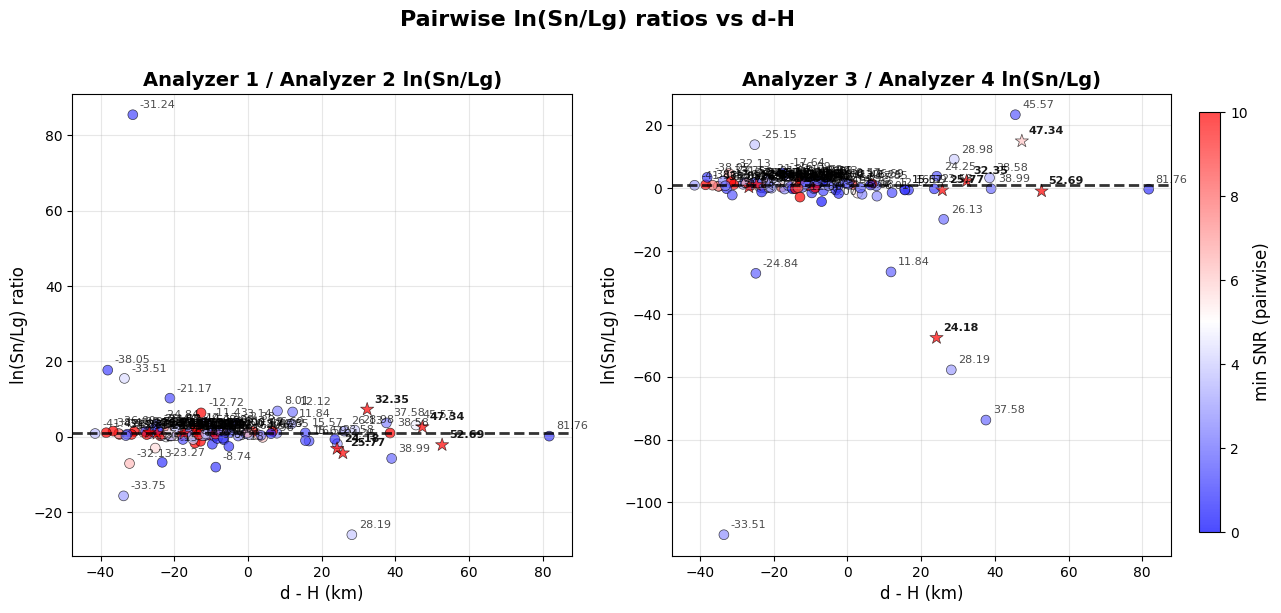

Plotted valid points per ratio plot (after chosen filters):
  A1/A2 ratio: 119
  A3/A4 ratio: 119


In [11]:
# Dashed guideline positions for the ratio plots: (x=d_h_line, y=ratio_line)
dashed_line_values_ratio = [
	(0, 1),  # For A1/A2
	(0, 1),  # For A3/A4
]

# Compute ln(Sn/Lg) ratio for analyzers 1/2 and 3/4
with np.errstate(divide='ignore', invalid='ignore'):
	y_ratio_12 = np.divide(rms_snlg_analyzer1, rms_snlg_analyzer2)
	y_ratio_12[~np.isfinite(y_ratio_12)] = np.nan
	y_ratio_34 = np.divide(rms_snlg_analyzer3, rms_snlg_analyzer4)
	y_ratio_34[~np.isfinite(y_ratio_34)] = np.nan

# Combined SNR metrics for coloring and filtering
snr_min_12 = np.minimum(snr_analyzer1, snr_analyzer2)
snr_min_34 = np.minimum(snr_analyzer3, snr_analyzer4)

# For plotSNROnly2 toggle (per-band)
snr_min_12_sn = np.minimum(snr_analyzer1_Sn, snr_analyzer2_Sn)
snr_min_12_lg = np.minimum(snr_analyzer1_Lg, snr_analyzer2_Lg)
snr_min_34_sn = np.minimum(snr_analyzer3_Sn, snr_analyzer4_Sn)
snr_min_34_lg = np.minimum(snr_analyzer3_Lg, snr_analyzer4_Lg)

# Base mask (optionally restrict to starred events only)
base_mask = is_special if plotStarOnly else np.ones_like(d_h_values, dtype=bool)

# Colormap (blue -> green -> yellow -> orange -> red)
try:
	cmap  # use existing if defined
except NameError:
	colors = ['blue', 'green', 'yellow', 'orange', 'red']
	cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

# Figure with 2 subplots + space for colorbar
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

plot_defs = [
	("Analyzer 1 / Analyzer 2 ln(Sn/Lg)", y_ratio_12, snr_min_12, snr_min_12_sn, snr_min_12_lg),
	("Analyzer 3 / Analyzer 4 ln(Sn/Lg)", y_ratio_34, snr_min_34, snr_min_34_sn, snr_min_34_lg),
]

vmin_snr = 0
vmax_snr = 10
scatter_for_cbar = None

count_plotted = []

for i, (title, y_data, snr_min_all, snr_min_sn, snr_min_lg) in enumerate(plot_defs):
	ax = axes[i]
	d_h_line, ratio_line = dashed_line_values_ratio[i]

	# Per-plot SNR mask
	if plotSNROnly:
		snr_mask = snr_min_all > snlg_SNR_threshold
	elif plotSNROnly2:
		snr_mask = (snr_min_sn > snlg_SNR_threshold_2) & (snr_min_lg > snlg_SNR_threshold_2)
	else:
		snr_mask = np.ones_like(snr_min_all, dtype=bool)

	valid_y = np.isfinite(y_data)

	regular_mask = (~is_special) & base_mask & valid_y & snr_mask
	special_mask = is_special & base_mask & valid_y & snr_mask

	total_this_ax = int(np.sum(regular_mask) + np.sum(special_mask))
	count_plotted.append(total_this_ax)

	if np.any(regular_mask):
		scatter_reg = ax.scatter(
			d_h_values[regular_mask], y_data[regular_mask],
			c=snr_min_all[regular_mask], cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
			marker='o', s=50, alpha=0.7, edgecolors='black', linewidth=0.5
		)
		if scatter_for_cbar is None:
			scatter_for_cbar = scatter_reg
		if plotLabels:
			for idx in np.where(regular_mask)[0]:
				ax.annotate(
					f'{d_h_values[idx]:.2f}',
					(d_h_values[idx], y_data[idx]),
					xytext=(5, 5), textcoords='offset points',
					fontsize=8, alpha=0.7
				)

	if np.any(special_mask):
		scatter_spec = ax.scatter(
			d_h_values[special_mask], y_data[special_mask],
			c=snr_min_all[special_mask], cmap=cmap, vmin=vmin_snr, vmax=vmax_snr,
			marker='*', s=100, alpha=0.7, edgecolors='black', linewidth=0.5
		)
		if scatter_for_cbar is None:
			scatter_for_cbar = scatter_spec
		if plotLabels:
			for idx in np.where(special_mask)[0]:
				ax.annotate(
					f'{d_h_values[idx]:.2f}',
					(d_h_values[idx], y_data[idx]),
					xytext=(5, 5), textcoords='offset points',
					fontsize=8, alpha=0.9, weight='bold'
				)

	# Dashed guidelines
	# ax.axvline(x=d_h_line, color='black', linestyle='--', alpha=0.8, linewidth=2)
	ax.axhline(y=ratio_line, color='black', linestyle='--', alpha=0.8, linewidth=2)

	ax.set_xlabel('d - H (km)', fontsize=12)
	ax.set_ylabel('ln(Sn/Lg) ratio', fontsize=12)
	ax.set_title(title, fontsize=14, fontweight='bold')
	ax.grid(True, alpha=0.3)

# Single colorbar to the right
if scatter_for_cbar is not None:
	cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
	cbar = plt.colorbar(scatter_for_cbar, cax=cbar_ax)
	cbar.set_label('min SNR (pairwise)', fontsize=12)

plt.subplots_adjust(right=0.91)
fig.suptitle('Pairwise ln(Sn/Lg) ratios vs d-H', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("Plotted valid points per ratio plot (after chosen filters):")
print(f"  A1/A2 ratio: {count_plotted[0]}")
print(f"  A3/A4 ratio: {count_plotted[1]}")

# Analysis 2

## Examine waveforms

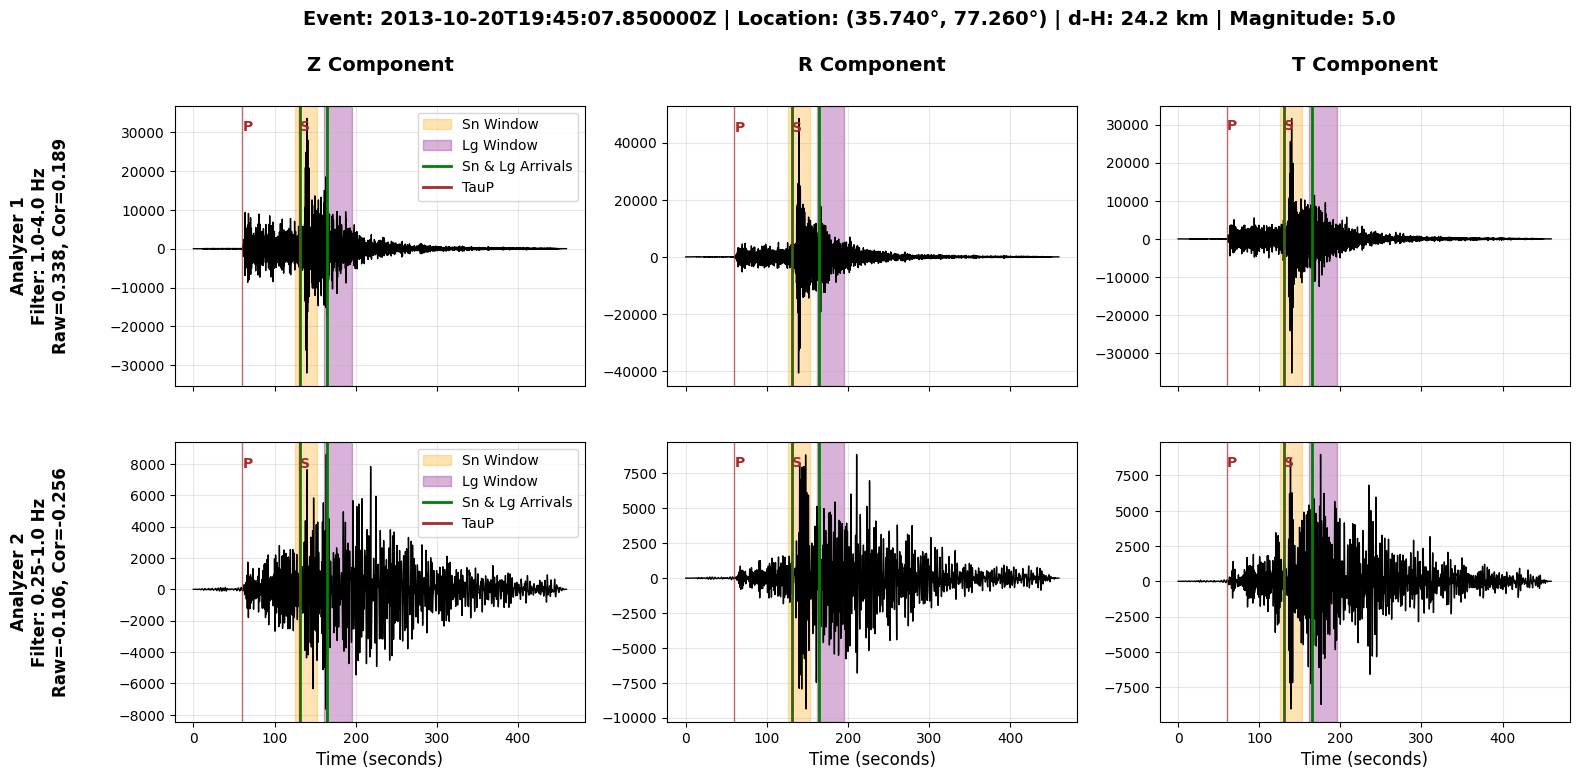

In [12]:
def select_and_plot_waveform(date_string, results, plot_TauP=True, phases=["Sn", "S", "P", 'Ps']):
    """
    Select a waveform by date string and plot it with Sn/Lg windows and arrivals.
    
    Parameters:
    date_string: str in format 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS'
    results: list of result tuples
    plot_TauP: bool, whether to plot TauP arrivals
    phases: list of phases to plot from TauP
    """
    
    # Parse the date string
    try:
        if len(date_string) == 10:  # YYYY-MM-DD format
            target_date = datetime.strptime(date_string, '%Y-%m-%d')
            # Find events on that date
            matching_results = []
            for result in results:
                event, stream, analyzer1_result, analyzer2_result, tsn, tlg, analyzer3_result, analyzer4_result = result
                event_date = event.event_time.datetime.date()
                if event_date == target_date.date():
                    matching_results.append(result)
    except ValueError as e:
        print(f"Error parsing date: {e}")
        return
    
    if not matching_results:
        print(f"No events found for date: {date_string}")
        return
    
    # If multiple events found, use the first one
    if len(matching_results) > 1:
        print(f"Multiple events found for {date_string}, using the first one")
    
    event, stream, analyzer1_result, analyzer2_result, tsn, tlg, analyzer3_result, analyzer4_result = matching_results[0]

    # Get p arrival for shift
    dist_m, _, _ = gps2dist_azimuth(event.event_lat, event.event_lon, stream[0].stats.sac.stla, stream[0].stats.sac.stlo)
    dist_km = dist_m / 1000.0
    dist_deg = kilometer2degrees(dist_km)
    arrivals = model.get_travel_times(source_depth_in_km=event.event_dep, distance_in_degree=dist_deg)
    p_arrival = [arrival for arrival in arrivals if arrival.name == 'P' or arrival.name == 'p'][0]

    # Create two copies of the stream for different filters
    stream1 = stream.copy()
    stream2 = stream.copy()
    
    # Process stream1 with analyzer1 filter parameters
    for tr in stream1:
        tr.detrend("linear")
        tr.taper(max_percentage=0.05, type='hann')
        tr.filter("bandpass", freqmin=one_sn_filt[0], freqmax=one_sn_filt[1], 
                 corners=4, zerophase=True)
    
    # Process stream2 with analyzer2 filter parameters
    for tr in stream2:
        tr.detrend("linear")
        tr.taper(max_percentage=0.05, type='hann')
        tr.filter("bandpass", freqmin=two_sn_filt[0], freqmax=two_sn_filt[1], 
                 corners=4, zerophase=True)
    
    # Rotate both streams to RTZ
    stream1.rotate(method='NE->RT', back_azimuth=analyzer1_result.baz)
    stream2.rotate(method='NE->RT', back_azimuth=analyzer2_result.baz)
    
    # Reorder stream1 to Z, R, T
    z_trace1 = stream1.select(channel='BHZ')[0] if stream1.select(channel='BHZ') else None
    r_trace1 = stream1.select(channel='BHR')[0] if stream1.select(channel='BHR') else None
    t_trace1 = stream1.select(channel='BHT')[0] if stream1.select(channel='BHT') else None
    ordered_stream1 = Stream()
    if z_trace1:
        ordered_stream1.append(z_trace1)
    if r_trace1:
        ordered_stream1.append(r_trace1)
    if t_trace1:
        ordered_stream1.append(t_trace1)
    stream1.clear() # Replace stream1
    for tr in ordered_stream1:
        stream1.append(tr)

    # Reorder stream2 to Z, R, T
    z_trace2 = stream2.select(channel='BHZ')[0] if stream2.select(channel='BHZ') else None
    r_trace2 = stream2.select(channel='BHR')[0] if stream2.select(channel='BHR') else None
    t_trace2 = stream2.select(channel='BHT')[0] if stream2.select(channel='BHT') else None
    ordered_stream2 = Stream()
    if z_trace2:
        ordered_stream2.append(z_trace2)
    if r_trace2:
        ordered_stream2.append(r_trace2)
    if t_trace2:
        ordered_stream2.append(t_trace2)
    stream2.clear() # Replace stream2
    for tr in ordered_stream2:
        stream2.append(tr)

    # Get window parameters for both analyzers
    sn_window1 = analyzer1_result.sn_window
    lg_window1 = analyzer1_result.lg_window
    sn_window2 = analyzer2_result.sn_window
    lg_window2 = analyzer2_result.lg_window
    
    sn_start1, sn_end1 = sn_window1[0], sn_window1[1]
    lg_start1, lg_end1 = lg_window1[0], lg_window1[1]
    sn_start2, sn_end2 = sn_window2[0], sn_window2[1]
    lg_start2, lg_end2 = lg_window2[0], lg_window2[1]
    
    # Get SnLg ratios
    snlg_raw1 = analyzer1_result.SnRLg_raw
    snlg_corr1 = analyzer1_result.SnRLg_cor
    snlg_raw2 = analyzer2_result.SnRLg_raw
    snlg_corr2 = analyzer2_result.SnRLg_cor
    
    # Calculate distance and depth for TauP
    station_lat = stream[0].stats.sac.stla
    station_lon = stream[0].stats.sac.stlo
    event_lat = event.event_lat
    event_lon = event.event_lon
    event_depth = event.event_dep
    
    # Calculate distance
    dist_m, _, _ = gps2dist_azimuth(event_lat, event_lon, station_lat, station_lon)
    dist_km = dist_m / 1000.0
    dist_deg = kilometer2degrees(dist_km)
    
    # Run TauP if requested
    if plot_TauP:
        arrivals = model.get_travel_times(source_depth_in_km=event_depth, distance_in_degree=dist_deg)
    
    # Create subplots: 2 rows (analyzers), 3 columns (Z, R, T)
    fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex='col')
    
    # Component names
    components = ['Z', 'R', 'T']
    
    # Plot Analyzer 1 (top row)
    for i, (tr, comp) in enumerate(zip(stream1, components)):
        ax = axes[0, i]
        
        # Plot the waveform
        time_axis = np.arange(len(tr.data)) * tr.stats.delta
        ax.plot(time_axis, tr.data, 'k-', linewidth=1)
        
        # Shade Sn window (orange)
        ax.axvspan(sn_start1 - p_arrival.time + 60, sn_end1 - p_arrival.time + 60, alpha=0.3, color='orange', label='Sn Window')
        
        # Shade Lg window (purple)
        ax.axvspan(lg_start1 - p_arrival.time + 60, lg_end1 - p_arrival.time + 60, alpha=0.3, color='purple', label='Lg Window')
        
        # Mark Sn arrival (green solid line)
        ax.axvline(x=tsn - p_arrival.time + 60, color='green', linestyle='-', linewidth=2, label='Sn & Lg Arrivals')
        
        # Mark Lg arrival (green solid line)
        ax.axvline(x=tlg - p_arrival.time + 60, color='green', linestyle='-', linewidth=2)
        
        # Add TauP arrivals
        if plot_TauP:
            for arrival in arrivals:
                if arrival.name in phases:
                    if arrival.time < lg_end1 - p_arrival.time + 60 + 20:  # Only plot arrivals within reasonable time window
                        ax.axvline(x=arrival.time - p_arrival.time + 60, color='brown', linestyle='-', linewidth=1, alpha=0.7)
                        y_pos = ax.get_ylim()[1] * 0.9
                        ax.text(arrival.time - p_arrival.time + 60 + 0.2, y_pos, arrival.name, color='brown', fontweight='bold',
                                verticalalignment='top', horizontalalignment='left', fontsize=10)
        
        # Customize the plot
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first subplot of top row
        if i == 0:
            ax.legend(loc='upper right', fontsize=10)
    
    # Plot Analyzer 2 (bottom row)
    for i, (tr, comp) in enumerate(zip(stream2, components)):
        ax = axes[1, i]
        
        # Plot the waveform
        time_axis = np.arange(len(tr.data)) * tr.stats.delta
        ax.plot(time_axis, tr.data, 'k-', linewidth=1)
        
        # Shade Sn window (orange)
        ax.axvspan(sn_start2 - p_arrival.time + 60, sn_end2 - p_arrival.time + 60, alpha=0.3, color='orange', label='Sn Window')
        
        # Shade Lg window (purple)
        ax.axvspan(lg_start2 - p_arrival.time + 60, lg_end2 - p_arrival.time + 60, alpha=0.3, color='purple', label='Lg Window')
        
        # Mark Sn arrival (green solid line)
        ax.axvline(x=tsn - p_arrival.time + 60, color='green', linestyle='-', linewidth=2, label='Sn & Lg Arrivals')
        
        # Mark Lg arrival (green solid line)
        ax.axvline(x=tlg - p_arrival.time + 60, color='green', linestyle='-', linewidth=2)
        
        # Add TauP arrivals
        if plot_TauP:
            for arrival in arrivals:
                if arrival.name in phases:
                    if arrival.time < lg_end2 - p_arrival.time + 60 + 20:  # Only plot arrivals within reasonable time window
                        ax.axvline(x=arrival.time - p_arrival.time + 60, color='brown', linestyle='-', linewidth=1, alpha=0.7)
                        y_pos = ax.get_ylim()[1] * 0.9
                        ax.text(arrival.time - p_arrival.time + 60 + 0.2, y_pos, arrival.name, color='brown', fontweight='bold',
                                verticalalignment='top', horizontalalignment='left', fontsize=10)
        
        # Customize the plot
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first subplot of bottom row
        if i == 0:
            ax.legend(loc='upper right', fontsize=10)
    
    # Set x-axis labels for bottom subplots
    axes[1, 0].set_xlabel('Time (seconds)', fontsize=12)
    axes[1, 1].set_xlabel('Time (seconds)', fontsize=12)
    axes[1, 2].set_xlabel('Time (seconds)', fontsize=12)
    
    # Add column labels (Z, R, T) at the top
    for i, comp in enumerate(['Z Component', 'R Component', 'T Component']):
        # Get the position of the first subplot in each column
        pos = axes[0, i].get_position()
        center_x = pos.x0 + pos.width/2  # Center of the subplot
        fig.text(center_x, 0.93, comp, ha='center', va='center', fontsize=14, fontweight='bold', 
                transform=fig.transFigure)
    
    # Add row labels (Analyzer 1, Analyzer 2) at the side
    for i, (analyzer_num, sn_filt, snlg_raw, snlg_corr) in enumerate([
        (1, one_sn_filt, snlg_raw1, snlg_corr1),
        (2, two_sn_filt, snlg_raw2, snlg_corr2)
    ]):
        # Get the position of the subplot in the first column of each row
        pos = axes[i, 0].get_position()
        center_y = pos.y0 + pos.height/2  # Center of the subplot
        fig.text(0.05, center_y, f'Analyzer {analyzer_num}\nFilter: {sn_filt[0]}-{sn_filt[1]} Hz\nRaw={snlg_raw:.3f}, Cor={snlg_corr:.3f}', 
                ha='center', va='center', fontsize=12, fontweight='bold', rotation=90, 
                transform=fig.transFigure)
    
    # Add TauP to legend only once if plotting TauP
    if plot_TauP:
        # Add a dummy line for TauP in the legend of both first subplots
        custom_line1 = Line2D([0], [0], color='brown', lw=2, label='TauP')
        custom_line2 = Line2D([0], [0], color='brown', lw=2, label='TauP')
        axes[0, 0].add_artist(custom_line1)
        axes[1, 0].add_artist(custom_line2)
        # Update the legends
        axes[0, 0].legend(loc='upper right', fontsize=10)
        axes[1, 0].legend(loc='upper right', fontsize=10)
    
    # Add overall title with SnLg ratios
    title_text = (f'Event: {event.event_time} | '
                 f'Location: ({event.event_lat:.3f}°, {event.event_lon:.3f}°) | '
                 f'd-H: {event.d_h:.1f} km | '
                 f'Magnitude: {event.event_mag:.1f}')
    
    fig.suptitle(title_text, fontsize=14, fontweight='bold', y=1.0)
    
    plt.show()

# USE FUNCTION BELOW
select_and_plot_waveform('2013-10-20', results, plot_TauP=True, phases=['S', 'P', 's', 'p'])

## Calculate spectra (T)

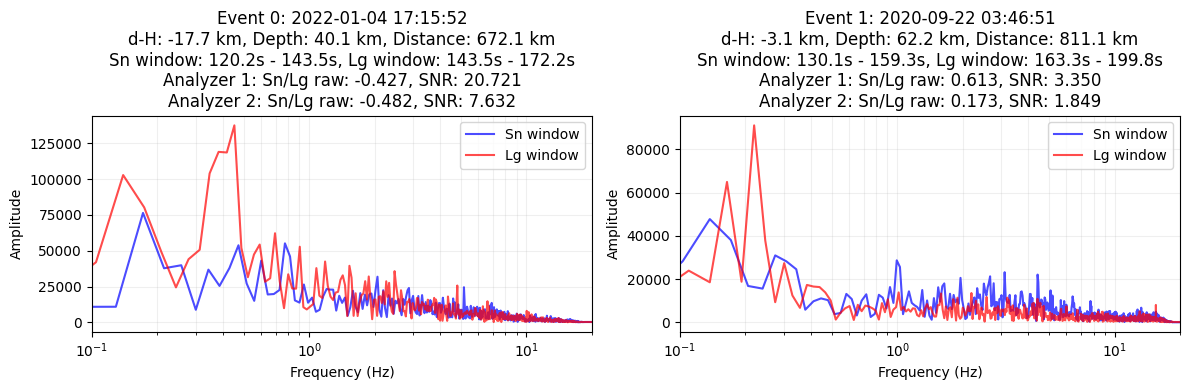

In [13]:
# User inputs
event_indices = [0, 1]  # Use [0, 1] etc. or 'all'
normalize = False  # Whether to normalize the spectra

# Convert event_indices to list if 'all' is specified
if event_indices == 'all':
    event_indices = range(len(results))
elif isinstance(event_indices, (int, float)):
    event_indices = [int(event_indices)]

# Calculate number of rows and columns for subplots
n_events = len(event_indices)
n_cols = min(3, n_events)  # Maximum 3 columns
n_rows = (n_events + n_cols - 1) // n_cols

# Create figure
fig = plt.figure(figsize=(6*n_cols, 4*n_rows))

for plot_idx, event_idx in enumerate(event_indices):
    if event_idx >= len(results):
        print(f"Warning: Event index {event_idx} is out of range. Skipping.")
        continue
        
    # Get event data
    event, stream, analyzer1_result, analyzer2_result, tsn, tlg, analyzer3_result, analyzer4_result = results[event_idx]
    
    # Make a copy of the stream to avoid modifying original
    work_stream = stream.copy()
    
    # Apply detrending and tapering (skip filtering)
    for tr in work_stream:
        tr.detrend("linear")
        tr.taper(max_percentage=0.05, type='hann')
        # tr.filter("bandpass", freqmin=one_sn_filt[0], freqmax=one_sn_filt[1], 
        #          corners=4, zerophase=True)
    
    # Rotate to RTZ
    work_stream.rotate(method='NE->RT', back_azimuth=analyzer1_result.baz)
    
    # Get components using channel selection
    try:
        # Try synthetic data format (BHZ, BHR, BHT)
        z_comp = work_stream.select(channel='BHZ')[0]
        r_comp = work_stream.select(channel='BHR')[0] 
        t_comp = work_stream.select(channel='BHT')[0]
        
        # Use T component
        t_data = t_comp.data  
    except IndexError:
        print(f"Warning: Missing components for event {event_idx}. Available channels: {[tr.stats.channel for tr in work_stream]}")
        continue
    
    # Get sampling parameters
    dt = z_comp.stats.delta  # sampling interval
    fs = 1/dt  # sampling frequency

    # Get p arrival for shift
    dist_m, _, _ = gps2dist_azimuth(event.event_lat, event.event_lon, stream[0].stats.sac.stla, stream[0].stats.sac.stlo)
    dist_km = dist_m / 1000.0
    dist_deg = kilometer2degrees(dist_km)
    arrivals = model.get_travel_times(source_depth_in_km=event.event_dep, distance_in_degree=dist_deg)
    p_arrival = [arrival for arrival in arrivals if arrival.name == 'P' or arrival.name == 'p'][0]
    
    # Get Sn and Lg windows from analyzer1
    sn_start = analyzer1_result.sn_window[0] - p_arrival.time + 60
    sn_end = analyzer1_result.sn_window[1] - p_arrival.time + 60
    lg_start = analyzer1_result.lg_window[0] - p_arrival.time + 60
    lg_end = analyzer1_result.lg_window[1] - p_arrival.time + 60
    
    # Extract windowed data
    sn_t = t_data[int(sn_start*fs):int(sn_end*fs)]
    lg_t = t_data[int(lg_start*fs):int(lg_end*fs)]
    
    # Calculate spectra
    sn_freq = nf.rfftfreq(len(sn_t), d=dt)
    lg_freq = nf.rfftfreq(len(lg_t), d=dt)
    sn_spec = np.abs(nf.rfft(sn_t))
    lg_spec = np.abs(nf.rfft(lg_t))
    
    # Normalize if requested
    if normalize:
        sn_spec = sn_spec / np.max(sn_spec)
        lg_spec = lg_spec / np.max(lg_spec)
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, plot_idx + 1)
    
    # Plot spectra with linear y-axis
    ax.semilogx(sn_freq, sn_spec, 'b-', label='Sn window', alpha=0.7)
    ax.semilogx(lg_freq, lg_spec, 'r-', label='Lg window', alpha=0.7)
    # # Plot spectra with log-log scale   
    # ax.loglog(sn_freq, sn_spec, 'b-', label='Sn window', alpha=0.7)
    # ax.loglog(lg_freq, lg_spec, 'r-', label='Lg window', alpha=0.7)

    # Add labels and title with distance and depth information
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Normalized Amplitude' if normalize else 'Amplitude')

    # Create title with event info, distance, and depth
    title = f'Event {event_idx}: {event.event_time.strftime("%Y-%m-%d %H:%M:%S")}\n'
    title += f'd-H: {event.d_h:.1f} km, Depth: {event.event_dep:.1f} km, Distance: {dist_km:.1f} km\n'
    title += f'Sn window: {sn_start:.1f}s - {sn_end:.1f}s, Lg window: {lg_start:.1f}s - {lg_end:.1f}s\n'
    title += f'Analyzer 1: Sn/Lg raw: {analyzer1_result.SnRLg_raw:.3f}, SNR: {analyzer1_result.SNR:.3f}\n'
    title += f'Analyzer 2: Sn/Lg raw: {analyzer2_result.SnRLg_raw:.3f}, SNR: {analyzer2_result.SNR:.3f}'
    ax.set_title(title)
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend()
    
    # Set reasonable frequency limits
    ax.set_xlim(0.1, fs/2)  # from 0.1 Hz to Nyquist frequency

# Adjust layout
plt.tight_layout()
plt.show()

## Calculate spectra (Z)

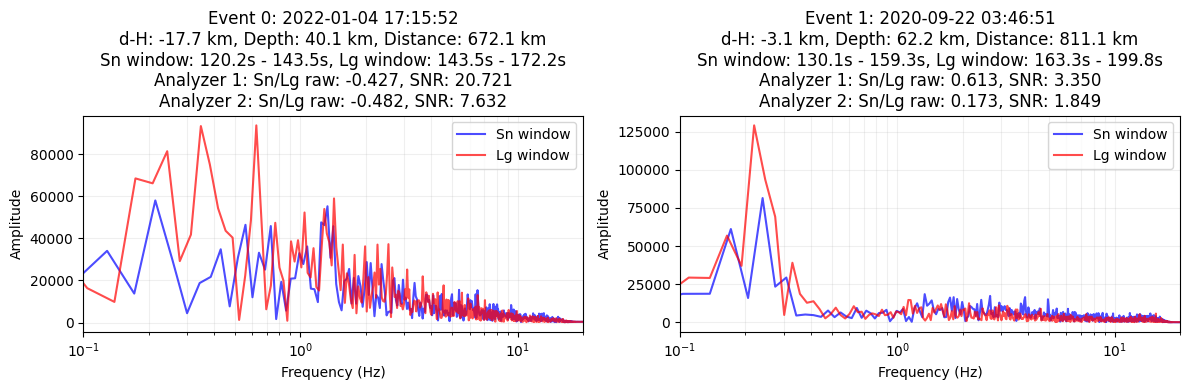

In [14]:
# User inputs
event_indices = [0, 1]  # Use [0, 1] etc. or 'all'
normalize = False  # Whether to normalize the spectra

# Convert event_indices to list if 'all' is specified
if event_indices == 'all':
    event_indices = range(len(results))
elif isinstance(event_indices, (int, float)):
    event_indices = [int(event_indices)]

# Calculate number of rows and columns for subplots
n_events = len(event_indices)
n_cols = min(3, n_events)  # Maximum 3 columns
n_rows = (n_events + n_cols - 1) // n_cols

# Create figure
fig = plt.figure(figsize=(6*n_cols, 4*n_rows))

for plot_idx, event_idx in enumerate(event_indices):
    if event_idx >= len(results):
        print(f"Warning: Event index {event_idx} is out of range. Skipping.")
        continue
        
    # Get event data
    event, stream, analyzer1_result, analyzer2_result, tsn, tlg, analyzer3_result, analyzer4_result = results[event_idx]
    
    # Make a copy of the stream to avoid modifying original
    work_stream = stream.copy()
    
    # Apply detrending and tapering (skip filtering)
    for tr in work_stream:
        tr.detrend("linear")
        tr.taper(max_percentage=0.05, type='hann')
        # tr.filter("bandpass", freqmin=one_sn_filt[0], freqmax=one_sn_filt[1], 
        #          corners=4, zerophase=True)
    
    # Rotate to RTZ
    work_stream.rotate(method='NE->RT', back_azimuth=analyzer1_result.baz)
    
    # Get components using channel selection
    try:
        # Try synthetic data format (BHZ, BHR, BHT)
        z_comp = work_stream.select(channel='BHZ')[0]
        r_comp = work_stream.select(channel='BHR')[0] 
        t_comp = work_stream.select(channel='BHT')[0]
        
        # Use Z component
        z_data = z_comp.data  
    except IndexError:
        print(f"Warning: Missing components for event {event_idx}. Available channels: {[tr.stats.channel for tr in work_stream]}")
        continue
    
    # Get sampling parameters
    dt = z_comp.stats.delta  # sampling interval
    fs = 1/dt  # sampling frequency

    # Get p arrival for shift
    dist_m, _, _ = gps2dist_azimuth(event.event_lat, event.event_lon, stream[0].stats.sac.stla, stream[0].stats.sac.stlo)
    dist_km = dist_m / 1000.0
    dist_deg = kilometer2degrees(dist_km)
    arrivals = model.get_travel_times(source_depth_in_km=event.event_dep, distance_in_degree=dist_deg)
    p_arrival = [arrival for arrival in arrivals if arrival.name == 'P' or arrival.name == 'p'][0]

    
    # Get Sn and Lg windows from analyzer1
    sn_start = analyzer1_result.sn_window[0] - p_arrival.time + 60
    sn_end = analyzer1_result.sn_window[1] - p_arrival.time + 60
    lg_start = analyzer1_result.lg_window[0] - p_arrival.time + 60
    lg_end = analyzer1_result.lg_window[1] - p_arrival.time + 60
    
    # Extract windowed data
    sn_z = z_data[int(sn_start*fs):int(sn_end*fs)]
    lg_z = z_data[int(lg_start*fs):int(lg_end*fs)]
    
    # Calculate spectra
    sn_freq = nf.rfftfreq(len(sn_z), d=dt)
    lg_freq = nf.rfftfreq(len(lg_z), d=dt)
    sn_spec = np.abs(nf.rfft(sn_z))
    lg_spec = np.abs(nf.rfft(lg_z))
    
    # Normalize if requested
    if normalize:
        sn_spec = sn_spec / np.max(sn_spec)
        lg_spec = lg_spec / np.max(lg_spec)
    
    # Create subplot
    ax = fig.add_subplot(n_rows, n_cols, plot_idx + 1)
    
    # Plot spectra with linear y-axis
    ax.semilogx(sn_freq, sn_spec, 'b-', label='Sn window', alpha=0.7)
    ax.semilogx(lg_freq, lg_spec, 'r-', label='Lg window', alpha=0.7)
    # # Plot spectra with log-log scale   
    # ax.loglog(sn_freq, sn_spec, 'b-', label='Sn window', alpha=0.7)
    # ax.loglog(lg_freq, lg_spec, 'r-', label='Lg window', alpha=0.7)

    # Add labels and title with distance and depth information
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Normalized Amplitude' if normalize else 'Amplitude')

    # Create title with event info, distance, and depth
    title = f'Event {event_idx}: {event.event_time.strftime("%Y-%m-%d %H:%M:%S")}\n'
    title += f'd-H: {event.d_h:.1f} km, Depth: {event.event_dep:.1f} km, Distance: {dist_km:.1f} km\n'
    title += f'Sn window: {sn_start:.1f}s - {sn_end:.1f}s, Lg window: {lg_start:.1f}s - {lg_end:.1f}s\n'
    title += f'Analyzer 1: Sn/Lg raw: {analyzer1_result.SnRLg_raw:.3f}, SNR: {analyzer1_result.SNR:.3f}\n'
    title += f'Analyzer 2: Sn/Lg raw: {analyzer2_result.SnRLg_raw:.3f}, SNR: {analyzer2_result.SNR:.3f}'
    ax.set_title(title)
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend()
    
    # Set reasonable frequency limits
    ax.set_xlim(0.1, fs/2)  # from 0.1 Hz to Nyquist frequency

# Adjust layout
plt.tight_layout()
plt.show()

# SYNTHETIC RESULTS

## Select events to run workflow on

In [15]:
# HOW TO CHOOSE INDICES: 
# 1. Open ?_Final_Selected.txt
# 2. Find the events you want (with focal mechanism solutions)
# 3. Find the index of the event in the file; subtract 1 to account for 0 indexing
# 4. Add the index to the list
# 5. Make sure indices are in descending order; SORT SOURCE MECHANISMS BY INCREASING DATE
event_indices = [65, 13, 6] 

observed_results = [results[i] for i in event_indices]
selected_events = [result[0] for result in observed_results]

print("Selected events:")
for i, event in enumerate(selected_events):
    print(f"Event {event_indices[i]} | Index {i}: {event}")

Selected events:
Event 65 | Index 0: Event(event_lat=35.74, event_lon=77.26, event_dep=89.9, event_time=UTCDateTime(2013, 10, 20, 19, 45, 7, 850000), event_mag=5.04, event_dperr=2.6, d_h=24.181233600000027, additional='*')
Event 13 | Index 1: Event(event_lat=35.74, event_lon=77.45, event_dep=118.1, event_time=UTCDateTime(2017, 12, 6, 23, 29, 3, 790000), event_mag=5.2, event_dperr=1.3, d_h=52.69043200000003, additional='*')
Event 6 | Index 2: Event(event_lat=32.92, event_lon=75.87, event_dep=30.1, event_time=UTCDateTime(2019, 9, 9, 6, 40, 33, 517000), event_mag=4.92, event_dperr=0.8, d_h=-24.68580000000007, additional='*')


## Set up synthetics

In [16]:
@dataclass
class SimulationConfig:
    """Configuration class for simulation parameters"""
    
    # KBL station coordinates, ignore variable naming ahhh
    lsa_lat = 34.541
    lsa_lon = 69.043

    # Calculate receiver distances and extract depths for selected events
    receiver_distances = []
    source_depths = []
    azimuths = []
    bazs = []
    event_times = []
    event_lats = []
    event_lons = []
    magnitudes = []
    for event in selected_events:
        distance, azimuth, back_azimuth = gps2dist_azimuth(
            event.event_lat, event.event_lon,  # Event coordinates
            lsa_lat, lsa_lon                  # KBL station coordinates
        )
        distance_km = distance / 1000
        receiver_distances.append(distance_km)
        source_depths.append(event.event_dep)
        azimuths.append(azimuth)
        bazs.append(back_azimuth)
        event_times.append(event.event_time)
        event_lats.append(event.event_lat)
        event_lons.append(event.event_lon)
        magnitudes.append(event.event_mag)
    receiver_distances = np.array(receiver_distances)
    source_depths = np.array(source_depths)
    
    # MODIFY: Source parameters 
    magnitude0 = 5.0 # 2013-10-20
    strike0 = 318
    dip0 = 22
    rake0 = 152
    azimuth0 = azimuths[0]
    baz0 = bazs[0]
    eventtime0 = event_times[0]

    magnitude1 = 5.2 # 2017-12-06
    strike1 = 332
    dip1 = 30
    rake1 = 120
    azimuth1 = azimuths[1]
    baz1 = bazs[1]
    eventtime1 = event_times[1]

    magnitude2 = 4.9 # 2011-09-18
    strike2 = 300
    dip2 = 35
    rake2 = 92
    azimuth2 = azimuths[2]
    baz2 = bazs[2]
    eventtime2 = event_times[2]

    # MODIFY: GF parameters
    npt = 4096
    dt = .1

    # MODIFY: STF parameters
    STF_duration = 4.2
    STF_rise = 0.1

    # Other parameters
    sync_origintime = UTCDateTime('2021-04-28T02:21:26.196000Z') # arbitrary
    sync_longitude = -122.168861 # arbitrary
    sync_latitude = 37.428230 # arbitrary

    # Model parameters
    layer1_thickness = 3.0
    layer1_vs = 3.3
    layer1_vp = 5.8
    layer1_rho = 2.3
    layer1_q1 = 50
    layer1_q2 = 100
    
    layer2_thickness = 37.0
    layer2_vs = 3.5
    layer2_vp = 5.8
    layer2_rho = 2.8
    layer2_q1 = 200
    layer2_q2 = 400
    
    layer3_thickness = 30.0
    layer3_vs = 4.0
    layer3_vp = 6.9
    layer3_rho = 3.0
    layer3_q1 = 200
    layer3_q2 = 400
    
    layer4_thickness = 500.0
    layer4_vs = 4.9
    layer4_vp = 8.6
    layer4_rho = 3.3
    layer4_q1 = 600
    layer4_q2 = 1200
    
    def get_mechanism0(self) -> List[float]:
        return [self.magnitude0, self.strike0, self.dip0, self.rake0]
    def get_mechanism1(self) -> List[float]:
        return [self.magnitude1, self.strike1, self.dip1, self.rake1]
    def get_mechanism2(self) -> List[float]:
        return [self.magnitude2, self.strike2, self.dip2, self.rake2]

    def get_model_data(self):
        return np.array([
            [self.layer1_thickness, self.layer1_vs, self.layer1_vp, self.layer1_rho, self.layer1_q1, self.layer1_q2],  # 0-3 km
            [self.layer2_thickness, self.layer2_vs, self.layer2_vp, self.layer2_rho, self.layer2_q1, self.layer2_q2],  # 3-40 km  
            [self.layer3_thickness, self.layer3_vs, self.layer3_vp, self.layer3_rho, self.layer3_q1, self.layer3_q2],  # 40-70 km
            [self.layer4_thickness, self.layer4_vs, self.layer4_vp, self.layer4_rho, self.layer4_q1, self.layer4_q2],  # >70 km (to 570 km)
        ])

# Create configuration instance
parameters = SimulationConfig()
print("Config created successfully!")
print("Source depths: ", parameters.source_depths)
print("Receiver distances: ", parameters.receiver_distances)

# Create seismic model
model_data = parameters.get_model_data()
FKmodel = SeisModel(model=model_data, flattening = False)

# Create sources array
def setup_source(parameters, i):
    """Setup a source at a given depth (i) with rotating mechanisms 0-4"""
    mech_idx = i % len(parameters.source_depths)
    mech = getattr(parameters, f"get_mechanism{mech_idx}")()
    source = SourceModel(
        sdep=parameters.source_depths[i],
        srcType="dc",
        source_mechanism=mech
    )
    print(f"Source {i} (mechanism{mech_idx}):", source)
    return source
print("Creating sources array...")
sources = []
for i in range(len(parameters.source_depths)):
    source = setup_source(parameters, i)
    sources.append(source)

# Create configs array
def setup_config(model, sources, parameters, i):
    """Setup configuration object for a given source; with error handling"""
    dist_idx = i % len(parameters.receiver_distances)
    dist = parameters.receiver_distances[dist_idx]
    config_obj = Config(
        model=FKmodel,
        source=sources[i],
        npt=parameters.npt,
        dt=parameters.dt,
        receiver_distance=[dist]
    )
    print(f"Config {i}:", config_obj)
    return config_obj
print("Creating configs array...")
configs = []
for i in range(len(sources)):
    config_obj= setup_config(model, sources, parameters, i)
    configs.append(config_obj)

Config created successfully!
Source depths:  [ 89.9 118.1  30.1]
Receiver distances:  [760.31038674 777.34860122 657.58829945]
Creating sources array...
Source 0 (mechanism0): SourceModel(sdep=89.9, srcType=dc, source_mechanism=[  5. 318.  22. 152.])
Source 1 (mechanism1): SourceModel(sdep=118.1, srcType=dc, source_mechanism=[  5.2 332.   30.  120. ])
Source 2 (mechanism2): SourceModel(sdep=30.1, srcType=dc, source_mechanism=[  4.9 300.   35.   92. ])
Creating configs array...
Config 0: Config(model=SeisModel(layers=5, flattening=False), source=SourceModel(sdep=89.9, srcType=dc, source_mechanism=[  5. 318.  22. 152.]), receiver_distance=[760.31038674], taper=0.3, filter=(0, 0), npt=4096, dt=0.1, dk=0.3, smth=1.0, pmin=0.0, pmax=1.0, kmax=15.0, rdep=0.0, updn=all, samples_before_first_arrival=50, suppression_sigma=2.0)
Config 1: Config(model=SeisModel(layers=5, flattening=False), source=SourceModel(sdep=118.1, srcType=dc, source_mechanism=[  5.2 332.   30.  120. ]), receiver_distance=[7

## Green's functions

In [17]:
def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each depth is saved in a separate folder.
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    N = len(gfs) # Number of depths
    for i in range(N):
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each depth
        gf_w = gfs[i] # Streams for given depth, one for each receiver distance
        for j in range(len(gf_w)): # Loop over stream for given depth and receiver distance
            gf_w[j].write(path + '/' + str(i).zfill(2) + "/grn_" + str(j).zfill(3) + "_.sac", format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns a nested list of obspy Stream objects.
    """
    GF = []
    dirs = glob.glob(path + '/*')
    dirs.sort()
    for dir in dirs:
        GFn = []
        files = glob.glob(dir + '/*_01.sac')
        files.sort()
        for file in files:
            # Read all matching SAC files for this Green's function
            stream = obspy.read(file[:-5] + '*')
            GFn.append(stream)
        GF.append(GFn)
    return GF

# # ----------------------------- COMMENT OUT OR IN
# gfs = []

# for i in range(len(configs)):
#     config = configs[i]
#     gf = calculate_gf(config)
#     gfs.append(gf)
#     print('Calculated Green\'s function for source depth: ' + str(int(parameters.source_depths[i])).zfill(3) + 'km')

# # Folder Obs_gfs, subfolder 01, file grn_001_06 indicates 2nd depth (01, 0 index), 2nd receiver (001, 0 index), 6th trace (06, 1 index)
# saveGF(gfs_name, gfs)
# # -----------------------------

gfs = readGF(gfs_name)

print("----------------Structure of gfs----------------")
print("gfs is an array; length equal to # of depths: \n", (gfs))
print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

----------------Structure of gfs----------------
gfs is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x30d99d610>], [<obspy.core.stream.Stream object at 0x30ce56d60>], [<obspy.core.stream.Stream object at 0x30dae2cd0>]]
gfs[0] are the streams for 1st depth; length equal to # of receivers: 
gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: 
 9 Trace(s) in Stream:
... | 1970-01-01T00:01:31.129089Z - 1970-01-01T00:08:20.629089Z | 10.0 Hz, 4096 samples
... | 1970-01-01T00:01:31.129089Z - 1970-01-01T00:08:20.629089Z | 10.0 Hz, 4096 samples
... | 1970-01-01T00:01:31.129089Z - 1970-01-01T00:08:20.629089Z | 10.0 Hz, 4096 samples
... | 1970-01-01T00:01:31.129089Z - 1970-01-01T00:08:20.629089Z | 10.0 Hz, 4096 samples
... | 1970-01-01T00:01:31.129089Z - 1970-01-01T00:08:20.629089Z | 10.0 Hz, 4096 samples
... | 1970-01-01T00:01:31.129089Z - 1970-01-01T00:08:20.629089Z | 10.0 Hz, 4096 samples
... | 1970-01-01T00:01:31.129089Z - 1970-01-01

## STF

Trapezoidal source time function generated.
Frequencies above 10% max: 0.23 to 4.65 Hz


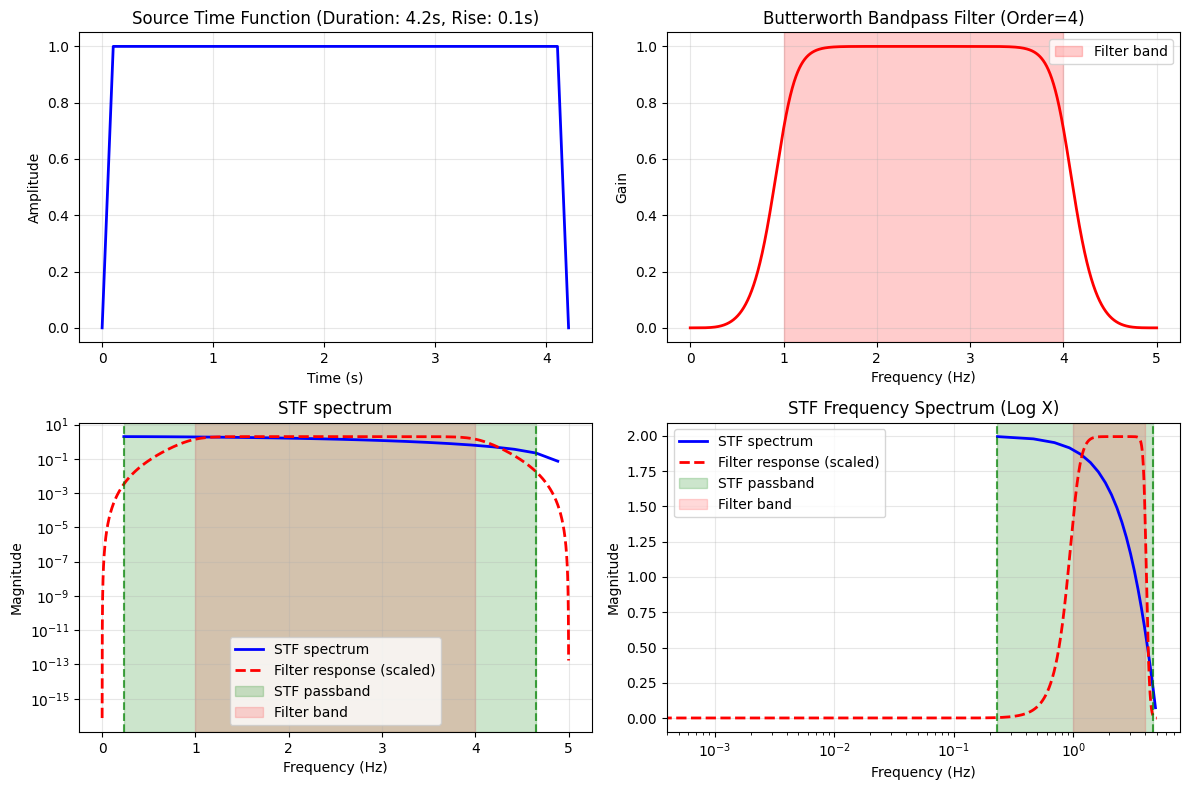

STF duration: 4.2 seconds
STF passband: 0.23-4.65 Hz
Filter band: 1-4 Hz


In [18]:
# ------ Parameters
delta = parameters.dt
dura = parameters.STF_duration
rise = parameters.STF_rise

def generate_trapezoidal_source_time_function(
        total_duration: float = 4.2,
        rise_time: float = 0.1,
        base_time: float = 4.0,
        delta: float = 0.1) -> Trace:
    """
    Generate a trapezoidal source time function.
    """
    # Validate inputs
    if 2 * rise_time + base_time > total_duration:
        raise ValueError("2*rise_time + base_time cannot exceed total_duration")
    
    # Calculate number of points
    ns = int(total_duration / delta)
    nr = int(rise_time / delta)  # points for rise
    nb = int(base_time / delta)  # points for base
    
    # Create time array
    t = np.arange(0, total_duration + delta, delta)
    
    # Initialize STF array
    stf = np.zeros_like(t)
    
    # Ramp up (0 to 1)
    if nr > 0:
        stf[:nr] = np.linspace(0, 1, nr)
    
    # Flat top (constant = 1)
    if nb > 0:
        stf[nr:nr+nb] = 1.0
    
    # Ramp down (1 to 0)
    if nr > 0:
        stf[nr+nb:nr+nb+nr] = np.linspace(1, 0, nr)
    
    # Normalize
    stf = stf / np.max(stf)
    
    # Create ObsPy Trace
    result_trace = Trace(header={}, data=stf)
    result_trace.stats.delta = delta
    
    return result_trace
source_time_function = generate_trapezoidal_source_time_function(total_duration=dura, rise_time=rise, base_time=dura-2*rise, delta=delta)
print("Trapezoidal source time function generated.")

# ----------------- Plot source time function below
# TOGGLE: Filter parameters
freqmin = 1
freqmax = 4
corners = 4

# Calculate frequency spectrum
n = len(source_time_function)  # Get the number of points in the STF
freq = np.fft.rfftfreq(n, delta)       # Create frequency axis from -Nyquist to +Nyquist (Hz)
fft_stf = np.fft.rfft(source_time_function)  # Convert STF from time domain to frequency domain
magnitude = np.abs(fft_stf)    # Get the amplitude (magnitude) at each frequency

# Frequency domain: get positive frequencies and their magnitudes
positive_freq_mask = freq > 0  # Create mask for positive frequencies only
freq_pos = freq[positive_freq_mask]
mag_pos = magnitude[positive_freq_mask]

# ------Find cutoff frequencies
max_amp = np.max(mag_pos)
threshold = 0.1 * max_amp

# Find all indices where magnitude is above threshold
above_10_mask = mag_pos >= threshold
if np.any(above_10_mask):
    # Get all frequencies above threshold
    freqs_above = freq_pos[above_10_mask]
    print(f"Frequencies above 10% max: {freqs_above[0]:.2f} to {freqs_above[-1]:.2f} Hz")
    # Set low and high cutoff
    low_cutoff_freq = freqs_above[0]
    high_cutoff_freq = freqs_above[-1]
else:
    print("WARNING: No frequencies above 10% of max amplitude.")
    low_cutoff_freq = None
    high_cutoff_freq = None

# ------Plot filter, STF and frequency spectrum for both
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]  # Top left
ax2 = axes[0, 1]  # Top right
ax3 = axes[1, 0]  # Bottom left
ax4 = axes[1, 1]  # Bottom right

# ---Time domain
time_stf = np.arange(len(source_time_function)) * delta  # Create time axis (seconds)
ax1.plot(time_stf, source_time_function, 'b-', linewidth=2)  # Plot STF in time domain
ax1.set_title(f'Source Time Function (Duration: {dura}s, Rise: {rise}s)')  # Set title with parameters
ax1.set_xlabel('Time (s)')     # Label x-axis
ax1.set_ylabel('Amplitude')    # Label y-axis
ax1.grid(True, alpha=0.3)      # Add grid with transparency

# ---Filter parameters (from parameters)
fs = 1.0 / delta  # Sampling frequency
# Design Butterworth bandpass filter
nyq = 0.5 * fs  # Calculate the Nyquist frequency (half the sampling rate)
low = freqmin / nyq  # Normalize the lower cutoff frequency (as a fraction of Nyquist)
high = freqmax / nyq  # Normalize the upper cutoff frequency (as a fraction of Nyquist)
b, a = butter(corners, [low, high], btype='band')  
# Design a Butterworth bandpass filter of order 'corners' with normalized cutoff frequencies.
# 'b' and 'a' are the filter coefficients for the numerator and denominator, respectively.
w, h = freqz(b, a, worN=8000)  
# Compute the frequency response of the filter.
# 'w' is an array of frequencies (in radians/sample), 'h' is the complex frequency response.
f = w * fs / (2 * np.pi)  
# Convert the frequency array 'w' from radians/sample to Hz for plotting.
# Plotting
ax2.plot(f, abs(h), 'r', linewidth=2)
ax2.set_title(f'Butterworth Bandpass Filter (Order={corners})')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Gain')
ax2.grid(True, alpha=0.3)
ax2.axvspan(freqmin, freqmax, color='red', alpha=0.2, label='Filter band')
ax2.legend()

# ---Frequency domain (log y-axis)
ax3.semilogy(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax3.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax3.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax3.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax3.set_title('STF spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.grid(True, alpha=0.3)
ax3.legend()

# ---Frequency domain (log x-axis)
ax4.semilogx(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax4.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax4.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax4.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax4.set_title('STF Frequency Spectrum (Log X)')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"STF duration: {dura} seconds")
print(f"STF passband: {low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz")
print(f"Filter band: {freqmin}-{freqmax} Hz")

## Generate synthetics

In [19]:
sync_results = []
for i in range(len(gfs)): # loop over depths
    sync_result = calculate_sync(gfs[i], configs[i], parameters.azimuths[i], source_time_function) # calculate sync for given depth, all receivers
    sync_results.append(sync_result)
    print(f"Calculated synthetic seismograms for depth {i}: {sync_result}")

for i in range(len(sync_results)):
    for j in range(len(sync_results[i])):
        selected_sync = sync_results[i][j] # stream for given depth (i) and receiver distance (j)
        # Assign channel codes to synthetic traces (Z, R, T components)
        channel_codes = ['BHZ', 'BHR', 'BHT'] 
        for k, tr in enumerate(selected_sync):
            tr.stats.channel = channel_codes[k]
        # Set synthetic trace starttime to first data point
        for tr in selected_sync:
            tr.stats.starttime = parameters.event_times[i] + tr.stats.sac.b

            # # USE BELOW CODE TO CONFIRM 50 * .1 = 5 seconds of padding
            # import matplotlib.dates as mdates
            # x = tr.times("matplotlib")  # absolute times in days
            # fig, ax = plt.subplots()
            # ax.plot_date(x, tr.data, "-", lw=0.8)
            # ax.axvline(tr.stats.starttime.matplotlib_date + 5/86400.0, color="r", ls="--", lw=1)
            # ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            # ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
            # ax.set_xlabel("Time (UTC)")
            # ax.set_ylabel("Amplitude")
            # fig.autofmt_xdate()
            # plt.show()

print("----------------Structure of sync_results----------------")
print("sync_results is an array; length equal to # of depths: \n", sync_results)
print("sync_results[0] are the streams for 1st depth; length equal to # of receivers: \n", sync_results[0])
print("sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: \n", sync_results[0][0]) 

Calculated synthetic seismograms for depth 0: [<obspy.core.stream.Stream object at 0x30dcee820>]
Calculated synthetic seismograms for depth 1: [<obspy.core.stream.Stream object at 0x303bd4250>]
Calculated synthetic seismograms for depth 2: [<obspy.core.stream.Stream object at 0x303bd43d0>]
----------------Structure of sync_results----------------
sync_results is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x30dcee820>], [<obspy.core.stream.Stream object at 0x303bd4250>], [<obspy.core.stream.Stream object at 0x303bd43d0>]]
sync_results[0] are the streams for 1st depth; length equal to # of receivers: 
sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: 
 3 Trace(s) in Stream:
...BHZ | 2013-10-20T19:46:38.979089Z - 2013-10-20T19:53:28.479089Z | 10.0 Hz, 4096 samples
...BHR | 2013-10-20T19:46:38.979089Z - 2013-10-20T19:53:28.479089Z | 10.0 Hz, 4096 samples
...BHT | 2013-10-20T19:46:38.979089Z - 2013-10-20T19:53

## Run SnLg on synthetics

In [20]:
synthetic_results = []

# --- 1. Prepare synthetic waveforms ---
sync_SnLg = copy.deepcopy(sync_results)
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):
        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        selected_sync.rotate('RT->NE', back_azimuth=parameters.bazs[i]) # rotate to ZNE

# --- BEGIN CALCULATING SnLg FOR ALL WAVEFORMS AT THIS POINT ---
synthetic_results = []
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):

        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        depth = parameters.source_depths[i]
        receiver_distance = parameters.receiver_distances[j]

        # --- 2. Prepare event data ---
        Event = namedtuple('Event', ['event_lat', 'event_lon', 'event_dep', 'event_time', 'event_mag'])
        event = Event(
            event_lat=parameters.event_lats[i],
            event_lon=parameters.event_lons[i],
            event_dep=depth,
            event_time=parameters.event_times[i],
            event_mag=parameters.magnitudes[i]
        )

        # --- 3. Calculate other required parameters ---
        gcarc = kilometer2degrees(receiver_distance)
        arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=gcarc, phase_list=['p', 'P'])
        p_arrival = event.event_time + arrivals[0].time if arrivals else None

        # --- 4. Create the SnLg_Analyses objects ---
        snlg_analyzer_synthetic1 = SnLg_Analyses(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=one_vsm,
            vsc=one_vsc,
            moho=one_moho,
            sn_filt=(one_sn_filt[0], one_sn_filt[1]),
            lg_filt=(one_lg_filt[0], one_lg_filt[1])
        )
        snlg_analyzer_synthetic1.snlg_onepair = SnLg_OneEventStationPair(
            event=event,
            station=None,
        )

        snlg_analyzer_synthetic2 = SnLg_Analyses(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=two_vsm,
            vsc=two_vsc,
            moho=two_moho,
            sn_filt=(two_sn_filt[0], two_sn_filt[1]),
            lg_filt=(two_lg_filt[0], two_lg_filt[1])
        )
        snlg_analyzer_synthetic2.snlg_onepair = SnLg_OneEventStationPair(
            event=event,
            station=None,
        )

        snlg_analyzer_synthetic3 = SnLg_Analyses_Z(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=one_vsm,
            vsc=one_vsc,
            moho=one_moho,
            sn_filt=(one_sn_filt[0], one_sn_filt[1]),
            lg_filt=(one_lg_filt[0], one_lg_filt[1])
        )
        snlg_analyzer_synthetic3.snlg_onepair = SnLg_OneEventStationPair_Z(
            event=event,
            station=None,
        )

        snlg_analyzer_synthetic4 = SnLg_Analyses_Z(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=two_vsm,
            vsc=two_vsc,
            moho=two_moho,
            sn_filt=(two_sn_filt[0], two_sn_filt[1]),
            lg_filt=(two_lg_filt[0], two_lg_filt[1])
        )
        snlg_analyzer_synthetic4.snlg_onepair = SnLg_OneEventStationPair_Z(
            event=event,
            station=None,
        )

        # --- 5. Run the analysis on synthetic stream ---
        snlg_analyzer_synthetic1.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.bazs[i])
        snlg_analyzer_synthetic2.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.bazs[i])
        snlg_analyzer_synthetic3.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.bazs[i])
        snlg_analyzer_synthetic4.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.bazs[i])

        # --- 7. Get the results from synthetic stream ---
        print("---------Stats for depth", depth, "and receiver distance", receiver_distance, "---------")
        print("ONE: Sn/Lg raw:", snlg_analyzer_synthetic1.snlg_onepair.SnRLg_raw)
        print("TWO: Sn/Lg raw:", snlg_analyzer_synthetic2.snlg_onepair.SnRLg_raw)
        print("THREE: Sn/Lg raw:", snlg_analyzer_synthetic3.snlg_onepair.SnRLg_raw)
        print("FOUR: Sn/Lg raw:", snlg_analyzer_synthetic4.snlg_onepair.SnRLg_raw)

        # --- 8. Get theoretical SnLg arrival times ---
        def snlg_arrival(d, H, g, vsm, vsc):
            '''
            d: depth
            H: Moho depth
            g: receiver distance
            vsm: velocity of s in mantle
            vsc: velocity of s in crust
            '''
            if d > H:
                t = Symbol('t')
                tn = solve(-(g - t)/sp.sqrt((g-t)**2 + H**2)/vsc + t/sp.sqrt(t**2 + (d - H)**2) / vsm, t)
                if tn[0] > 0:
                    tn = tn[0]
                else:
                    tn = tn[1]
                    print('Warning: Solving something strange')
                tn = float(tn)
                tsn = np.sqrt((g-tn)**2 + H**2) / vsc + np.sqrt(tn**2 + (d - H)**2) / vsm
                tlg = (d - H)/vsm + np.sqrt(H**2 + g**2)/ vsc
            else:
                tsn = g / vsm + (2*H - d) * np.sqrt(vsm**2 - vsc**2) / vsm / vsc
                tlg = np.sqrt(d**2 + g**2)/vsc
            return tsn, tlg
        tsn, tlg = snlg_arrival(depth, one_moho, receiver_distance, one_vsm, one_vsc)

        # --- 9. Save the results as a tuple ---
        synthetic_result = [event, sync_results[i][j], snlg_analyzer_synthetic1.snlg_onepair, snlg_analyzer_synthetic2.snlg_onepair, tsn, tlg, snlg_analyzer_synthetic3.snlg_onepair, snlg_analyzer_synthetic4.snlg_onepair]
        synthetic_results.append(synthetic_result)

/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------Stats for depth 89.9 and receiver distance 760.3103867431001 ---------
ONE: Sn/Lg raw: -0.20730720837369632
TWO: Sn/Lg raw: -0.12415828137165816
THREE: Sn/Lg raw: -0.4951013175630263
FOUR: Sn/Lg raw: -0.602298367646058
---------Stats for depth 118.1 and receiver distance 760.3103867431001 ---------
ONE: Sn/Lg raw: 1.082317110834528
TWO: Sn/Lg raw: 0.9993114031708757
THREE: Sn/Lg raw: 0.6718176093691768
FOUR: Sn/Lg raw: 0.7566343378504473
---------Stats for depth 30.1 and receiver distance 760.3103867431001 ---------
ONE: Sn/Lg raw: -1.9831387737543231
TWO: Sn/Lg raw: -0.5201444765058464
THREE: Sn/Lg raw: -1.867783451597058
FOUR: Sn/Lg raw: -0.7296480358602286


# Analysis 3

## Compare waveforms

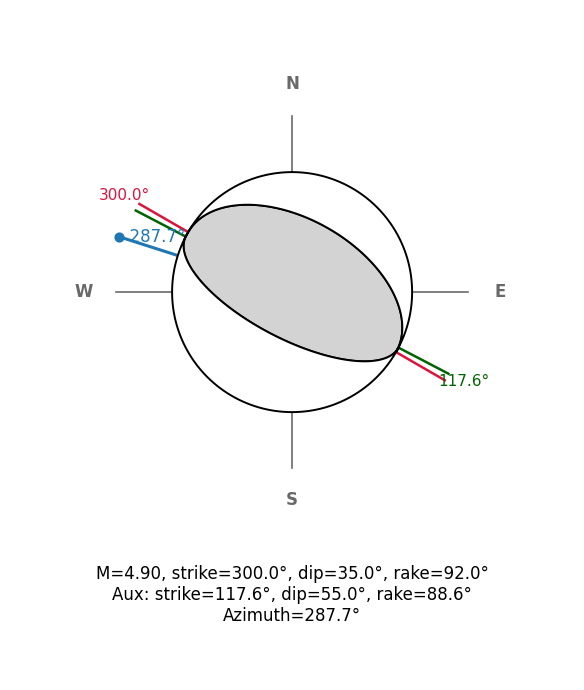

In [21]:
def plot_focal_mechanism(index: int, parameters, azimuths, width: float = 240.0, figsize=(7, 7)):
	"""
	Beachball with 4 rays aligned to the two focal planes' strikes (surface traces),
	N/E/S/W lines and labels, angle labels for the two planes, parameter label, and azimuth marker.
	"""

	getter_name = f"get_mechanism{index}"
	if not hasattr(parameters, getter_name):
		raise AttributeError(f"`parameters` is missing {getter_name}()")

	Mw, strike, dip, rake = getattr(parameters, getter_name)()
	strike2, dip2, rake2 = aux_plane(strike, dip, rake)
	az = float(azimuths[index])

	fig, ax = plt.subplots(figsize=figsize)
	ax.set_aspect("equal")
	ax.axis("off")

	center = (0.0, 0.0)
	r = width / 2.0

	# Beachball
	ball = beach(
		[strike, dip, rake],
		xy=center,
		width=width,
		linewidth=1.4,
		facecolor="lightgray",
		edgecolor="k",
		axes=ax
	)
	ax.add_collection(ball)

	# Rays along the two nodal planes' strikes
	def draw_ray(ang_deg: float, color: str):
		theta = np.deg2rad(90.0 - ang_deg)
		x = center[0] + r * np.cos(theta)
		y = center[1] + r * np.sin(theta)
		ax.plot([center[0], x], [center[1], y], color=color, lw=1.8, zorder=15)

	to360 = lambda a: (a % 360.0 + 360.0) % 360.0
	angles_np1 = [to360(strike), to360(strike + 180.0)]
	angles_np2 = [to360(strike2), to360(strike2 + 180.0)]

	for a in angles_np1:
		draw_ray(a, color="crimson")
	for a in angles_np2:
		draw_ray(a, color="darkgreen")

	# NESW lines
	cardinals = [(0.0, "N"), (90.0, "E"), (180.0, "S"), (270.0, "W")]
	for ang_deg, _ in cardinals:
		theta = np.deg2rad(90.0 - ang_deg)
		x = center[0] + r * np.cos(theta)
		y = center[1] + r * np.sin(theta)
		ax.plot([center[0], x], [center[1], y], color="dimgray", lw=1.2, zorder=12)

	# Label planes by strike (primary direction only)
	for ang_deg, color in [(angles_np1[0], "crimson"), (angles_np2[0], "darkgreen")]:
		theta = np.deg2rad(90.0 - ang_deg)
		xl = center[0] + 1.10 * r * np.cos(theta)
		yl = center[1] + 1.10 * r * np.sin(theta)
		ax.text(xl, yl, f"{ang_deg:.1f}°", ha="center", va="center", fontsize=11, color=color, zorder=20)

	# NESW labels
	for ang_deg, lab in cardinals:
		theta = np.deg2rad(90.0 - ang_deg)
		xm = center[0] + 1.18 * r * np.cos(theta)
		ym = center[1] + 1.18 * r * np.sin(theta)
		ax.text(xm, ym, lab, ha="center", va="center", fontsize=12, color="dimgray", fontweight="bold", zorder=40)

	# Mark azimuth
	theta_az = np.deg2rad(90.0 - az)
	x_end = center[0] + 1.03 * r * np.cos(theta_az)
	y_end = center[1] + 1.03 * r * np.sin(theta_az)
	ax.plot([center[0], x_end], [center[1], y_end], color="tab:blue", lw=2.2, zorder=30)
	ax.scatter([x_end], [y_end], color="tab:blue", s=40, zorder=31)
	ax.text(x_end, y_end, f"  {az:.1f}°", ha="left", va="center", fontsize=12, color="tab:blue", zorder=31)

	# Parameters label
	param_label = (
		f"M={Mw:.2f}, strike={strike:.1f}°, dip={dip:.1f}°, rake={rake:.1f}°\n"
		f"Aux: strike={strike2:.1f}°, dip={dip2:.1f}°, rake={rake2:.1f}°\n"
		f"Azimuth={az:.1f}°"
	)
	ax.text(0.0, -(r * 1.55), param_label, ha="center", va="top", fontsize=12)

	# Limits
	margin = r * 0.60
	ax.set_xlim(-r - margin, r + margin)
	ax.set_ylim(-r - margin * 2.0, r + margin)

	plt.tight_layout()
	plt.show()

idx = 2
plot_focal_mechanism(idx, parameters, parameters.azimuths)

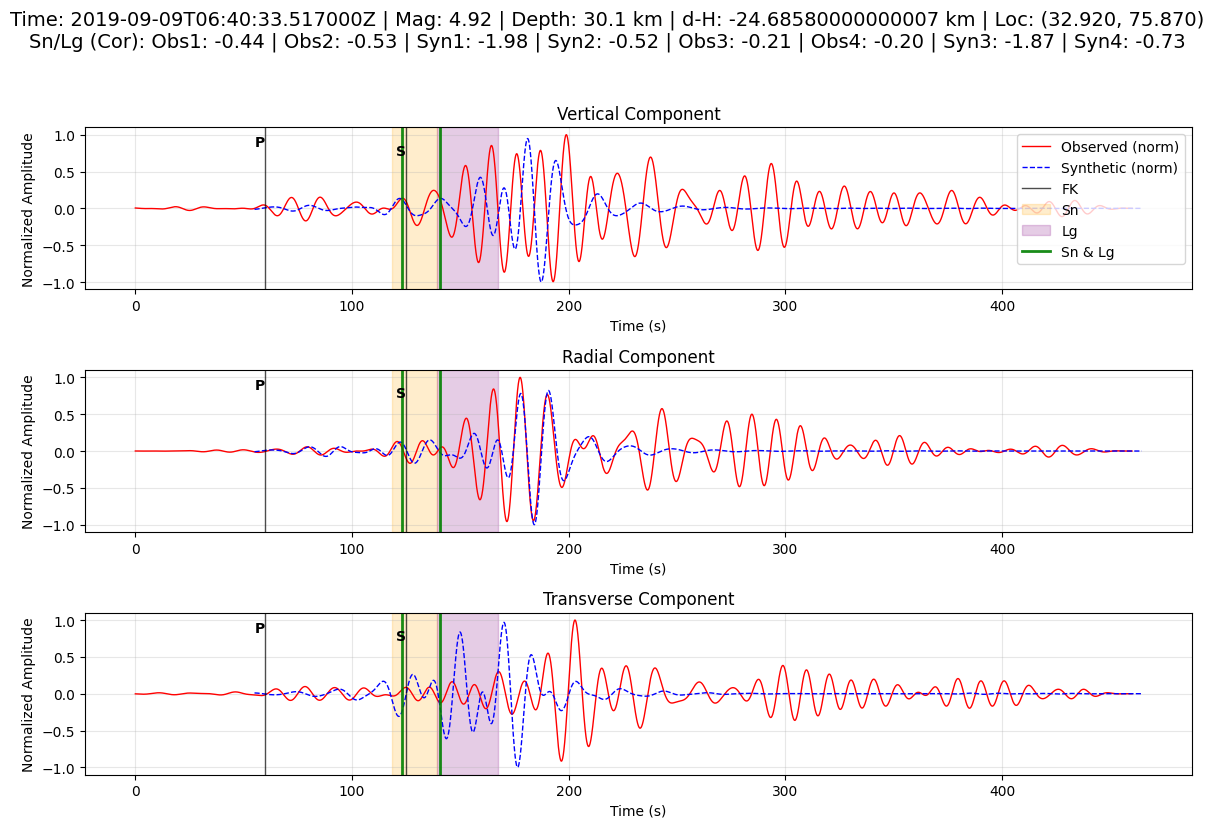

In [22]:
# TOGGLE
plot_freqmin = 0.05
plot_freqmax = 0.1

# Unpack the selected observed and synthetic results
obs_event, obs_stream_raw, obs_pair1, obs_pair2, obs_tsn, obs_tlg, obs_pair3, obs_pair4 = observed_results[idx]
syn_event, syn_stream_raw, syn_pair1, syn_pair2, syn_tsn, syn_tlg, syn_pair3, syn_pair4 = synthetic_results[idx]

# Prepare streams
obs_stream = obs_stream_raw.copy()
syn_stream = syn_stream_raw.copy()

# Time axes; set observed to start at 0, synthetic shift by 
t_obs = np.arange(len(obs_stream[0].data)) * obs_stream[0].stats.delta
t_syn = np.arange(len(syn_stream[0].data)) * syn_stream[0].stats.delta - 50 * parameters.dt + 60

# Rotate and clean appropriately
obs_stream.rotate(method='NE->RT', back_azimuth=obs_pair1.baz) # Rotate observed to RTZ
z_trace1 = obs_stream.select(channel='BHZ')[0] if obs_stream.select(channel='BHZ') else None
r_trace1 = obs_stream.select(channel='BHR')[0] if obs_stream.select(channel='BHR') else None
t_trace1 = obs_stream.select(channel='BHT')[0] if obs_stream.select(channel='BHT') else None
ordered_stream = Stream()
if z_trace1:
    ordered_stream.append(z_trace1)
if r_trace1:
    ordered_stream.append(r_trace1)
if t_trace1:
    ordered_stream.append(t_trace1)
obs_stream.clear()
for tr in ordered_stream:
    obs_stream.append(tr)
for tr in obs_stream: # Process observed stream with filter parameters
    tr.detrend("linear")
    tr.taper(max_percentage=0.05, type='hann')
    tr.filter("bandpass", freqmin=plot_freqmin, freqmax=plot_freqmax, 
                corners=4, zerophase=True)
for tr in syn_stream: # Process synthetic stream with filter parameters
    tr.detrend("linear")
    tr.taper(max_percentage=0.05, type='hann')
    tr.filter("bandpass", freqmin=plot_freqmin, freqmax=plot_freqmax, 
                corners=4, zerophase=True)

# Component names for display
component_names = ['Vertical', 'Radial', 'Transverse']

# Extract Sn/Lg windows from observed analyzer 1 (assumed same for syn/obs and both analyzers)
sn_window = getattr(obs_pair1, 'sn_window', None)
lg_window = getattr(obs_pair1, 'lg_window', None)

# Extract SnRLg_raw values
obs_cor1 = getattr(obs_pair1, 'SnRLg_raw', np.nan)
obs_cor2 = getattr(obs_pair2, 'SnRLg_raw', np.nan)
syn_cor1 = getattr(syn_pair1, 'SnRLg_raw', np.nan)
syn_cor2 = getattr(syn_pair2, 'SnRLg_raw', np.nan)
obs_cor3 = getattr(obs_pair3, 'SnRLg_raw', np.nan)
obs_cor4 = getattr(obs_pair4, 'SnRLg_raw', np.nan)
syn_cor3 = getattr(syn_pair3, 'SnRLg_raw', np.nan)
syn_cor4 = getattr(syn_pair4, 'SnRLg_raw', np.nan)

# Event info (use observed event)
evt_time = getattr(obs_event, 'event_time', None)
evt_dep  = getattr(obs_event, 'event_dep', None)
evt_mag  = getattr(obs_event, 'event_mag', getattr(obs_event, 'magnitude', None))
evt_lat  = getattr(obs_event, 'event_lat', getattr(obs_event, 'latitude', None))
evt_lon  = getattr(obs_event, 'event_lon', getattr(obs_event, 'longitude', None))
evt_d_h  = getattr(obs_event, 'd_h', None)

# Build title
title_info = []
if evt_time is not None: title_info.append(f"Time: {evt_time}")
if evt_mag  is not None: title_info.append(f"Mag: {evt_mag}")
if evt_dep  is not None: title_info.append(f"Depth: {evt_dep} km")
if evt_d_h  is not None: title_info.append(f"d-H: {evt_d_h} km")
if evt_lat is not None and evt_lon is not None: title_info.append(f"Loc: ({evt_lat:.3f}, {evt_lon:.3f})")
title_event = " | ".join(title_info) if title_info else "Event info"
title_cor = f"Obs1: {obs_cor1:.2f} | Obs2: {obs_cor2:.2f} | Syn1: {syn_cor1:.2f} | Syn2: {syn_cor2:.2f} | Obs3: {obs_cor3:.2f} | Obs4: {obs_cor4:.2f} | Syn3: {syn_cor3:.2f} | Syn4: {syn_cor4:.2f}"

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle(f"{title_event}\nSn/Lg (Cor): {title_cor}", fontsize=14, y=1.03)

for i in range(3):
    ax = axes[i]
    obs_trace = obs_stream[i]
    syn_trace = syn_stream[i]

    # Normalization (per-trace max abs)
    def norm(x):
        m = np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else 1.0
        return x / m
    observed_norm  = norm(obs_trace.data)
    synthetic_norm = norm(syn_trace.data)

    # Plot observed and synthetic
    ax.plot(t_obs, observed_norm, 'r-', linewidth=1, label='Observed (norm)')
    ax.plot(t_syn, synthetic_norm, 'b--', linewidth=1, label='Synthetic (norm)')

    # CRITICAL: SHIFT BY -SAC.T1 + 60 DUE TO 0 ALIGINING WITH BEGINNING OF OBSERVED DATA, WHICH CORRESPONDS TO 60 SECONDS BEFORE P ARRIVAL
    # P/S arrivals from synthetic SAC header
    if hasattr(syn_trace.stats, 'sac'):
        sac = syn_trace.stats.sac
        if hasattr(sac, 't1') and sac.t1 != -12345:
            ax.axvline(x=sac.t1 - sac.t1 + 60, color='black', linestyle='-', linewidth=1, alpha=0.7, label='FK')
            ax.text(sac.t1 - sac.t1 + 60, ax.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold',
                    ha='right', va='top')
        if hasattr(sac, 't2') and sac.t2 != -12345:
            ax.axvline(x=sac.t2 - sac.t1 + 60, color='black', linestyle='-', linewidth=1, alpha=0.7)
            ax.text(sac.t2 - sac.t1 + 60, ax.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                    ha='right', va='top')
    
    # Shade Sn/Lg windows (from observed analyzer 1)
    if sn_window is not None:
        sn_start, sn_end = sn_window
        ax.axvspan(sn_start - sac.t1 + 60, sn_end - sac.t1 + 60, color='orange', alpha=0.2, label='Sn')
    if lg_window is not None:
        lg_start, lg_end = lg_window
        ax.axvspan(lg_start - sac.t1 + 60, lg_end - sac.t1 + 60, color='purple', alpha=0.2, label='Lg')

    # tsn & tlg (use observed values)
    if obs_tsn is not None:
        ax.axvline(x=obs_tsn - sac.t1 + 60, color='green', linestyle='-', linewidth=2, alpha=0.9, label='Sn & Lg')
    if obs_tlg is not None:
        ax.axvline(x=obs_tlg - sac.t1 + 60, color='green', linestyle='-', linewidth=2, alpha=0.9)

    # Axis labels and legend
    names = component_names[i] if i < len(component_names) else f"Comp {i}"
    ax.set_title(f'{names} Component')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude')
    ax.grid(True, alpha=0.3)

    # Only show legend once (top subplot), but add handles to that legend
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        # Deduplicate labels
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), loc='upper right')
    
    # ax.set_xlim(100, 225)

plt.tight_layout()
plt.show()

## Compare Sn/Lg ratios

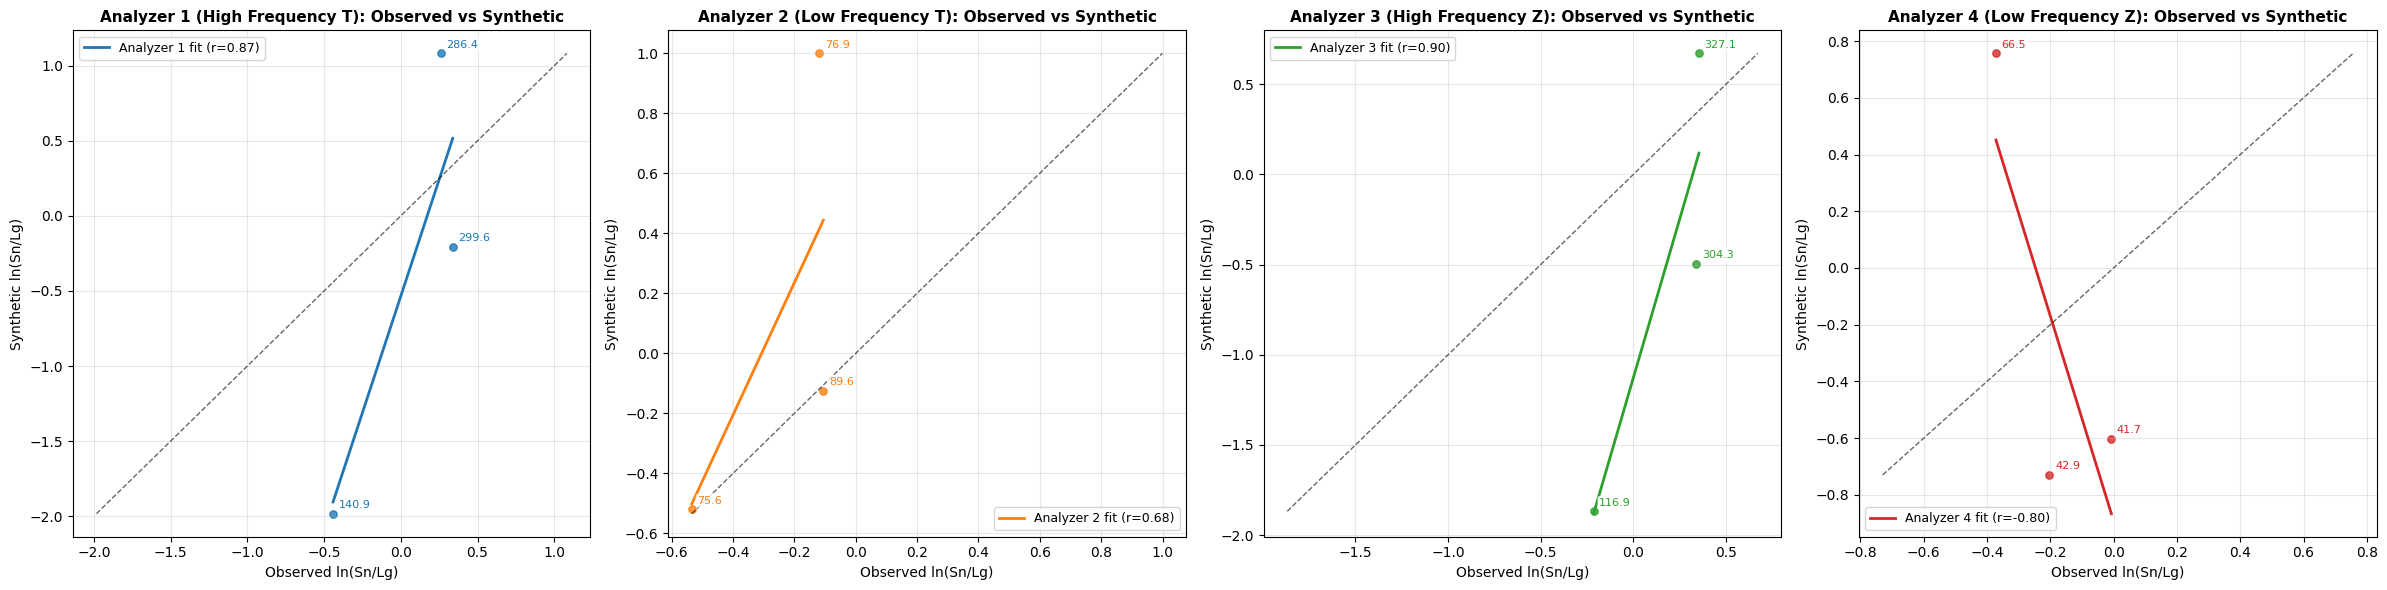

Analyzer 1: n=3, slope=3.105, intercept=-0.534, r=0.867
Analyzer 2: n=3, slope=2.204, intercept=0.676, r=0.681
Analyzer 3: n=3, slope=3.517, intercept=-1.129, r=0.898
Analyzer 4: n=3, slope=-3.614, intercept=-0.892, r=-0.800


In [23]:
# Collect paired values per analyzer
x_obs = {1: [], 2: [], 3: [], 4: []}
y_syn = {1: [], 2: [], 3: [], 4: []}
labels_snr_obs = {1: [], 2: [], 3: [], 4: []}

n_items = min(len(observed_results), len(synthetic_results))
for idx in range(n_items):
	try:
		# Unpack tuples: (event, stream_raw, pair1, pair2, tsn, tlg, pair3, pair4)
		obs_event, _, obs_pair1, obs_pair2, _, _, obs_pair3, obs_pair4 = observed_results[idx]
		_, _, syn_pair1, syn_pair2, _, _, syn_pair3, syn_pair4 = synthetic_results[idx]
		pairs = {1: (obs_pair1, syn_pair1), 2: (obs_pair2, syn_pair2), 3: (obs_pair3, syn_pair3), 4: (obs_pair4, syn_pair4)}
	except Exception:
		continue

	for k in (1, 2, 3, 4):
		obs_pair, syn_pair = pairs[k]
		if obs_pair is None or syn_pair is None:
			continue
		xv = getattr(obs_pair, "SnRLg_raw", None)
		yv = getattr(syn_pair, "SnRLg_raw", None)
		if xv is None or yv is None:
			continue
		if np.isfinite(xv) and np.isfinite(yv):
			x_obs[k].append(xv)
			y_syn[k].append(yv)
			obs_snr = getattr(obs_pair, "SNR", np.nan)
			labels_snr_obs[k].append(obs_snr)

# Convert to numpy arrays
for k in (1, 2, 3, 4):
	x_obs[k] = np.array(x_obs[k], dtype=float)
	y_syn[k] = np.array(y_syn[k], dtype=float)
	labels_snr_obs[k] = np.array(labels_snr_obs[k], dtype=float)

# Plotting (1x4 row)
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
ax_map = {1: axes[0], 2: axes[1], 3: axes[2], 4: axes[3]}
colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green', 4: 'tab:red'}
titles = {
	1: 'Analyzer 1 (High Frequency T): Observed vs Synthetic',
	2: 'Analyzer 2 (Low Frequency T): Observed vs Synthetic',
	3: 'Analyzer 3 (High Frequency Z): Observed vs Synthetic',
	4: 'Analyzer 4 (Low Frequency Z): Observed vs Synthetic',
}

def fit_and_plot(ax, x, y, color, label_prefix):
	if x.size >= 2 and y.size >= 2:
		m, b = np.polyfit(x, y, 1)
		r = np.corrcoef(x, y)[0, 1]
		xs = np.linspace(x.min(), x.max(), 100)
		ax.plot(xs, m*xs + b, color=color, linewidth=2, label=f'{label_prefix} fit (r={r:.2f})')
		return m, b, r
	return np.nan, np.nan, np.nan

stats = {}
for k in (1, 2, 3, 4):
	ax = ax_map[k]
	x = x_obs[k]
	y = y_syn[k]
	col = colors[k]

	ax.scatter(x, y, s=28, color=col, alpha=0.8)
	# Annotate with observed SNR only
	for xv, yv, snr_o in zip(x, y, labels_snr_obs[k]):
		if np.isfinite(snr_o):
			ax.annotate(f'{snr_o:.1f}',
			            (xv, yv), xytext=(4, 4), textcoords='offset points',
			            fontsize=8, color=col,
			            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.8))

	# Fit line
	m, b, r = fit_and_plot(ax, x, y, col, f'Analyzer {k}')
	stats[k] = dict(n=int(x.size), m=m, b=b, r=r)

	# Diagonal
	if x.size and y.size:
		xlims = (np.nanmin(x), np.nanmax(x))
		ylims = (np.nanmin(y), np.nanmax(y))
		lo = min(xlims[0], ylims[0]); hi = max(xlims[1], ylims[1])
		ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.6, linewidth=1)

	ax.set_xlabel('Observed ln(Sn/Lg)')
	ax.set_ylabel('Synthetic ln(Sn/Lg)')
	ax.set_title(titles[k], fontsize=11, fontweight='bold')
	ax.grid(True, alpha=0.3)
	ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

# Print stats summary
for k in (1, 2, 3, 4):
	s = stats[k]
	print(f'Analyzer {k}: n={s["n"]}, slope={s["m"]:.3f}, intercept={s["b"]:.3f}, r={s["r"]:.3f}')

## Calculate spectra (T, synthetic)

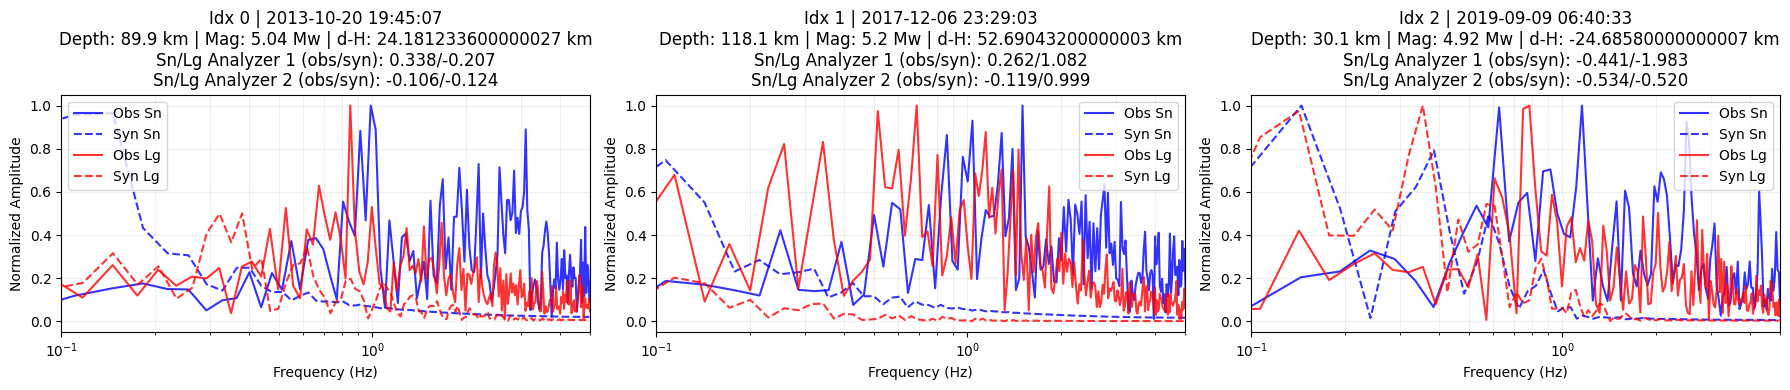

In [24]:
# Set whether to normalize spectra, basically have to (bc synthetic is low amplitude)
normalize = True

# Prepare plotting grid
n_events = min(len(observed_results), len(synthetic_results))
if n_events == 0:
	print("No results to plot.")
else:
	n_cols = min(3, n_events)
	n_rows = (n_events + n_cols - 1) // n_cols
	fig = plt.figure(figsize=(6*n_cols, 4*n_rows))

	for plot_idx in range(n_events):
		# Unpack tuples: (event, stream_raw, pair1, pair2, tsn, tlg)
		try:
			obs_event, obs_stream_raw, obs_pair1, obs_pair2, obs_tsn, obs_tlg, obs_pair3, obs_pair4 = observed_results[plot_idx]
			syn_event, syn_stream_raw, syn_pair1, syn_pair2, syn_tsn, syn_tlg, syn_pair3, syn_pair4 = synthetic_results[plot_idx]
		except Exception as e:
			print(f"Skipping index {plot_idx}: cannot unpack results ({e})")
			continue

		# Use analyzer 1 windows
		if obs_pair1 is None or obs_pair1.sn_window is None or obs_pair1.lg_window is None:
			print(f"Skipping index {plot_idx}: missing windows in analyzer 1 observed result")
			continue

		# Get p arrival for shift
		dist_m, _, _ = gps2dist_azimuth(event.event_lat, event.event_lon, stream[0].stats.sac.stla, stream[0].stats.sac.stlo)
		dist_km = dist_m / 1000.0
		dist_deg = kilometer2degrees(dist_km)
		arrivals = model.get_travel_times(source_depth_in_km=event.event_dep, distance_in_degree=dist_deg)
		p_arrival = [arrival for arrival in arrivals if arrival.name == 'P' or arrival.name == 'p'][0]

		sn_start, sn_end = obs_pair1.sn_window[0] - p_arrival.time + 60, obs_pair1.sn_window[1] - p_arrival.time + 60
		lg_start, lg_end = obs_pair1.lg_window[0] - p_arrival.time + 60, obs_pair1.lg_window[1] - p_arrival.time + 60
		baz = getattr(obs_pair1, "baz", None)

		# Helper to get T component array after detrend, taper, rotate
		def get_t_component_data(stream, baz):
			ws = stream.copy()
			for tr in ws:
				tr.detrend("linear")
				tr.taper(max_percentage=0.05, type="hann")
			try:
				if baz is not None:
					ws.rotate(method="NE->RT", back_azimuth=baz)
			except Exception as e:
				print(f"Warning: rotation failed at index {plot_idx}: {e}")
			try:
				z_comp = ws.select(channel="BHZ")[0]
				r_comp = ws.select(channel="BHR")[0]
				t_comp = ws.select(channel="BHT")[0]
				return t_comp.data.astype(float), z_comp.stats.delta
			except IndexError:
				# Fall back to horizontal as-is if rotation didn't produce R/T
				try:
					t_comp = ws.select(channel="BHT")[0]
					z_comp = ws.select(channel="BHZ")[0]
					return t_comp.data.astype(float), z_comp.stats.delta
				except IndexError:
					print(f"Warning: Missing components at index {plot_idx}. Available: {[tr.stats.channel for tr in ws]}")
					return None, None

		obs_t_data, obs_dt = get_t_component_data(obs_stream_raw, baz)
		syn_t_data, syn_dt = get_t_component_data(syn_stream_raw, baz)

		if obs_t_data is None or syn_t_data is None:
			continue

		# Sampling rates
		obs_fs = 1.0 / obs_dt
		syn_fs = 1.0 / syn_dt

		# Extract windowed data
		def slice_window(arr, fs, t0, t1):
			i0 = max(0, int(t0 * fs))
			i1 = min(len(arr), int(t1 * fs))
			return arr[i0:i1] if i1 > i0 else np.array([])

		obs_sn = slice_window(obs_t_data, obs_fs, sn_start, sn_end)
		obs_lg = slice_window(obs_t_data, obs_fs, lg_start, lg_end)
		syn_sn = slice_window(syn_t_data, syn_fs, sn_start, sn_end)
		syn_lg = slice_window(syn_t_data, syn_fs, lg_start, lg_end)

		# Skip if any window is empty
		if any(x.size == 0 for x in [obs_sn, obs_lg, syn_sn, syn_lg]):
			print(f"Skipping index {plot_idx}: empty window(s)")
			continue

		# Compute spectra
		obs_sn_freq = nf.rfftfreq(len(obs_sn), d=obs_dt)
		obs_lg_freq = nf.rfftfreq(len(obs_lg), d=obs_dt)
		syn_sn_freq = nf.rfftfreq(len(syn_sn), d=syn_dt)
		syn_lg_freq = nf.rfftfreq(len(syn_lg), d=syn_dt)

		obs_sn_spec = np.abs(nf.rfft(obs_sn))
		obs_lg_spec = np.abs(nf.rfft(obs_lg))
		syn_sn_spec = np.abs(nf.rfft(syn_sn))
		syn_lg_spec = np.abs(nf.rfft(syn_lg))

		if normalize:
			def nz_norm(x): 
				m = np.max(x) if x.size else 1.0
				return x / (m if m != 0 else 1.0)
			obs_sn_spec = nz_norm(obs_sn_spec)
			obs_lg_spec = nz_norm(obs_lg_spec)
			syn_sn_spec = nz_norm(syn_sn_spec)
			syn_lg_spec = nz_norm(syn_lg_spec)

		# Plot
		ax = fig.add_subplot(n_rows, n_cols, plot_idx + 1)
		ax.semilogx(obs_sn_freq, obs_sn_spec, 'b-', alpha=0.8, label='Obs Sn')
		ax.semilogx(syn_sn_freq, syn_sn_spec, 'b--', alpha=0.8, label='Syn Sn')
		ax.semilogx(obs_lg_freq, obs_lg_spec, 'r-', alpha=0.8, label='Obs Lg')
		ax.semilogx(syn_lg_freq, syn_lg_spec, 'r--', alpha=0.8, label='Syn Lg')

		ax.set_xlabel('Frequency (Hz)')
		ax.set_ylabel('Normalized Amplitude' if normalize else 'Amplitude')

		# Title with quick context
		try:
			title = f'Idx {plot_idx}'
			title += f' | {obs_event.event_time.strftime("%Y-%m-%d %H:%M:%S")}'
			title += f'\nDepth: {obs_event.event_dep} km | Mag: {obs_event.event_mag} Mw | d-H: {obs_event.d_h} km'
			title += f'\nSn/Lg Analyzer 1 (obs/syn): {getattr(obs_pair1, "SnRLg_raw", np.nan):.3f}/{getattr(syn_pair1, "SnRLg_raw", np.nan):.3f}'
			title += f'\nSn/Lg Analyzer 2 (obs/syn): {getattr(obs_pair2, "SnRLg_raw", np.nan):.3f}/{getattr(syn_pair2, "SnRLg_raw", np.nan):.3f}'
			ax.set_title(title)
		except Exception as e:
			print(f"Error setting title at index {plot_idx}: {e}")

		ax.grid(True, which="both", ls="-", alpha=0.2)
		ax.legend()

		# X-limits: from 0.1 Hz up to min Nyquist across obs/syn
		x_max = min(obs_fs, syn_fs) / 2.0
		ax.set_xlim(0.1, max(0.11, x_max))

	plt.tight_layout()
	plt.show()

## Calculate spectra (Z, synthetic)

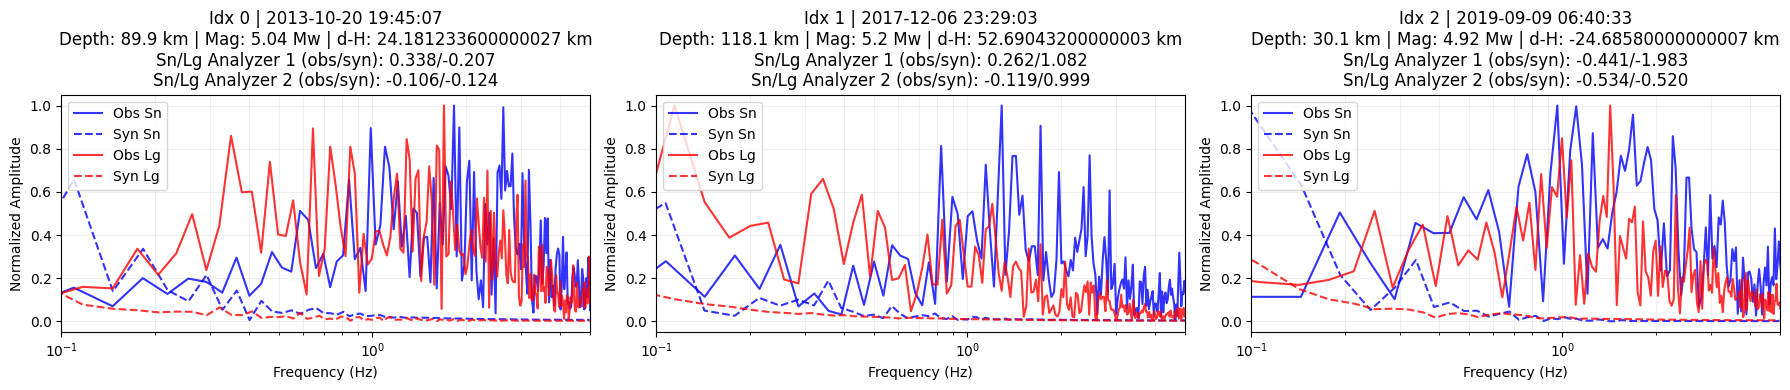

In [25]:
# Set whether to normalize spectra, basically have to (bc synthetic is low amplitude)
normalize = True

# Prepare plotting grid
n_events = min(len(observed_results), len(synthetic_results))
if n_events == 0:
	print("No results to plot.")
else:
	n_cols = min(3, n_events)
	n_rows = (n_events + n_cols - 1) // n_cols
	fig = plt.figure(figsize=(6*n_cols, 4*n_rows))

	for plot_idx in range(n_events):
		# Unpack tuples: (event, stream_raw, pair1, pair2, tsn, tlg)
		try:
			obs_event, obs_stream_raw, obs_pair1, obs_pair2, obs_tsn, obs_tlg, obs_pair3, obs_pair4 = observed_results[plot_idx]
			syn_event, syn_stream_raw, syn_pair1, syn_pair2, syn_tsn, syn_tlg, syn_pair3, syn_pair4 = synthetic_results[plot_idx]
		except Exception as e:
			print(f"Skipping index {plot_idx}: cannot unpack results ({e})")
			continue

		# Use analyzer 1 windows
		if obs_pair1 is None or obs_pair1.sn_window is None or obs_pair1.lg_window is None:
			print(f"Skipping index {plot_idx}: missing windows in analyzer 1 observed result")
			continue

		# Get p arrival for shift
		dist_m, _, _ = gps2dist_azimuth(event.event_lat, event.event_lon, stream[0].stats.sac.stla, stream[0].stats.sac.stlo)
		dist_km = dist_m / 1000.0
		dist_deg = kilometer2degrees(dist_km)
		arrivals = model.get_travel_times(source_depth_in_km=event.event_dep, distance_in_degree=dist_deg)
		p_arrival = [arrival for arrival in arrivals if arrival.name == 'P' or arrival.name == 'p'][0]

		sn_start, sn_end = obs_pair1.sn_window[0] - p_arrival.time + 60, obs_pair1.sn_window[1] - p_arrival.time + 60
		lg_start, lg_end = obs_pair1.lg_window[0] - p_arrival.time + 60, obs_pair1.lg_window[1] - p_arrival.time + 60
		baz = getattr(obs_pair1, "baz", None)

		# Helper to get T component array after detrend, taper, rotate
		def get_z_component_data(stream, baz):
			ws = stream.copy()
			for tr in ws:
				tr.detrend("linear")
				tr.taper(max_percentage=0.05, type="hann")
			try:
				if baz is not None:
					ws.rotate(method="NE->RT", back_azimuth=baz)
			except Exception as e:
				print(f"Warning: rotation failed at index {plot_idx}: {e}")
			try:
				z_comp = ws.select(channel="BHZ")[0]
				r_comp = ws.select(channel="BHR")[0]
				t_comp = ws.select(channel="BHT")[0]
				return z_comp.data.astype(float), z_comp.stats.delta
			except IndexError:
				# Fall back to horizontal as-is if rotation didn't produce R/T
				try:
					z_comp = ws.select(channel="BHZ")[0]
					return z_comp.data.astype(float), z_comp.stats.delta
				except IndexError:
					print(f"Warning: Missing components at index {plot_idx}. Available: {[tr.stats.channel for tr in ws]}")
					return None, None

		obs_z_data, obs_dt = get_z_component_data(obs_stream_raw, baz)
		syn_z_data, syn_dt = get_z_component_data(syn_stream_raw, baz)

		if obs_z_data is None or syn_z_data is None:
			continue

		# Sampling rates
		obs_fs = 1.0 / obs_dt
		syn_fs = 1.0 / syn_dt

		# Extract windowed data
		def slice_window(arr, fs, t0, t1):
			i0 = max(0, int(t0 * fs))
			i1 = min(len(arr), int(t1 * fs))
			return arr[i0:i1] if i1 > i0 else np.array([])

		obs_sn = slice_window(obs_z_data, obs_fs, sn_start, sn_end)
		obs_lg = slice_window(obs_z_data, obs_fs, lg_start, lg_end)
		syn_sn = slice_window(syn_z_data, syn_fs, sn_start, sn_end)
		syn_lg = slice_window(syn_z_data, syn_fs, lg_start, lg_end)

		# Skip if any window is empty
		if any(x.size == 0 for x in [obs_sn, obs_lg, syn_sn, syn_lg]):
			print(f"Skipping index {plot_idx}: empty window(s)")
			continue

		# Compute spectra
		obs_sn_freq = nf.rfftfreq(len(obs_sn), d=obs_dt)
		obs_lg_freq = nf.rfftfreq(len(obs_lg), d=obs_dt)
		syn_sn_freq = nf.rfftfreq(len(syn_sn), d=syn_dt)
		syn_lg_freq = nf.rfftfreq(len(syn_lg), d=syn_dt)

		obs_sn_spec = np.abs(nf.rfft(obs_sn))
		obs_lg_spec = np.abs(nf.rfft(obs_lg))
		syn_sn_spec = np.abs(nf.rfft(syn_sn))
		syn_lg_spec = np.abs(nf.rfft(syn_lg))

		if normalize:
			def nz_norm(x): 
				m = np.max(x) if x.size else 1.0
				return x / (m if m != 0 else 1.0)
			obs_sn_spec = nz_norm(obs_sn_spec)
			obs_lg_spec = nz_norm(obs_lg_spec)
			syn_sn_spec = nz_norm(syn_sn_spec)
			syn_lg_spec = nz_norm(syn_lg_spec)

		# Plot
		ax = fig.add_subplot(n_rows, n_cols, plot_idx + 1)
		ax.semilogx(obs_sn_freq, obs_sn_spec, 'b-', alpha=0.8, label='Obs Sn')
		ax.semilogx(syn_sn_freq, syn_sn_spec, 'b--', alpha=0.8, label='Syn Sn')
		ax.semilogx(obs_lg_freq, obs_lg_spec, 'r-', alpha=0.8, label='Obs Lg')
		ax.semilogx(syn_lg_freq, syn_lg_spec, 'r--', alpha=0.8, label='Syn Lg')

		ax.set_xlabel('Frequency (Hz)')
		ax.set_ylabel('Normalized Amplitude' if normalize else 'Amplitude')

		# Title with quick context
		try:
			title = f'Idx {plot_idx}'
			title += f' | {obs_event.event_time.strftime("%Y-%m-%d %H:%M:%S")}'
			title += f'\nDepth: {obs_event.event_dep} km | Mag: {obs_event.event_mag} Mw | d-H: {obs_event.d_h} km'
			title += f'\nSn/Lg Analyzer 1 (obs/syn): {getattr(obs_pair1, "SnRLg_raw", np.nan):.3f}/{getattr(syn_pair1, "SnRLg_raw", np.nan):.3f}'
			title += f'\nSn/Lg Analyzer 2 (obs/syn): {getattr(obs_pair2, "SnRLg_raw", np.nan):.3f}/{getattr(syn_pair2, "SnRLg_raw", np.nan):.3f}'
			ax.set_title(title)
		except Exception as e:
			print(f"Error setting title at index {plot_idx}: {e}")

		ax.grid(True, which="both", ls="-", alpha=0.2)
		ax.legend()

		# X-limits: from 0.1 Hz up to min Nyquist across obs/syn
		x_max = min(obs_fs, syn_fs) / 2.0
		ax.set_xlim(0.1, max(0.11, x_max))

	plt.tight_layout()
	plt.show()

# Figures

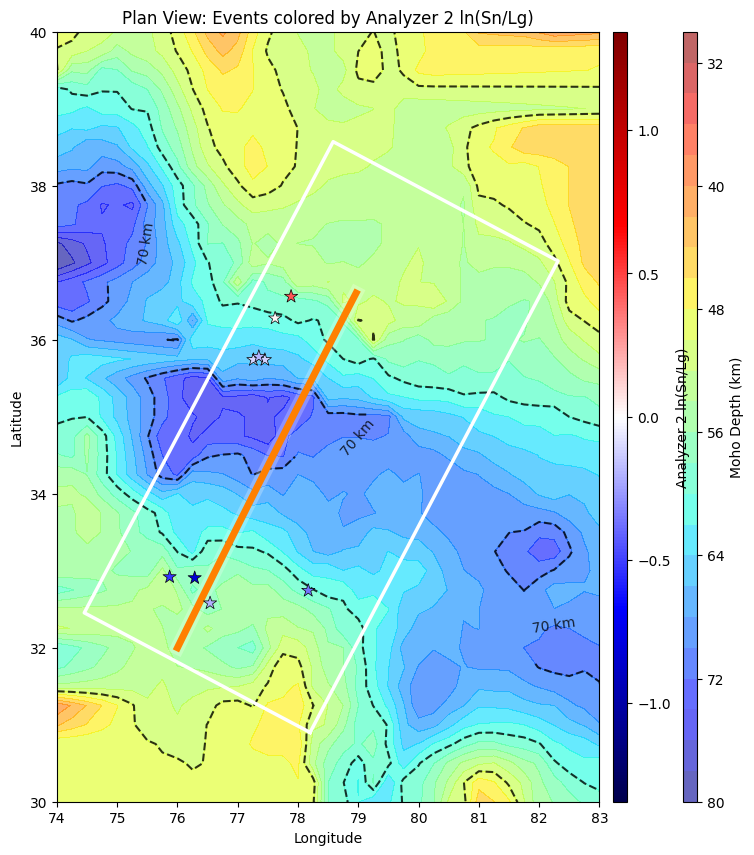

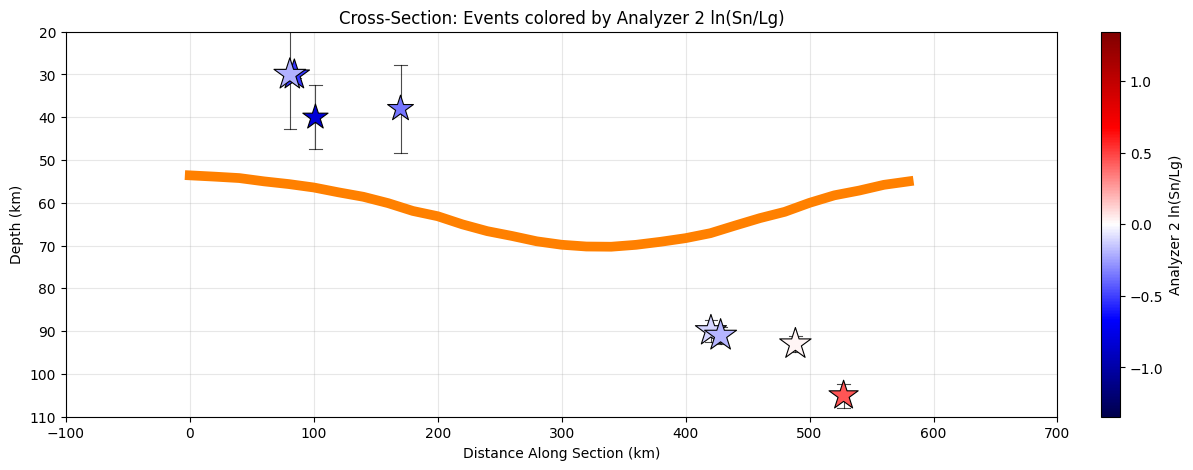

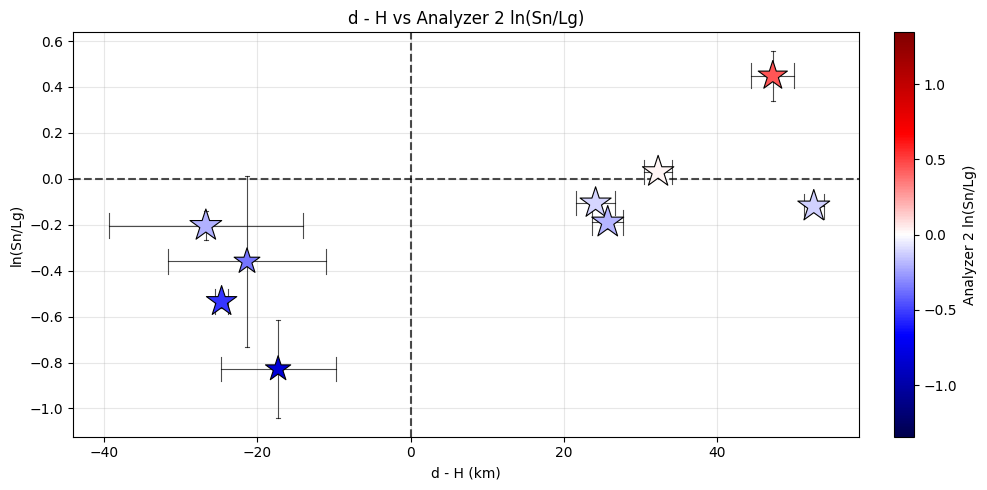

In [26]:
# ========= USER INPUTS/TOGGLES =========

# Toggle which analyzer’s raw ln(Sn/Lg) to color events by (1, 2, 3, or 4)
selected_analyzer = 2

# Toggle to only plot starred events on both plots
plot_starred_only = True

# Toggle for SNR filter options (choose at most one)
plot_snr_overall_only = False     # True => only plot events where overall SNR > snr_overall_threshold
snr_overall_threshold = snlg_SNR_threshold
plot_snr_both_bands_only = False  # True => only plot events where BOTH Sn and Lg SNR > snr_both_threshold
snr_both_threshold = snlg_SNR_threshold_2
if plot_snr_overall_only and plot_snr_both_bands_only:
    raise ValueError("Enable at most one SNR option: overall-only OR both-bands-only.")

# Toggle to plot error bars
plot_error_bars = True

# Cross-section definition
start_lon, start_lat = 76.0, 32.0     # section start (deg)
azimuth_deg = 28.0                   # section azimuth (deg, clockwise from North)
num_points = 30                       # number of sample points
step_km = 20.0                        # spacing of sample points (km)

# Elliptical averaging for Moho sampling along section (uniform weights)
ellipse_a_km = 100.0                  # semi-major (km) along azimuth
ellipse_b_km = 200.0                  # semi-minor (km) across azimuth

# Map extent for the plan-view plot
map_xlim = (74, 83)                   # (min lon, max lon)
map_ylim = (30, 40)                   # (min lat, max lat)

# Station marker and optional label
station_lon, station_lat = 69.043, 34.541
add_station_label = False
station_label = "KBL"

# Study region rectangle
anchor_lon, anchor_lat = 78.2, 30.9   # anchor
wd_km = 780.0                         # width (km)
lt_km = 380.0                         # length (km)
bearing_rad = 28.0 * np.pi / 180.0     # 4 degrees in radians

# Path to gridded Moho file (lon, lat, depth[km])
MOHO_FILE = "/Users/emmanuelzheng/Downloads/Synthetics/Xiaohan/Moho_RF_int.txt"

# ========= 1) LOAD MOHO GRID =========
moho_lon, moho_lat, moho_depth = [], [], []
with open(MOHO_FILE, "r") as f:
    for ln in f:
        parts = ln.strip().split()
        if len(parts) < 3:
            continue
        try:
            lo = float(parts[0]); la = float(parts[1]); de = float(parts[2])
        except ValueError:
            continue
        moho_lon.append(lo); moho_lat.append(la); moho_depth.append(de)

moho_lon = np.array(moho_lon)
moho_lat = np.array(moho_lat)
moho_depth = np.array(moho_depth)

x_unique = np.unique(moho_lon)            # lon axis
y_unique = np.unique(moho_lat)            # lat axis
nx, ny = x_unique.size, y_unique.size

# grid depth array, shape (ny, nx) => y (lat) is first axis
z_grid = np.full((ny, nx), np.nan, dtype=float)
lon_to_i = {val: i for i, val in enumerate(x_unique)}
lat_to_j = {val: j for j, val in enumerate(y_unique)}
for lo, la, de in zip(moho_lon, moho_lat, moho_depth):
    i = lon_to_i.get(lo, None); j = lat_to_j.get(la, None)
    if i is None or j is None:
        continue
    z_grid[j, i] = 40.0 if de >= 10000 else de

xm, ym = np.meshgrid(x_unique, y_unique)

# ========= 2) EXTRACT EVENTS + SELECTED ANALYZER VALUES FROM `results` =========
# results: [eventStore, stream, pair1, pair2, tsn, tlg, pair3, pair4]
pair_index_by_analyzer = {1: 2, 2: 3, 3: 6, 4: 7}  # mapping into results list
pair_idx = pair_index_by_analyzer.get(selected_analyzer, 2)

event_lons, event_lats, event_deps, event_mags, event_star, event_d_h = [], [], [], [], [], []
event_snlg, event_dperr = [], []
event_snr_overall, event_snr_sn, event_snr_lg, event_snlg_err = [], [], [], []

def to_float(x):
    try:
        v = float(x)
        return v if np.isfinite(v) else np.nan
    except Exception:
        return np.nan

for item in results:
    try:
        eventStore = item[0]
        sel_pair = item[pair_idx]
    except Exception:
        continue

    event_lons.append(float(eventStore.event_lon))
    event_lats.append(float(eventStore.event_lat))
    event_deps.append(float(eventStore.event_dep))
    event_mags.append(float(eventStore.event_mag))
    event_d_h.append(float(eventStore.d_h))
    event_star.append(1 if getattr(eventStore, "additional", None) == "*" else 0)

    # Depth error if available (km); NaN if not present
    dperr = getattr(eventStore, "event_dperr", np.nan)
    event_dperr.append(float(dperr) if np.isfinite(dperr) else np.nan)

    # ln(Sn/Lg) raw from selected analyzer
    v = getattr(sel_pair, "SnRLg_raw", np.nan)
    event_snlg.append(float(v) if np.isfinite(v) else np.nan)

    # SNR values from the selected analyzer object
    overall = to_float(getattr(sel_pair, "SNR", np.nan))
    sn_snr = to_float(getattr(sel_pair, "SNR_Sn", np.nan))
    lg_snr = to_float(getattr(sel_pair, "SNR_Lg", np.nan))
    snlg_err = to_float(getattr(sel_pair, "SnRLg_err", np.nan))

    event_snr_overall.append(overall)
    event_snr_sn.append(sn_snr)
    event_snr_lg.append(lg_snr)
    event_snlg_err.append(snlg_err)

event_lons = np.array(event_lons)
event_lats = np.array(event_lats)
event_deps = np.array(event_deps)
event_mags = np.array(event_mags)
event_star = np.array(event_star, dtype=int)
event_d_h = np.array(event_d_h)
event_snlg = np.array(event_snlg)
event_dperr = np.array(event_dperr)
event_snr_overall = np.array(event_snr_overall)
event_snr_sn = np.array(event_snr_sn)
event_snr_lg = np.array(event_snr_lg)
event_snlg_err = np.array(event_snlg_err)

# ========= 3) TOOLS =========
def moho_elliptical_average(z_field, xvec, yvec, point_lon, point_lat, a_km, b_km, az_rad):
    acc, count = 0.0, 0.0
    for i, lo in enumerate(xvec):
        for j, la in enumerate(yvec):
            zv = z_field[j, i]
            if not np.isfinite(zv):
                continue
            dist_m, az_fwd_deg, _ = gps2dist_azimuth(point_lat, point_lon, la, lo)
            d_km = dist_m / 1000.0
            az_point_rad = np.deg2rad(az_fwd_deg)
            dx = d_km * np.cos(az_rad - az_point_rad)  # along azimuth
            dy = d_km * np.sin(az_rad - az_point_rad)  # across azimuth
            if (dx ** 2) / (a_km ** 2) + (dy ** 2) / (b_km ** 2) < 1.0:
                acc += zv
                count += 1.0
    return (acc / count) if count > 0 else np.nan

# ========= 4) BUILD CROSS-SECTION POINTS + SAMPLE MOHO =========
R_earth_km = 6371.0
az_rad = np.deg2rad(azimuth_deg)

sec_lons, sec_lats, sec_dist_km, sec_moho_km = [], [], [], []
pt_lon, pt_lat = float(start_lon), float(start_lat)

for k in range(num_points):
    sec_lons.append(pt_lon); sec_lats.append(pt_lat); sec_dist_km.append(k * step_km)
    mval = moho_elliptical_average(z_grid, x_unique, y_unique, pt_lon, pt_lat,
                                   ellipse_a_km, ellipse_b_km, az_rad)
    sec_moho_km.append(mval)
    dlon_deg = (step_km * np.sin(az_rad)) / (R_earth_km * np.cos(np.deg2rad(pt_lat))) * (180.0 / np.pi)
    dlat_deg = (step_km * np.cos(az_rad)) / R_earth_km * (180.0 / np.pi)
    pt_lon += dlon_deg; pt_lat += dlat_deg

sec_lons = np.array(sec_lons); sec_lats = np.array(sec_lats)
sec_dist_km = np.array(sec_dist_km); sec_moho_km = np.array(sec_moho_km)

# ========= 5) PROJECT EVENTS ONTO THE SECTION =========
proj_event_dist_km = []
for ev_lo, ev_la in zip(event_lons, event_lats):
    dist_m, ev_az_deg, _ = gps2dist_azimuth(start_lat, start_lon, ev_la, ev_lo)
    d_km = dist_m / 1000.0
    ev_az_rad = np.deg2rad(ev_az_deg)
    proj_event_dist_km.append(d_km * np.cos(az_rad - ev_az_rad))
proj_event_dist_km = np.array(proj_event_dist_km)

# ========= 6) COMPUTE STUDY REGION RECTANGLE (white box) =========
R = 6378.1
lat1 = anchor_lat * (math.pi / 180.0); lon1 = anchor_lon * (math.pi / 180.0)
lat2 = math.asin(math.sin(lat1) * math.cos(wd_km / R) +
                 math.cos(lat1) * math.sin(wd_km / R) * math.cos(bearing_rad))
lon2 = lon1 + math.atan2(math.sin(bearing_rad) * math.sin(wd_km / R) * math.cos(lat1),
                         math.cos(wd_km / R) - math.sin(lat1) * math.sin(lat2))
point2 = (lon2 * 180.0 / np.pi, lat2 * 180.0 / np.pi)
lat3 = math.asin(math.sin(lat1) * math.cos(lt_km / R) +
                 math.cos(lat1) * math.sin(lt_km / R) * math.cos(bearing_rad - np.pi / 2.0))
lon3 = lon1 + math.atan2(math.sin(bearing_rad - np.pi / 2.0) * math.sin(lt_km / R) * math.cos(lat1),
                         math.cos(lt_km / R) - math.sin(lat1) * math.sin(lat2))
point3 = (lon3 * 180.0 / np.pi, lat3 * 180.0 / np.pi)
lat1b = point3[1] * (math.pi / 180.0); lon1b = point3[0] * (math.pi / 180.0)
lat4 = math.asin(math.sin(lat1b) * math.cos(wd_km / R) +
                 math.cos(lat1b) * math.sin(wd_km / R) * math.cos(bearing_rad))
lon4 = lon1b + math.atan2(math.sin(bearing_rad) * math.sin(wd_km / R) * math.cos(lat1b),
                          math.cos(wd_km / R) - math.sin(lat1b) * math.sin(lat2))
point4 = (lon4 * 180.0 / np.pi, lat4 * 180.0 / np.pi)
rect_lons = [anchor_lon, point2[0], point4[0], point3[0], anchor_lon]
rect_lats = [anchor_lat, point2[1], point4[1], point3[1], anchor_lat]

# ========= 7) EVENT COLOR MAPPING (selected analyzer raw) =========
valid_snlg_mask = np.isfinite(event_snlg)

# SNR filter mask
if plot_snr_overall_only:
    snr_filter_mask = np.isfinite(event_snr_overall) & (event_snr_overall > snr_overall_threshold)
elif plot_snr_both_bands_only:
    snr_filter_mask = (
        np.isfinite(event_snr_sn) & np.isfinite(event_snr_lg) &
        (event_snr_sn > snr_both_threshold) & (event_snr_lg > snr_both_threshold)
    )
else:
    snr_filter_mask = np.ones_like(valid_snlg_mask, dtype=bool)

# Color range centered at 0 with white center
vals_for_range = event_snlg[valid_snlg_mask & snr_filter_mask]
if vals_for_range.size > 0:
    vbound = float(np.nanmax(np.abs(vals_for_range)))
    if not np.isfinite(vbound) or vbound < 1e-6:
        vbound = 1.0
else:
    vbound = 1.0

event_cmap = plt.get_cmap('seismic')  # white center
event_norm = TwoSlopeNorm(vmin=-vbound, vcenter=0.0, vmax=vbound)

# Apply starred-only toggle with SNR mask
if plot_starred_only:
    reg_mask = np.zeros_like(valid_snlg_mask, dtype=bool)
    star_mask = (event_star == 1) & valid_snlg_mask & snr_filter_mask
else:
    reg_mask = (event_star == 0) & valid_snlg_mask & snr_filter_mask
    star_mask = (event_star == 1) & valid_snlg_mask & snr_filter_mask

# Label for colorbar
an_label = f"Analyzer {selected_analyzer} ln(Sn/Lg)"

# ========= 8) PLOT 1: PLAN VIEW =========
fig1, ax1 = plt.subplots(figsize=(7, 10))

# Moho filled contours: keep -z_grid for "depth-down" shading but show POSITIVE tick labels on colorbar
levels = list(range(-80, -29, 2))
im = ax1.contourf(xm, ym, -z_grid, levels=levels, cmap='jet', alpha=0.6)

# Dashed Moho lines (positive depths on map)
ct = ax1.contour(xm, ym, z_grid, levels=[40, 50, 60, 70], colors='k', linestyles='dashed', alpha=0.8)
ax1.clabel(ct, fmt="%.0f km")

# Study region rectangle (white box)
ax1.plot(rect_lons, rect_lats, '-', color='w', linewidth=2.5, zorder=6)

# Cross-section line
ax1.plot(sec_lons, sec_lats, '-w', linewidth=10, alpha=0.25, zorder=6)
ax1.plot(sec_lons, sec_lats, '-', linewidth=5, color=(1.0, 0.5, 0.0), zorder=7)

# Station marker and optional label
ax1.scatter(station_lon, station_lat, s=280, marker='^', color='k', zorder=8)
ax1.scatter(station_lon, station_lat, s=200, marker='^', color='y', zorder=9)
if add_station_label and station_label:
    ax1.text(station_lon, station_lat, f" {station_label}", ha='left', va='center',
             fontsize=10, color='k', weight='bold', zorder=10)

# Events colored by selected analyzer ln(Sn/Lg)
if np.any(reg_mask):
    ax1.scatter(event_lons[reg_mask], event_lats[reg_mask],
                c=event_snlg[reg_mask], cmap=event_cmap, norm=event_norm,
                s=55, edgecolors='k', linewidth=0.5, marker='o', zorder=7)
if np.any(star_mask):
    ax1.scatter(event_lons[star_mask], event_lats[star_mask],
                c=event_snlg[star_mask], cmap=event_cmap, norm=event_norm,
                s=100, edgecolors='k', linewidth=0.5, marker='*', zorder=8)

ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude')
ax1.set_xlim(map_xlim); ax1.set_ylim(map_ylim)
ax1.set_title(f'Plan View: Events colored by {an_label}')

# Two colorbars on opposite sides (Moho left with POSITIVE tick labels, Events right)
pos = ax1.get_position()
# Moho colorbar; map negative levels to positive tick labels
cax_moho = fig1.add_axes([pos.x1 + 0.12, pos.y0, 0.02, pos.height])
cbar_moho = plt.colorbar(im, cax=cax_moho)
cbar_moho.set_label('Moho Depth (km)')
tick_vals = levels[::4]
cbar_moho.set_ticks(tick_vals)
cbar_moho.set_ticklabels([f"{abs(v)}" for v in tick_vals])

# Events colorbar
cax_evt = fig1.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
sm_events = plt.cm.ScalarMappable(cmap=event_cmap, norm=event_norm); sm_events.set_array([])
cbar_evt = plt.colorbar(sm_events, cax=cax_evt); cbar_evt.set_label(an_label)

# ========= 9) PLOT 2: CROSS-SECTION =========
fig2, ax2 = plt.subplots(figsize=(14, 5))

ax2.plot(sec_dist_km, sec_moho_km, linewidth=15, color='w', alpha=0.25, zorder=1)
ax2.plot(sec_dist_km, sec_moho_km, linewidth=7, color=(1.0, 0.5, 0.0), zorder=2)

# Event sizes (with stronger magnitude contrast)
sizes = (np.maximum(event_mags, 0.0) ** 1.8) * 30.0

# Masks for plotted points
plot_mask = (reg_mask | star_mask)

# 1) Plot error bars (optional)
if plot_error_bars and np.any(plot_mask):
    x_err = proj_event_dist_km[plot_mask]
    y_evt = event_deps[plot_mask]
    y_err = event_dperr[plot_mask]
    cap_km = 5.0
    for xi, yi, ei in zip(x_err, y_evt, y_err):
        if np.isfinite(ei) and ei > 0:
            y_low = yi - ei
            y_high = yi + ei
            ax2.plot([xi, xi], [y_low, y_high], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
            ax2.plot([xi - cap_km, xi + cap_km], [y_high, y_high], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
            ax2.plot([xi - cap_km, xi + cap_km], [y_low,  y_low ], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)

# 2) Plot events
if np.any(reg_mask):
    ax2.scatter(proj_event_dist_km[reg_mask], event_deps[reg_mask],
                c=event_snlg[reg_mask], cmap=event_cmap, norm=event_norm,
                s=sizes[reg_mask], edgecolors='k', linewidth=0.5, marker='o', zorder=3)

if np.any(star_mask):
    ax2.scatter(proj_event_dist_km[star_mask], event_deps[star_mask],
                c=event_snlg[star_mask], cmap=event_cmap, norm=event_norm,
                s=sizes[star_mask], edgecolors='k', linewidth=0.8, marker='*', zorder=4)

# Axes/labels/limits
ax2.set_xlabel('Distance Along Section (km)'); ax2.set_ylabel('Depth (km)')
ax2.set_xlim(-100, 700)
ax2.set_ylim(20, 110)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
ax2.set_title(f'Cross-Section: Events colored by {an_label}')

# Event colorbar (cross-section)
sm_events2 = plt.cm.ScalarMappable(cmap=event_cmap, norm=event_norm); sm_events2.set_array([])
cbar_evt2 = plt.colorbar(sm_events2, ax=ax2, fraction=0.046, pad=0.04); cbar_evt2.set_label(an_label)

# ========= 10) PLOT 3: d − H vs ln(Sn/Lg) =========

# Masks honoring SNR selection and requiring valid d-H
reg_mask3 = reg_mask & np.isfinite(event_d_h)
star_mask3 = star_mask & np.isfinite(event_d_h)
plot_mask3 = reg_mask3 | star_mask3

fig3, ax3 = plt.subplots(figsize=(10, 5))

# 1) Error bars
if plot_error_bars and np.any(plot_mask3):
    x_vals = event_d_h[plot_mask3]
    y_vals = event_snlg[plot_mask3]
    x_err = event_dperr[plot_mask3]           # depth uncertainty → d-H uncertainty (horizontal bars)
    y_err = event_snlg_err[plot_mask3]        # ln(Sn/Lg) uncertainty (vertical bars)

    cap_dy = 0.04 * (vbound if np.isfinite(vbound) and vbound > 0 else 1.0)  # vertical caps for x-error bars
    cap_dx = 0.2 * (vbound if np.isfinite(vbound) and vbound > 0 else 1.0)   # horizontal caps for y-error bars

    # Plot error bars
    if plot_error_bars:
        for xi, yi, ex, ey in zip(x_vals, y_vals, x_err, y_err):
            # Horizontal error (d-H)
            if np.isfinite(ex) and ex > 0:
                x_low  = xi - ex
                x_high = xi + ex
                ax3.plot([x_low, x_high], [yi, yi], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
                ax3.plot([x_low, x_low], [yi - cap_dy, yi + cap_dy], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
                ax3.plot([x_high, x_high], [yi - cap_dy, yi + cap_dy], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
            # Vertical error (ln(Sn/Lg))
            if np.isfinite(ey) and ey > 0:
                y_low  = yi - ey
                y_high = yi + ey
                ax3.plot([xi, xi], [y_low, y_high], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
                ax3.plot([xi - cap_dx, xi + cap_dx], [y_high, y_high], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)
                ax3.plot([xi - cap_dx, xi + cap_dx], [y_low,  y_low ], color='k', linewidth=0.8, alpha=0.7, zorder=2.5)

# 2) Plot events with same styling/coloration as other plots
if np.any(reg_mask3):
    ax3.scatter(event_d_h[reg_mask3], event_snlg[reg_mask3],
                c=event_snlg[reg_mask3], cmap=event_cmap, norm=event_norm,
                s=sizes[reg_mask3], edgecolors='k', linewidth=0.5, marker='o', zorder=3)

if np.any(star_mask3):
    ax3.scatter(event_d_h[star_mask3], event_snlg[star_mask3],
                c=event_snlg[star_mask3], cmap=event_cmap, norm=event_norm,
                s=sizes[star_mask3], edgecolors='k', linewidth=0.8, marker='*', zorder=4)

# 3) Add lines
axvline = ax3.axvline(x=0, color='k', linewidth=1.5, linestyle='--', alpha=0.7, zorder=2.5) 
axhline = ax3.axhline(y=0, color='k', linewidth=1.5, linestyle='--', alpha=0.7, zorder=2.5) 

ax3.set_xlabel('d - H (km)')
ax3.set_ylabel('ln(Sn/Lg)')
ax3.grid(True, alpha=0.3)
ax3.set_title(f'd - H vs {an_label}')

# Event colorbar
sm_events3 = plt.cm.ScalarMappable(cmap=event_cmap, norm=event_norm); sm_events3.set_array([])
cbar_evt3 = plt.colorbar(sm_events3, ax=ax3, fraction=0.046, pad=0.04); cbar_evt3.set_label(an_label)

plt.tight_layout(); plt.show()

# Export results

In [27]:
# Configure output path
OUTPUT_TXT = '/Users/emmanuelzheng/Downloads/Synthetics/Seiobs/Combined_Results.txt'

analyzer_positions = [2, 3, 6, 7]

with open(OUTPUT_TXT, 'a', newline='') as f:
    w = csv.writer(f, delimiter='\t')
    for res in results:
        evt = res[0]
        row = [
            str(evt.event_time),
            evt.event_lat,
            evt.event_lon,
            evt.event_dep,
            evt.event_dperr,
            evt.event_mag,
            evt.d_h,
            evt.additional
        ]
        for pos in analyzer_positions:
            a = res[pos]
            row += [a.kstnm, a.SnRLg_raw, a.SnRLg_err, a.SNR, a.SNR_Sn, a.SNR_Lg]
        w.writerow(row)

print(f'Wrote {len(results)} rows to {OUTPUT_TXT}')

# Columns (32 total, tab-delimited)
# 1  event_time_utc   (UTC Date format, e.g., ISO string)
# 2  event_lat
# 3  event_lon
# 4  event_dep
# 5  event_dperr
# 6  event_mag
# 7  d_h              (event_dep - Moho_depth)
# 8  additional       (free-form string)
# 9  station_name_1   (Analyzer 1)
# 10 SnRLg_raw_1
# 11 SnRLg_err_1
# 12 SNR_1
# 13 SNR_Sn_1
# 14 SNR_Lg_1
# 15 station_name_2   (Analyzer 2)
# 16 SnRLg_raw_2
# 17 SnRLg_err_2
# 18 SNR_2
# 19 SNR_Sn_2
# 20 SNR_Lg_2
# 21 station_name_3   (Analyzer 3)
# 22 SnRLg_raw_3
# 23 SnRLg_err_3
# 24 SNR_3
# 25 SNR_Sn_3
# 26 SNR_Lg_3
# 27 station_name_4   (Analyzer 4)
# 28 SnRLg_raw_4
# 29 SnRLg_err_4
# 30 SNR_4
# 31 SNR_Sn_4
# 32 SNR_Lg_4

Wrote 119 rows to /Users/emmanuelzheng/Downloads/Synthetics/Seiobs/Combined_Results.txt
